## EC Processing Time Analysis -  A/B Class
- Data Preprocessing
- Focus on each product class
- Analyzing Rücksprung Kommentar - frequent words (unigram/bigram/trigram)
- Analyzing influencing factors of processing time of Bündels
- Predicting processing time of new Bündel

In [657]:
# import libraries

import pandas as pd
import numpy as np
import scipy
from scipy import spatial
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import utils as skl_utils
from tqdm import tqdm
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler  
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline,FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer

import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer


from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset
from skmultilearn.ensemble import MajorityVotingClassifier, LabelSpacePartitioningClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

import multiprocessing

import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, GridSearchCV
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns #visualisation
sns.set(color_codes=True)

## 1. Data Preprocessing - Load Data into Dataframes

In [658]:
# load EC releted entities
# EC_Entity, EC_Kategorie, Kategorie, Modulekomponente

home_dir_tables = "/home/yuwepan/Promotion/Data/cmm2.0/20201116/"
# load EC Entity
df_ec_entity = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD101_ECEntity.parquet', engine='pyarrow')
df_ec_entity = df_ec_entity[['ID','EC_NUMMER','STATUS','STICHWORT','IST_ZUSTAND',
                            'SOLL_ZUSTAND','MODULKOMPONENTE','VERURSACHER','VERANTWORTLICHER_FK']]
df_ec_entity.columns = ['EC_ID','EC_NUMMER','EC_STATUS','EC_STICHWORT','EC_IST_ZUSTAND','EC_SOLL_ZUSTAND',
                        'EC_MK','EC_VERURSACHER','EC_VERANTWORTLICHER_FK']

# load EC kategorie 
df_ec_kategorie = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD107_KategorieZumECEntity.parquet', engine='pyarrow')
df_ec_kategorie = df_ec_kategorie[['EC_FK','KATEGORIE']]
df_ec_kategorie.columns = ['EC_FK','EC_KATEGORIE']

# load kategorie
df_kategorie = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD101_KAT.parquet', engine='pyarrow')
df_kategorie.columns = ['KATEGORIE','KAT_BENENNUNG']

# load mk
df_mk = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD101_MK.parquet', engine='pyarrow')
df_mk.columns = ['MK','MK_BENENNUNG']

# merge EC_entity with EC kategorie
df_ec = df_ec_entity.merge(df_ec_kategorie,left_on='EC_ID',right_on='EC_FK')
df_ec = df_ec.merge(df_kategorie,left_on='EC_KATEGORIE',right_on='KATEGORIE')

# merge EC with mk to get mk benennung
df_ec = df_ec.merge(df_mk,left_on='EC_MK',right_on='MK')

In [659]:
df_ec.head()

EC_ID EC_NUMMER      EC_STATUS  \
0  1205618365143   0014124  ABGESCHLOSSEN   
1  1232873319357   0053256  ABGESCHLOSSEN   
2  1200051000007   0000663  ABGESCHLOSSEN   
3      457874015   0000356  ABGESCHLOSSEN   
4  1203710143006   0010097         FERTIG   

                                  EC_STICHWORT  \
0      KTF-02c_Ablagefach_Optimierung Eingriff   
1                        Entfall 12V Steckdose   
2                      C253 MG23 Vergabe Düsen   
3   MFA - Ablagefach mit Deckel in allen Lines   
4  BR167: Ablagefach Rear Smartphone-Halterung   

                                      EC_IST_ZUSTAND  \
0  Der Eingriff ins Zierteil ist sehr beengt, das...   
1  Bei der SA WMI hat das Ablagefach keine 12V St...   
2  Vergabe Düsen ist für X253 mit PÄV 129020 erfo...   
3  In den Ausstattungsvarianten "Exklusivpaket", ...   
4           Geschlossenes Ablagefach (Vergabe-Stand)   

                                     EC_SOLL_ZUSTAND EC_MK EC_VERURSACHER  \
0  Durch ein Drehen der Headunit um ca 10 Grad, k...   021             20   
1  Ab der Modellpflege wird im Ablagefach serienm...   021             22   
2                   Erweiterung der Vergabe auf C253   021             27   
3  Das offene Ablagefach wird ausschließlich im E...   021             27   
4  Prüfauftrag Ablagenklausur: offenes Ablagefach...   021             23   

  EC_VERANTWORTLICHER_FK          EC_FK EC_KATEGORIE KATEGORIE  \
0                HESC106  1205618365143            3         3   
1                BERSCHR  1232873319357            3         3   
2                  AGRAF  1200051000007            3         3   
3                ALEBARE      457874015            3         3   
4                STERATZ  1203710143006            3         3   

      KAT_BENENNUNG   MK MK_BENENNUNG  
0  Marktanforderung  021      Cockpit  
1  Marktanforderung  021      Cockpit  
2  Marktanforderung  021      Cockpit  
3  Marktanforderung  021      Cockpit  
4  Marktanforderung  021      Cockpit

In [660]:
# load buendel related entities
# Buendel Entity, Planeinsatztermin, Paket, BR_AA, BuendelZustand, 
df_buendel_entity = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD151_BuendelEntity.parquet', engine='pyarrow')
df_buendel_entity = df_buendel_entity[['ID','CREATION_DATE','BUENDEL_NUMMER','STATUS','BENENNUNG',
                                       'GEWUENSCHTER_EINSATZ','KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT',
                                       'PROZESS_STATUS','EC_FK','VERANTWORTLICHER_FK','GREMIUM_ENTSCHEIDUNG_MANUELL',
                                       'STATUS_GENEHMIGUNG','RUECKSPRUNG_BEANTRAGT','RUECKSPRUNG_KOMMENTAR',
                                      'KOSTENBEWERTUNGS_ART','BEGR_RUECKSPRUNG','RUECKMELDE_DATUM','MODIFICATION_DATE',
                                      'MODULKOMPONENTE','BUENDEL_ZUSTAND_FK']]

df_buendel_entity.columns = ['Bnd_ID','Bnd_CREATION_DATE','BUENDEL_NUMMER','Bnd_STATUS','Bnd_BENENNUNG',
                                       'Bnd_GEWUENSCHTER_EINSATZ','Bnd_KOSTEN_RELEVANT', 'Bnd_ZERTIFIZIERUNGS_RELEVANT',
                                       'Bnd_PROZESS_STATUS','EC_FK','Bnd_VERANTWORTLICHER_FK','Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
                                       'Bnd_STATUS_GENEHMIGUNG','Bnd_RUECKSPRUNG_BEANTRAGT','Bnd_RUECKSPRUNG_KOMMENTAR',
                                       'Bnd_KOSTENBEWERTUNGS_ART','Bnd_BEGR_RUECKSPRUNG','Bnd_RUECKMELDE_DATUM', 
                                       'Bnd_MODIFICATION_DATE','Bnd_MODULKOMPONENTE','BUENDEL_ZUSTAND_FK']

# load buendel_zustand
df_buendel_zustand = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD167_BuendelZustandEntity.parquet', engine='pyarrow')
df_buendel_zustand = df_buendel_zustand[['ID','IST_ZUSTAND','SOLL_ZUSTAND']]

df_buendel_zustand.columns = ['BUENDEL_ZUSTAND_ID','Bnd_IST_ZUSTAND','Bnd_SOLL_ZUSTAND']

# load planeinsatztermin
df_pet_entity = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD181_PlaneinsatzTerminEntity.parquet', engine='pyarrow')
df_pet_entity = df_pet_entity[['ID','PAKET_FK','BUENDEL_FK']]

df_pet_entity.columns = ['PET_ID','PAKET_FK','BUENDEL_FK']

# load paket
df_paket = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRMDBM161_PaketEntity.parquet', engine='pyarrow')
df_paket = df_paket[['ID','BRAA_FK','BENENNUNG','STATUS']]

df_paket.columns = ['Paket_ID','BR_AA_FK','Paket_BENENNUNG','Paket_STATUS']

# load br aa
df_braa = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRMDBM152_AdminBRAAEntity.parquet', engine='pyarrow')
df_braa = df_braa[['ID','BR','AA','STATUS']]

df_braa.columns = ['BRAA_ID','BR','AA','BRAA_STATUS']

# merge
df_pet_paket = df_pet_entity.merge(df_paket, left_on='PAKET_FK',right_on='Paket_ID')
df_pet_paket_braa = df_pet_paket.merge(df_braa,left_on='BR_AA_FK',right_on='BRAA_ID')
df_amount_paket = df_pet_paket_braa.groupby(['BUENDEL_FK'])['PAKET_FK'].nunique().reset_index()
df_amount_paket.columns = ['BUENDEL_FK','ANZAHL_PAKET']
#df_pet_paket_braa['ANZAHL_PAKET'] = df_amount_paket['ANZAHL_PAKET']
df_pet_paket_braa = df_pet_paket_braa.merge(df_amount_paket,left_on='BUENDEL_FK', right_on='BUENDEL_FK')

new_df_bnd_entity = df_pet_paket_braa.merge(df_buendel_entity,left_on='BUENDEL_FK', right_on='Bnd_ID',
                                    how='left')
new_df_bnd_entity = new_df_bnd_entity.merge(df_buendel_zustand,left_on='BUENDEL_ZUSTAND_FK',right_on='BUENDEL_ZUSTAND_ID')
new_df_bnd_entity = new_df_bnd_entity.merge(df_ec, left_on='EC_FK', right_on='EC_ID')

new_df_bnd_entity = new_df_bnd_entity.merge(df_mk,left_on='Bnd_MODULKOMPONENTE',right_on='MK')

In [661]:
df_braa

BRAA_ID      BR   AA BRAA_STATUS
0    1235560919001    C214   FS      ACTIVE
1    1235560919002    C214   FV      ACTIVE
2    1236664019000    C232   FC      ACTIVE
3    1238245492000    C471  FHL    INACTIVE
4    1238245492001    C471  MBC    INACTIVE
..             ...     ...  ...         ...
405  1239655922000   D1778  M40      ACTIVE
406  1240128692000    C464  FAS      ACTIVE
407  1240129183000    C464  FFH      ACTIVE
408  1243622306000  D78060  BE1      ACTIVE
409  1247015729000  D78906  BT3      ACTIVE

[410 rows x 4 columns]

In [662]:
new_df_bnd_entity.columns

Index(['PET_ID', 'PAKET_FK', 'BUENDEL_FK', 'Paket_ID', 'BR_AA_FK',
       'Paket_BENENNUNG', 'Paket_STATUS', 'BRAA_ID', 'BR', 'AA', 'BRAA_STATUS',
       'ANZAHL_PAKET', 'Bnd_ID', 'Bnd_CREATION_DATE', 'BUENDEL_NUMMER',
       'Bnd_STATUS', 'Bnd_BENENNUNG', 'Bnd_GEWUENSCHTER_EINSATZ',
       'Bnd_KOSTEN_RELEVANT', 'Bnd_ZERTIFIZIERUNGS_RELEVANT',
       'Bnd_PROZESS_STATUS', 'EC_FK_x', 'Bnd_VERANTWORTLICHER_FK',
       'Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL', 'Bnd_STATUS_GENEHMIGUNG',
       'Bnd_RUECKSPRUNG_BEANTRAGT', 'Bnd_RUECKSPRUNG_KOMMENTAR',
       'Bnd_KOSTENBEWERTUNGS_ART', 'Bnd_BEGR_RUECKSPRUNG',
       'Bnd_RUECKMELDE_DATUM', 'Bnd_MODIFICATION_DATE', 'Bnd_MODULKOMPONENTE',
       'BUENDEL_ZUSTAND_FK', 'BUENDEL_ZUSTAND_ID', 'Bnd_IST_ZUSTAND',
       'Bnd_SOLL_ZUSTAND', 'EC_ID', 'EC_NUMMER', 'EC_STATUS', 'EC_STICHWORT',
       'EC_IST_ZUSTAND', 'EC_SOLL_ZUSTAND', 'EC_MK', 'EC_VERURSACHER',
       'EC_VERANTWORTLICHER_FK', 'EC_FK_y', 'EC_KATEGORIE', 'KATEGORIE',
       'KAT_BENENNUNG'

In [663]:
new_df_bnd_entity['ANZAHL_PAKET'].describe()

count    463995.000000
mean         11.330049
std          23.951225
min           1.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         376.000000
Name: ANZAHL_PAKET, dtype: float64

In [664]:
new_df_bnd_drop = new_df_bnd_entity [['EC_NUMMER', 'EC_STATUS', 'EC_STICHWORT',
       'EC_IST_ZUSTAND', 'EC_SOLL_ZUSTAND', 'EC_VERURSACHER',
       'EC_VERANTWORTLICHER_FK','EC_KATEGORIE',
       'KAT_BENENNUNG', 'Bnd_ID', 'Bnd_CREATION_DATE', 'BUENDEL_NUMMER', 'Bnd_STATUS',
       'Bnd_BENENNUNG', 'Bnd_GEWUENSCHTER_EINSATZ', 'Bnd_KOSTEN_RELEVANT',
       'Bnd_ZERTIFIZIERUNGS_RELEVANT', 'Bnd_PROZESS_STATUS', 'EC_FK_x',
       'Bnd_VERANTWORTLICHER_FK', 'Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
       'Bnd_STATUS_GENEHMIGUNG', 'Bnd_RUECKSPRUNG_BEANTRAGT',
       'Bnd_RUECKSPRUNG_KOMMENTAR', 'Bnd_KOSTENBEWERTUNGS_ART',
       'Bnd_BEGR_RUECKSPRUNG', 'Bnd_RUECKMELDE_DATUM', 'Bnd_MODIFICATION_DATE','Bnd_MODULKOMPONENTE','MK_BENENNUNG_y',
       'Bnd_IST_ZUSTAND','Bnd_SOLL_ZUSTAND','BR','AA','ANZAHL_PAKET']].drop_duplicates(subset=None, keep='first')

In [665]:
new_df_bnd_drop['BUENDEL_NUMMER'].nunique()

121692

In [666]:
new_df_bnd_drop['Bnd_KOSTEN_RELEVANT'] = new_df_bnd_drop['Bnd_KOSTEN_RELEVANT'].fillna('NaN')
new_df_bnd_drop['Bnd_ZERTIFIZIERUNGS_RELEVANT'] = new_df_bnd_drop['Bnd_ZERTIFIZIERUNGS_RELEVANT'].fillna('NaN')

new_df_bnd_drop['EC_STICHWORT'] = new_df_bnd_drop['EC_STICHWORT'].fillna('NaN')
new_df_bnd_drop['EC_IST_ZUSTAND'] = new_df_bnd_drop['EC_IST_ZUSTAND'].fillna('NaN')
new_df_bnd_drop['EC_SOLL_ZUSTAND'] = new_df_bnd_drop['EC_SOLL_ZUSTAND'].fillna('NaN')

new_df_bnd_drop['Bnd_BENENNUNG'] = new_df_bnd_drop['Bnd_BENENNUNG'].fillna('NaN')
new_df_bnd_drop['Bnd_RUECKSPRUNG_KOMMENTAR'] = new_df_bnd_drop['Bnd_RUECKSPRUNG_KOMMENTAR'].fillna('NaN')
new_df_bnd_drop['Bnd_IST_ZUSTAND'] = new_df_bnd_drop['Bnd_IST_ZUSTAND'].fillna('NaN')
new_df_bnd_drop['Bnd_SOLL_ZUSTAND'] = new_df_bnd_drop['Bnd_SOLL_ZUSTAND'].fillna('NaN')

In [667]:
new_df_bnd_drop.loc[new_df_bnd_drop['Bnd_IST_ZUSTAND'].str.contains('siehe EC')]['BUENDEL_NUMMER'].nunique()

30538

In [668]:
new_df_bnd_drop.loc[new_df_bnd_drop['EC_IST_ZUSTAND'].str.contains('siehe die Beschreibung des Bündels')]['BUENDEL_NUMMER'].nunique()

16

In [669]:
# load produkt, convert BR to product class
df_produkt = pd.read_csv('/home/yuwepan/Promotion/Data/Produkt.csv',sep="|",header=0)

In [670]:
# convert unknown product class 
def convert_pk(p):
    tmp_p = ""
    if p == 'unbekannt C223 / FVV' :
        tmp_p = 'S- SL-Klasse'
    elif p == 'unbekannt C212 / BZ3':
        tmp_p = 'E-Klasse'
    else:
        tmp_p = p
    return tmp_p
        

In [671]:
df_produkt['new_ProduktKlasse'] = df_produkt['ProduktKlasse'].apply(lambda x: convert_pk(x))

In [672]:
df_produkt

ProduktID      BR    AA          BRAA ProduktArt  \
0    E80BD05F8BF7F9B9C7E305B1361E35D2    C450    FC     C450 / FC   Fahrzeug   
1    4621BA9FBDB0C17BB0F5B610C8033789   D1329   M10   D1329 / M10   Aggregat   
2    AC7B51A73AA0DE2D85F920A300189EEE   D2819   M09   D2819 / M09   Aggregat   
3    690848CAB1CAA0C5879A7D61B6AF5B0C   D1609   M07   D1609 / M07   Aggregat   
4    0B9C728CB1F0EC4C0D8369D9D1D9870B  D78900   BT2  D78900 / BT2   Aggregat   
..                                ...     ...   ...           ...        ...   
387  2E80BD49C5C959C3CDD6292E155E54C7    C906   FKA    C906 / FKA   Fahrzeug   
388  75122E687DA209096AAA1B4EFA68705D    C907   FKA    C907 / FKA   Fahrzeug   
389  880256D8562F2085FF7F09CAF3F3B6D2    C909   FKA    C909 / FKA   Fahrzeug   
390  0AE62081022DB54B711A190E3D0D36ED    C910   FKA    C910 / FKA   Fahrzeug   
391  57F7FACFDA114A9BE260195AB74FE2A4   D6229  M016  D6229 / M016   Aggregat   

        ProduktKlasse new_ProduktKlasse  
0          Aftersales        Aftersales  
1          Aftersales        Aftersales  
2         Ottomotoren       Ottomotoren  
3         Ottomotoren       Ottomotoren  
4            Batterie          Batterie  
..                ...               ...  
387          Sprinter          Sprinter  
388          Sprinter          Sprinter  
389  Sprinter Classic  Sprinter Classic  
390          Sprinter          Sprinter  
391     Dieselmotoren     Dieselmotoren  

[392 rows x 7 columns]

In [673]:
df_produkt.nunique()

ProduktID            392
BR                   216
AA                    95
BRAA                 392
ProduktArt             3
ProduktKlasse         33
new_ProduktKlasse     31
dtype: int64

In [674]:
df_produkt = df_produkt[['BR','new_ProduktKlasse']].drop_duplicates(subset=None, keep='first')
df_produkt

BR new_ProduktKlasse
0      C450        Aftersales
1     D1329        Aftersales
2     D2819       Ottomotoren
3     D1609       Ottomotoren
4    D78900          Batterie
..      ...               ...
378    C257          E-Klasse
379    C454        Aftersales
381    C470        Aftersales
385    C900          Sprinter
391   D6229     Dieselmotoren

[227 rows x 2 columns]

In [675]:
# add column 'new_ProduktKlase' to merged buendel entity
new_df_bnd_drop_produkt = new_df_bnd_drop.merge(df_produkt,left_on='BR',right_on='BR')

In [676]:
new_df_bnd_drop_produkt['new_ProduktKlasse'].nunique()

31

In [677]:
new_df_bnd_drop_produkt.groupby(['BR'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

BR
C167      14196
C247      12284
C177      11222
C223      10811
C213       9470
          ...  
D6289         1
D71744        1
D78010        1
D71746        1
D72255        1
Name: BUENDEL_NUMMER, Length: 186, dtype: int64

In [678]:
new_df_bnd_drop_produkt.groupby(['new_ProduktKlasse'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

new_ProduktKlasse
S- SL-Klasse              25682
A- B-Klasse               22360
C-Klasse                  21901
M-Klasse R-Klasse         16319
E-Klasse                  15836
EVA                       14485
Aftersales                10417
Ottomotoren                6749
Sprinter                   6585
Vito                       4608
V-Klasse                   4602
Dieselmotoren              3914
Getriebe                   3710
Batterie                   2268
G-Klasse                    853
Smart                       692
Pickup                      604
unbekannt D78913 / BT2      297
Alternativ                  295
unbekannt D78924 / BT2      254
unbekannt D78906 / BT2      253
Citan                       184
Sprinter Classic            169
unbekannt L006 / XX         167
unbekannt D78060 / BE1       92
Regalteile                   85
unbekannt D6229 / M16        65
Maybach                      29
Viano                        26
unbekannt D6228 / M017       19
unbekannt D78050 / BE1

In [679]:
new_df_bnd_drop_produkt.columns

Index(['EC_NUMMER', 'EC_STATUS', 'EC_STICHWORT', 'EC_IST_ZUSTAND',
       'EC_SOLL_ZUSTAND', 'EC_VERURSACHER', 'EC_VERANTWORTLICHER_FK',
       'EC_KATEGORIE', 'KAT_BENENNUNG', 'Bnd_ID', 'Bnd_CREATION_DATE',
       'BUENDEL_NUMMER', 'Bnd_STATUS', 'Bnd_BENENNUNG',
       'Bnd_GEWUENSCHTER_EINSATZ', 'Bnd_KOSTEN_RELEVANT',
       'Bnd_ZERTIFIZIERUNGS_RELEVANT', 'Bnd_PROZESS_STATUS', 'EC_FK_x',
       'Bnd_VERANTWORTLICHER_FK', 'Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
       'Bnd_STATUS_GENEHMIGUNG', 'Bnd_RUECKSPRUNG_BEANTRAGT',
       'Bnd_RUECKSPRUNG_KOMMENTAR', 'Bnd_KOSTENBEWERTUNGS_ART',
       'Bnd_BEGR_RUECKSPRUNG', 'Bnd_RUECKMELDE_DATUM', 'Bnd_MODIFICATION_DATE',
       'Bnd_MODULKOMPONENTE', 'MK_BENENNUNG_y', 'Bnd_IST_ZUSTAND',
       'Bnd_SOLL_ZUSTAND', 'BR', 'AA', 'ANZAHL_PAKET', 'new_ProduktKlasse'],
      dtype='object')

#### Add affected werk to Bündels

In [680]:
df_betroffeneWerk_entity = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD186_BetroffeneWerke_Buendel.parquet', engine='pyarrow')
df_betroffenWerke_admin = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD187_BetroffenWerke_Admin.parquet', engine='pyarrow')
df_adminwerk_entity = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRCWLM203_AdminWerkEntity.parquet', engine='pyarrow')

df_werk = df_betroffeneWerk_entity.merge(df_betroffenWerke_admin, left_on='ID',right_on='BETROFFENE_WERK_FK')
df_bnd_werk = df_werk.merge(df_adminwerk_entity, left_on='ADMIN_WERK_FK',right_on='ID')

In [681]:
df_bnd_werk['BUENDEL_FK'].nunique()

91230

In [682]:
df_bnd_werk.columns

Index(['ID_x', 'VERSION', 'CREATION_DATE', 'CREATOR_USERID',
       'MODIFICATION_DATE', 'MODIFICATION_USERID', 'BAUREIHE',
       'AUSFUEHRUNGSART', 'BUENDEL_FK', 'CMM_INC_LAST_UPDATE_TIME_x',
       'CMM_INC_LAST_UPDATE_FLAG_x', 'CMM_INC_CRC_SUM_x', 'ADMIN_WERK_FK',
       'BETROFFENE_WERK_FK', 'CMM_INC_LAST_UPDATE_TIME_y',
       'CMM_INC_LAST_UPDATE_FLAG_y', 'CMM_INC_CRC_SUM_y', 'ID_y',
       'WERKSKENNBUCHSTABE', 'PARENT_FK', 'WERKLOGISTIKER_FK',
       'CMM_INC_LAST_UPDATE_TIME', 'CMM_INC_LAST_UPDATE_FLAG',
       'CMM_INC_CRC_SUM', 'WERK_BZA_FILTER'],
      dtype='object')

In [683]:
df_bnd_werk_drop = df_bnd_werk[['BUENDEL_FK','WERKSKENNBUCHSTABE']].drop_duplicates(subset=None,keep='first')

In [684]:
df_amount_werk = df_bnd_werk_drop.groupby(['BUENDEL_FK'])['WERKSKENNBUCHSTABE'].nunique().reset_index()
df_amount_werk.columns = ['BUENDEL_FK','ANZAHL_WERK']
df_amount_werk['ANZAHL_WERK'] = df_amount_werk['ANZAHL_WERK'].fillna(0)

df_bnd_werk_amount = df_bnd_werk_drop.merge(df_amount_werk,left_on='BUENDEL_FK',right_on='BUENDEL_FK')


In [685]:
df_bnd_werk_amount['WERKSKENNBUCHSTABE'].unique()

array(['Z', 'WA', 'UA', 'XQ', 'N', 'B', 'FY', 'XT', 'W', 'K', 'F', 'UC',
       'XC', 'AX', 'FL', 'EG', 'I', 'WW', 'WO', 'EH', 'WR', 'XA', 'ZM',
       'V', 'WI', 'ZV', 'A', 'EI', 'DP', 'FU', 'XR', 'XE', 'P', 'DE',
       'WD', 'XB', 'R', 'C', 'D', 'M', 'XP', 'UT', 'XM', 'CM', 'WY', 'SB',
       'DT', 'VA', 'ED', 'FW', 'EJ', 'XG', 'WL', 'O', 'L', 'G', 'U', 'X',
       'E', 'EM', 'VW', 'J', 'H', 'T', 'DA', 'Q', 'XN'], dtype=object)

In [686]:
df_bnd_werk_noduplicate = df_bnd_werk_amount.groupby(['BUENDEL_FK'])['WERKSKENNBUCHSTABE'].apply(';'.join).reset_index()
df_bnd_werk_noduplicate = df_bnd_werk_noduplicate.merge(df_bnd_werk_amount,left_on='BUENDEL_FK',right_on='BUENDEL_FK')
df_bnd_werk_noduplicate = df_bnd_werk_noduplicate[['BUENDEL_FK','WERKSKENNBUCHSTABE_x','ANZAHL_WERK']].drop_duplicates(subset=None, keep='first')
df_bnd_werk_noduplicate.columns = ['BUENDEL_FK','WERKSKENNBUCHSTABE','ANZAHL_WERK']

df_bnd_werk_noduplicate

BUENDEL_FK WERKSKENNBUCHSTABE  ANZAHL_WERK
0       1200049437001               FL;A            2
2       1200968919055            Z;UA;XC            3
5       1201084186070          Z;WA;XQ;N            4
9       1201096422077          Z;WA;B;XC            4
13      1201179653117                Z;A            2
...               ...                ...          ...
403448  1258782136310             Z;WA;B            3
403451  1258782136311          Z;WA;B;ZV            4
403455  1258782136312             Z;WA;R            3
403458  1258782136327             Z;WA;A            3
403461  1259117481000         Z;WA;UA;XC            4

[91230 rows x 3 columns]

In [687]:
# Merge Werk information with Bündels
new_df_bnd_drop_produkt_werk = new_df_bnd_drop_produkt.merge(df_bnd_werk_noduplicate, 
                                                             left_on='Bnd_ID',
                                                             right_on='BUENDEL_FK',how='left')

In [688]:
new_df_bnd_drop_produkt_werk.columns

Index(['EC_NUMMER', 'EC_STATUS', 'EC_STICHWORT', 'EC_IST_ZUSTAND',
       'EC_SOLL_ZUSTAND', 'EC_VERURSACHER', 'EC_VERANTWORTLICHER_FK',
       'EC_KATEGORIE', 'KAT_BENENNUNG', 'Bnd_ID', 'Bnd_CREATION_DATE',
       'BUENDEL_NUMMER', 'Bnd_STATUS', 'Bnd_BENENNUNG',
       'Bnd_GEWUENSCHTER_EINSATZ', 'Bnd_KOSTEN_RELEVANT',
       'Bnd_ZERTIFIZIERUNGS_RELEVANT', 'Bnd_PROZESS_STATUS', 'EC_FK_x',
       'Bnd_VERANTWORTLICHER_FK', 'Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
       'Bnd_STATUS_GENEHMIGUNG', 'Bnd_RUECKSPRUNG_BEANTRAGT',
       'Bnd_RUECKSPRUNG_KOMMENTAR', 'Bnd_KOSTENBEWERTUNGS_ART',
       'Bnd_BEGR_RUECKSPRUNG', 'Bnd_RUECKMELDE_DATUM', 'Bnd_MODIFICATION_DATE',
       'Bnd_MODULKOMPONENTE', 'MK_BENENNUNG_y', 'Bnd_IST_ZUSTAND',
       'Bnd_SOLL_ZUSTAND', 'BR', 'AA', 'ANZAHL_PAKET', 'new_ProduktKlasse',
       'BUENDEL_FK', 'WERKSKENNBUCHSTABE', 'ANZAHL_WERK'],
      dtype='object')

In [689]:
new_df_bnd_drop_produkt_werk['BUENDEL_NUMMER'].nunique()

121690

In [690]:
new_df_bnd_drop_produkt_werk[new_df_bnd_drop_produkt_werk['WERKSKENNBUCHSTABE'].isnull()]['BUENDEL_NUMMER'].nunique()

30462

#### Add affected external partners to Bündels

In [691]:
df_ctime_terminated = pd.read_parquet(home_dir_tables + 'T_TXT_CTIME_TERMINATED.parquet', engine='pyarrow')

df_ctime_terminated_selected = df_ctime_terminated[['BUENDELNUMMER','LIEFERANTENNUMMER','LIEFERANTENNAME','WERK']].drop_duplicates(subset=None, keep='first')
df_ctime_terminated_selected.columns = ['BUENDEL_NUMMER','LIEFERANTEN_NUMMER','LIEFERANTEN_NAME','WERK_Ctime']

In [692]:
df_ctime_terminated_selected

BUENDEL_NUMMER LIEFERANTEN_NUMMER  \
0          0039551-001           18560581   
1          0043137-001           18546754   
2          0062718-005           15475759   
3          0078431-002           15470701   
4          0006150-001           11737921   
...                ...                ...   
2192875    0007078-001           16818429   
2192878    0038550-008           15316474   
2192897    0044608-001           11014883   
2192907    0015613-001           12005831   
2192911    0046391-001           15451321   

                                          LIEFERANTEN_NAME WERK_Ctime  
0             SMR Automotive Mirror Technology Hungary BT.       0500  
1                                   Aptiv Services US, LLC       4831  
2                      Lear Corporation Poland II Sp. zoo.       0500  
3              Kromberg & Schubert Eastern Cape (Pty) Ltd.       None  
4        Faurecia Innenraum Syst. GmbH Entwicklungszent...       0370  
...                                                    ...        ...  
2192875              HERO GmbH Kunststofftechnik Formenbau       0610  
2192878         Harman Becker Gépkocsirendszer Gyarto Kft.       1170  
2192897   LISI Automotive KNIPPING VERBINDUNGSTECHNIK GmbH       0501  
2192907                         ITW Fastener Products GmbH       0650  
2192911                   BOS Plastics Systems Hungary Bt.       0500  

[467634 rows x 4 columns]

In [693]:
df_ctime_terminated_selected.nunique()

BUENDEL_NUMMER        97713
LIEFERANTEN_NUMMER     3030
LIEFERANTEN_NAME       3199
WERK_Ctime              145
dtype: int64

In [694]:
df_ctime_terminated_selected[df_ctime_terminated_selected['BUENDEL_NUMMER']=='0039551-001']['LIEFERANTEN_NUMMER'].unique()

array(['18560581', None, '16255853', '12534194', '15449788'], dtype=object)

In [695]:
df_ctime_terminated_selected[df_ctime_terminated_selected['BUENDEL_NUMMER']=='0039551-001']['WERK_Ctime'].unique()

array(['0500', None, '0670', '0513', '0515', '0501', '0370', '0190',
       'TRNS', '0592', '6011', '0514'], dtype=object)

In [696]:
df_amount_EXT = df_ctime_terminated_selected.groupby(['BUENDEL_NUMMER'])['LIEFERANTEN_NUMMER'].nunique().reset_index()
df_amount_EXT.columns = ['BUENDEL_NUMMER','ANZAHL_EXT']

#add ext. amount to dataframe
df_EXT = df_ctime_terminated_selected.merge(df_amount_EXT,left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER')

In [697]:
df_EXT['ANZAHL_EXT'].describe()

count    467634.000000
mean          2.527943
std           2.991517
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          43.000000
Name: ANZAHL_EXT, dtype: float64

In [698]:
df_EXT

BUENDEL_NUMMER LIEFERANTEN_NUMMER  \
0         0039551-001           18560581   
1         0039551-001               None   
2         0039551-001           16255853   
3         0039551-001           18560581   
4         0039551-001           16255853   
...               ...                ...   
467629    0042286-005               None   
467630    0025194-003               None   
467631    0033658-001               None   
467632    0029382-001           14000103   
467633    0046391-001           15451321   

                                    LIEFERANTEN_NAME WERK_Ctime  ANZAHL_EXT  
0       SMR Automotive Mirror Technology Hungary BT.       0500           4  
1                                               None       None           4  
2                  Continental Advanced Antenna GmbH       None           4  
3       SMR Automotive Mirror Technology Hungary BT.       None           4  
4                  Continental Advanced Antenna GmbH       0670           4  
...                                              ...        ...         ...  
467629                                          None       None           0  
467630                                          None       None           0  
467631                                          None       None           0  
467632                            MWK Renningen GmbH       None           1  
467633              BOS Plastics Systems Hungary Bt.       0500           1  

[467634 rows x 5 columns]

In [699]:
df_amount_werk = df_ctime_terminated_selected.groupby(['BUENDEL_NUMMER'])['WERK_Ctime'].nunique().reset_index()
df_amount_werk.columns = ['BUENDEL_NUMMER','ANZAHL_WERK_Ctime']

#add werk(ctime) amount to dataframe
df_EXT = df_EXT.merge(df_amount_werk,left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER')

In [700]:
df_EXT['LIEFERANTEN_NUMMER'] = df_EXT['LIEFERANTEN_NUMMER'].fillna('None')
df_EXT['LIEFERANTEN_NAME'] = df_EXT['LIEFERANTEN_NAME'].fillna('None')
df_EXT['WERK_Ctime'] = df_EXT['WERK_Ctime'].fillna('None')
df_EXT['ANZAHL_EXT'] = df_EXT['ANZAHL_EXT'].fillna(0)
df_EXT['ANZAHL_WERK_Ctime'] = df_EXT['ANZAHL_WERK_Ctime'].fillna(0)

In [701]:
df_EXT.dtypes

BUENDEL_NUMMER        object
LIEFERANTEN_NUMMER    object
LIEFERANTEN_NAME      object
WERK_Ctime            object
ANZAHL_EXT             int64
ANZAHL_WERK_Ctime      int64
dtype: object

In [702]:
df_EXT_nummer = df_EXT[['BUENDEL_NUMMER','LIEFERANTEN_NUMMER']].drop_duplicates()
concat_df_EXT_nummer = df_EXT_nummer.groupby(['BUENDEL_NUMMER'])['LIEFERANTEN_NUMMER'].apply(';'.join).reset_index()

df_EXT_name = df_EXT[['BUENDEL_NUMMER','LIEFERANTEN_NAME']].drop_duplicates()
concat_df_EXT_name = df_EXT_name.groupby(['BUENDEL_NUMMER'])['LIEFERANTEN_NAME'].apply(';'.join).reset_index()

df_EXT_werk = df_EXT[['BUENDEL_NUMMER','WERK_Ctime']].drop_duplicates()
concat_df_EXT_werk = df_EXT_werk.groupby(['BUENDEL_NUMMER'])['WERK_Ctime'].apply(';'.join).reset_index()


df_EXT_info = df_EXT.merge(concat_df_EXT_nummer,left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER')
df_EXT_info = df_EXT_info.merge(concat_df_EXT_name, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER')
df_EXT_info = df_EXT_info.merge(concat_df_EXT_werk, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER')

In [703]:
df_EXT_info

BUENDEL_NUMMER LIEFERANTEN_NUMMER_x  \
0         0039551-001             18560581   
1         0039551-001                 None   
2         0039551-001             16255853   
3         0039551-001             18560581   
4         0039551-001             16255853   
...               ...                  ...   
467629    0042286-005                 None   
467630    0025194-003                 None   
467631    0033658-001                 None   
467632    0029382-001             14000103   
467633    0046391-001             15451321   

                                  LIEFERANTEN_NAME_x WERK_Ctime_x  ANZAHL_EXT  \
0       SMR Automotive Mirror Technology Hungary BT.         0500           4   
1                                               None         None           4   
2                  Continental Advanced Antenna GmbH         None           4   
3       SMR Automotive Mirror Technology Hungary BT.         None           4   
4                  Continental Advanced Antenna GmbH         0670           4   
...                                              ...          ...         ...   
467629                                          None         None           0   
467630                                          None         None           0   
467631                                          None         None           0   
467632                            MWK Renningen GmbH         None           1   
467633              BOS Plastics Systems Hungary Bt.         0500           1   

        ANZAHL_WERK_Ctime                      LIEFERANTEN_NUMMER_y  \
0                      11  18560581;None;16255853;12534194;15449788   
1                      11  18560581;None;16255853;12534194;15449788   
2                      11  18560581;None;16255853;12534194;15449788   
3                      11  18560581;None;16255853;12534194;15449788   
4                      11  18560581;None;16255853;12534194;15449788   
...                   ...                                       ...   
467629                  0                                      None   
467630                  0                                      None   
467631                  0                                      None   
467632                  0                                  14000103   
467633                  1                                  15451321   

                                       LIEFERANTEN_NAME_y  \
0       SMR Automotive Mirror Technology Hungary BT.;N...   
1       SMR Automotive Mirror Technology Hungary BT.;N...   
2       SMR Automotive Mirror Technology Hungary BT.;N...   
3       SMR Automotive Mirror Technology Hungary BT.;N...   
4       SMR Automotive Mirror Technology Hungary BT.;N...   
...                                                   ...   
467629                                               None   
467630                                               None   
467631                                               None   
467632                                 MWK Renningen GmbH   
467633                   BOS Plastics Systems Hungary Bt.   

                                             WERK_Ctime_y  
0       0500;None;0670;0513;0515;0501;0370;0190;TRNS;0...  
1       0500;None;0670;0513;0515;0501;0370;0190;TRNS;0...  
2       0500;None;0670;0513;0515;0501;0370;0190;TRNS;0...  
3       0500;None;0670;0513;0515;0501;0370;0190;TRNS;0...  
4       0500;None;0670;0513;0515;0501;0370;0190;TRNS;0...  
...                                                   ...  
467629                                               None  
467630                                               None  
467631                                               None  
467632                                               None  
467633                                               0500  

[467634 rows x 9 columns]

In [704]:
df_EXT_info = df_EXT_info[['BUENDEL_NUMMER','LIEFERANTEN_NUMMER_y','LIEFERANTEN_NAME_y',
                           'WERK_Ctime_y','ANZAHL_EXT','ANZAHL_WERK_Ctime']].drop_duplicates(subset=None, keep='first')

df_EXT_info.columns = ['BUENDEL_NUMMER','LIEFERANTEN_NUMMER','LIEFERANTEN_NAME',
                      'WERK_Ctime','ANZAHL_EXT','ANZAHL_WERK_Ctime']

In [705]:
df_EXT_info

BUENDEL_NUMMER                        LIEFERANTEN_NUMMER  \
0         0039551-001  18560581;None;16255853;12534194;15449788   
24        0043137-001           18546754;12344180;11004660;None   
33        0062718-005                         15475759;18585505   
38        0078431-002       15470701;11100666;16270928;15482771   
51        0006150-001                             11737921;None   
...               ...                                       ...   
467629    0042286-005                                      None   
467630    0025194-003                                      None   
467631    0033658-001                                      None   
467632    0029382-001                                  14000103   
467633    0046391-001                                  15451321   

                                         LIEFERANTEN_NAME  \
0       SMR Automotive Mirror Technology Hungary BT.;N...   
24      Aptiv Services US, LLC;Yazaki Europe Ltd. Zwei...   
33      Lear Corporation Poland II Sp. zoo.;Fehrer Boh...   
38      Kromberg & Schubert Eastern Cape (Pty) Ltd.;LE...   
51      Faurecia Innenraum Syst. GmbH Entwicklungszent...   
...                                                   ...   
467629                                               None   
467630                                               None   
467631                                               None   
467632                                 MWK Renningen GmbH   
467633                   BOS Plastics Systems Hungary Bt.   

                                               WERK_Ctime  ANZAHL_EXT  \
0       0500;None;0670;0513;0515;0501;0370;0190;TRNS;0...           4   
24                     4831;0540;3020;3710;1471;0511;None           3   
33                                    0500;None;0501;TRNS           2   
38                          None;TSAS;TRNS;0670;0501;1750           4   
51                     0370;0650;1550;1571;0513;None;0518           1   
...                                                   ...         ...   
467629                                               None           0   
467630                                               None           0   
467631                                               None           0   
467632                                               None           1   
467633                                               0500           1   

        ANZAHL_WERK_Ctime  
0                      11  
24                      6  
33                      3  
38                      5  
51                      6  
...                   ...  
467629                  0  
467630                  0  
467631                  0  
467632                  0  
467633                  1  

[97713 rows x 6 columns]

In [706]:
new_df_bnd_drop_produkt_werk_ext = new_df_bnd_drop_produkt_werk.merge(df_EXT_info, 
                                                             left_on='BUENDEL_NUMMER',
                                                             right_on='BUENDEL_NUMMER',how='left')

In [707]:
new_df_bnd_drop_produkt_werk_ext.head(5)

EC_NUMMER EC_STATUS                              EC_STICHWORT  \
0   0024952    FERTIG  VS30 HA RWD - Längsgeschweißte Tragrohre   
1   0024952    FERTIG  VS30 HA RWD - Längsgeschweißte Tragrohre   
2   0024952    FERTIG  VS30 HA RWD - Längsgeschweißte Tragrohre   
3   0024952    FERTIG  VS30 HA RWD - Längsgeschweißte Tragrohre   
4   0024952    FERTIG  VS30 HA RWD - Längsgeschweißte Tragrohre   

                                      EC_IST_ZUSTAND  \
0  Die Änderung betrifft das Herstellungsverfahre...   
1  Die Änderung betrifft das Herstellungsverfahre...   
2  Die Änderung betrifft das Herstellungsverfahre...   
3  Die Änderung betrifft das Herstellungsverfahre...   
4  Die Änderung betrifft das Herstellungsverfahre...   

                                     EC_SOLL_ZUSTAND EC_VERURSACHER  \
0  Die Änderung betrifft das Herstellungsverfahre...             32   
1  Die Änderung betrifft das Herstellungsverfahre...             32   
2  Die Änderung betrifft das Herstellungsverfahre...             32   
3  Die Änderung betrifft das Herstellungsverfahre...             32   
4  Die Änderung betrifft das Herstellungsverfahre...             32   

  EC_VERANTWORTLICHER_FK EC_KATEGORIE  \
0                SAMUEMA            2   
1                SAMUEMA            2   
2                SAMUEMA            2   
3                SAMUEMA            2   
4                SAMUEMA            2   

                                       KAT_BENENNUNG         Bnd_ID  ...  \
0  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  1212836533506  ...   
1  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  1212836533506  ...   
2  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  1212836533506  ...   
3  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  1212836533506  ...   
4  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  1212836533506  ...   

  ANZAHL_PAKET new_ProduktKlasse    BUENDEL_FK WERKSKENNBUCHSTABE ANZAHL_WERK  \
0            5          Sprinter  1.212837e+12           Z;K;F;UC         4.0   
1            5        Aftersales  1.212837e+12           Z;K;F;UC         4.0   
2            5          Sprinter  1.212837e+12           Z;K;F;UC         4.0   
3            5        Aftersales  1.212837e+12           Z;K;F;UC         4.0   
4            5          Sprinter  1.212837e+12           Z;K;F;UC         4.0   

  LIEFERANTEN_NUMMER LIEFERANTEN_NAME WERK_Ctime  ANZAHL_EXT ANZAHL_WERK_Ctime  
0               None             None       None         0.0               0.0  
1               None             None       None         0.0               0.0  
2               None             None       None         0.0               0.0  
3               None             None       None         0.0               0.0  
4               None             None       None         0.0               0.0  

[5 rows x 44 columns]

In [708]:
def new_IST(df):
    if df['Bnd_IST_ZUSTAND'] == 'siehe EC':
        val = df['EC_IST_ZUSTAND']
    else:
        val = df['Bnd_IST_ZUSTAND']
    return val

def new_SOLL(df):
    if df['Bnd_SOLL_ZUSTAND'] == 'siehe EC':
        val = df['EC_SOLL_ZUSTAND']
    else:
        val = df['Bnd_SOLL_ZUSTAND']
    return val

## 2. Focus on Bündels in each product class
- A/B Class

In [709]:
#new_df_bnd_produkt_ab['BR'].nunique()

In [710]:

new_df_bnd_produkt_ab = new_df_bnd_drop_produkt_werk_ext.loc[new_df_bnd_drop_produkt_werk['new_ProduktKlasse'].str.contains('A- B-Klasse')]
#new_df_bnd_produkt_ab = new_df_bnd_drop_produkt_werk_ext.loc[new_df_bnd_drop_produkt_werk['new_ProduktKlasse'].str.contains('C-Klasse')]
new_df_bnd_produkt_ab

EC_NUMMER      EC_STATUS                                 EC_STICHWORT  \
135528   0069816         FERTIG  MOVE-Entfall Bedruckung bei USB-Ladebuchsen   
135529   0069816         FERTIG  MOVE-Entfall Bedruckung bei USB-Ladebuchsen   
135530   0069816         FERTIG  MOVE-Entfall Bedruckung bei USB-Ladebuchsen   
135531   0025499    ABGEBROCHEN         VS30: Verstärkung Armlehnenanbindung   
135532   0025499    ABGEBROCHEN         VS30: Verstärkung Armlehnenanbindung   
...          ...            ...                                          ...   
479725   0021202  ABGESCHLOSSEN       MFA2 MG11 I-Traeger Entlastungsloecher   
479726   0021207  ABGESCHLOSSEN        MFA2 MG11 I-Traeger Drehstab VPR BEV    
479727   0021207  ABGESCHLOSSEN        MFA2 MG11 I-Traeger Drehstab VPR BEV    
479728   0020340  ABGESCHLOSSEN     MG11 MFA2 Entfall I-Träger MR20 Variante   
479729   0020340  ABGESCHLOSSEN     MG11 MFA2 Entfall I-Träger MR20 Variante   

                                           EC_IST_ZUSTAND  \
135528                     alle USB-Buchsen sind bedruckt   
135529                     alle USB-Buchsen sind bedruckt   
135530                     alle USB-Buchsen sind bedruckt   
135531                                       siehe Anhang   
135532                                       siehe Anhang   
...                                                   ...   
479725  Beim Drehstablager-Dauerlauf werden die Schwei...   
479726  Die Verprägung in der I-Träger-Oberschale für ...   
479727  Die Verprägung in der I-Träger-Oberschale für ...   
479728  es existiert eine Variante des Integralträgers...   
479729  es existiert eine Variante des Integralträgers...   

                                          EC_SOLL_ZUSTAND EC_VERURSACHER  \
135528  Entfall der Bedruckung bei den Blenden für rei...             29   
135529  Entfall der Bedruckung bei den Blenden für rei...             29   
135530  Entfall der Bedruckung bei den Blenden für rei...             29   
135531                                       siehe Anhang             32   
135532                                       siehe Anhang             32   
...                                                   ...            ...   
479725  Zwischen Seitenwand I-Träger (Unterschale) und...             12   
479726  Im BEV hat der Serien-Drehstab zu wenig Abstan...              8   
479727  Im BEV hat der Serien-Drehstab zu wenig Abstan...              8   
479728  Diese Variante für den MR20 wird nicht mehr be...             21   
479729  Diese Variante für den MR20 wird nicht mehr be...             21   

       EC_VERANTWORTLICHER_FK EC_KATEGORIE  \
135528                JBLESSI            2   
135529                JBLESSI            2   
135530                JBLESSI            2   
135531                ABELERA            3   
135532                ABELERA            0   
...                       ...          ...   
479725                SUSCHN1            0   
479726                SUSCHN1            0   
479727                SUSCHN1            0   
479728                SUSCHN1            3   
479729                SUSCHN1            3   

                                            KAT_BENENNUNG         Bnd_ID  ...  \
135528  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  1245781697071  ...   
135529  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  1245781697071  ...   
135530  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  1245781697071  ...   
135531                                   Marktanforderung  1218755001024  ...   
135532                  GuK-Fall - Verbesserung Qualitaet  1218755001024  ...   
...                                                   ...            ...  ...   
479725                  GuK-Fall - Verbesserung Qualitaet  1209785320141  ...   
479726                  GuK-Fall - Verbesserung Qualitaet  1209785320145  ...   
479727                  GuK-Fall - Verbesserung Qualitaet  1209785320145  ...   
479728                               

In [711]:
# for bundels which have no IST/SOLl Zustand, use the IST/SOLl Zustand from EC
new_df_bnd_produkt_ab['new_IST'] = new_df_bnd_produkt_ab.apply(new_IST, axis=1)
new_df_bnd_produkt_ab['new_SOLL'] = new_df_bnd_produkt_ab.apply(new_SOLL, axis=1)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [712]:
new_df_bnd_produkt_ab['ANZAHL_EXT'].describe()

count    80771.000000
mean         1.790407
std          1.781186
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         32.000000
Name: ANZAHL_EXT, dtype: float64

In [713]:
new_df_bnd_produkt_ab.columns

Index(['EC_NUMMER', 'EC_STATUS', 'EC_STICHWORT', 'EC_IST_ZUSTAND',
       'EC_SOLL_ZUSTAND', 'EC_VERURSACHER', 'EC_VERANTWORTLICHER_FK',
       'EC_KATEGORIE', 'KAT_BENENNUNG', 'Bnd_ID', 'Bnd_CREATION_DATE',
       'BUENDEL_NUMMER', 'Bnd_STATUS', 'Bnd_BENENNUNG',
       'Bnd_GEWUENSCHTER_EINSATZ', 'Bnd_KOSTEN_RELEVANT',
       'Bnd_ZERTIFIZIERUNGS_RELEVANT', 'Bnd_PROZESS_STATUS', 'EC_FK_x',
       'Bnd_VERANTWORTLICHER_FK', 'Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
       'Bnd_STATUS_GENEHMIGUNG', 'Bnd_RUECKSPRUNG_BEANTRAGT',
       'Bnd_RUECKSPRUNG_KOMMENTAR', 'Bnd_KOSTENBEWERTUNGS_ART',
       'Bnd_BEGR_RUECKSPRUNG', 'Bnd_RUECKMELDE_DATUM', 'Bnd_MODIFICATION_DATE',
       'Bnd_MODULKOMPONENTE', 'MK_BENENNUNG_y', 'Bnd_IST_ZUSTAND',
       'Bnd_SOLL_ZUSTAND', 'BR', 'AA', 'ANZAHL_PAKET', 'new_ProduktKlasse',
       'BUENDEL_FK', 'WERKSKENNBUCHSTABE', 'ANZAHL_WERK', 'LIEFERANTEN_NUMMER',
       'LIEFERANTEN_NAME', 'WERK_Ctime', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'new_IST', 'new_SOLL'],


In [714]:
# choose relevant columns to build Bündel Dataframe
df_bnd_ab = new_df_bnd_produkt_ab[['Bnd_ID', 'BUENDEL_NUMMER','Bnd_CREATION_DATE','Bnd_RUECKMELDE_DATUM', 'Bnd_MODIFICATION_DATE',
                                 'Bnd_STATUS','Bnd_BENENNUNG','EC_STICHWORT','EC_VERURSACHER', 'KAT_BENENNUNG','new_IST','new_SOLL',
                                 'Bnd_GEWUENSCHTER_EINSATZ','Bnd_KOSTEN_RELEVANT','Bnd_ZERTIFIZIERUNGS_RELEVANT',
                                 'Bnd_PROZESS_STATUS','Bnd_VERANTWORTLICHER_FK','Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
                                 'Bnd_STATUS_GENEHMIGUNG','Bnd_RUECKSPRUNG_KOMMENTAR','Bnd_KOSTENBEWERTUNGS_ART',
                                 'Bnd_BEGR_RUECKSPRUNG','Bnd_MODULKOMPONENTE','MK_BENENNUNG_y','new_ProduktKlasse',
                                 'BR','AA',
                                 'WERKSKENNBUCHSTABE','LIEFERANTEN_NUMMER','LIEFERANTEN_NAME', 'WERK_Ctime',
                                 'ANZAHL_PAKET','ANZAHL_WERK','ANZAHL_EXT','ANZAHL_WERK_Ctime']].drop_duplicates(subset=None, keep='first')

In [715]:
df_bnd_ab.columns = ['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM','MODIFICATION_DATE',
                     'STATUS', 'BENENNUNG', 'STICHWORT','VERURSACHER','KAT', 'new_IST','new_SOLL', 
                     'GEWUENSCHTER_EINSATZ','KOSTEN_RELEVANT','ZERTIFIZIERUNGS_RELEVANT',
                     'PROZESS_STATUS','VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL', 
                     'STATUS_GENEHMIGUNG','RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 
                     'BEGR_RUECKSPRUNG', 'MK', 'MK_BENENNUNG', 'ProduktKlasse', 
                     'BR','AA',
                     'WERKSKENNBUCHSTABE','LIEFERANTEN_NUMMER','LIEFERANTEN_NAME', 'WERK_Ctime',
                     'ANZAHL_PAKET','ANZAHL_WERK','ANZAHL_EXT','ANZAHL_WERK_Ctime']

In [716]:
df_bnd_ab['BRAA'] = df_bnd_ab[['BR', 'AA']].apply(lambda x: '/'.join(x), axis=1)


In [717]:
df_bnd_ab[['BR','AA','BRAA']]

BR  AA     BRAA
135528  C177  FZ  C177/FZ
135529  C177  FV  C177/FV
135530  C177  FW  C177/FW
135531  C177  FZ  C177/FZ
135532  C177  FZ  C177/FZ
...      ...  ..      ...
479725  C092  FV  C092/FV
479726  C092  FH  C092/FH
479727  C092  FV  C092/FV
479728  C092  FH  C092/FH
479729  C092  FV  C092/FV

[95471 rows x 3 columns]

In [718]:
df_bnd_ab['BR'].nunique()

11

In [719]:
df_bnd_ab['ZERTIFIZIERUNGS_RELEVANT'].unique()

array(['NEIN', 'JA', 'EMPTY', 'NaN'], dtype=object)

In [720]:
df_bnd_ab.groupby(['KOSTENBEWERTUNGS_ART'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

KOSTENBEWERTUNGS_ART
STANDARDPROZESS          15322
SCHNELLLAEUFERPROZESS     6339
LEAN                       699
Name: BUENDEL_NUMMER, dtype: int64

### Remove test ECs

In [721]:
# test ECs
indexNames_testecs = df_bnd_ab.loc[(df_bnd_ab['BENENNUNG'].isin(['test','Test'])) 
                   | (df_bnd_ab['STICHWORT'].isin(['test','Test'])) 
                   | (df_bnd_ab['new_IST'].isin(['test','Test','Siehe Anhang','siehe jeweiliges Bündel']))
                   | (df_bnd_ab['new_SOLL'].isin(['test','Test','Siehe Anhang','siehe jeweiliges Bündel']))].index.tolist()
indexNames_testecs

[144809,
 145682,
 151299,
 161071,
 161072,
 170177,
 170178,
 170179,
 215100,
 215101,
 218683,
 220374,
 412288,
 412289,
 419895,
 423693,
 427787,
 428139]

In [722]:
df_bnd_ab.drop(indexNames_testecs,inplace=True)

In [723]:
# Count word length in each description
df_bnd_ab['word_count_benennung'] = df_bnd_ab['BENENNUNG'].apply(lambda x: len(str(x).split(" ")))
df_bnd_ab['word_count_stichwort'] = df_bnd_ab['STICHWORT'].apply(lambda x: len(str(x).split(" ")))
df_bnd_ab['word_count_rueck'] = df_bnd_ab['RUECKSPRUNG_KOMMENTAR'].apply(lambda x: len(str(x).split(" ")))
df_bnd_ab['word_count_berg_rueck'] = df_bnd_ab['BEGR_RUECKSPRUNG'].apply(lambda x: len(str(x).split(" ")))
df_bnd_ab['word_count_ist'] = df_bnd_ab['new_IST'].apply(lambda x: len(str(x).split(" ")))
df_bnd_ab['word_count_soll'] = df_bnd_ab['new_SOLL'].apply(lambda x: len(str(x).split(" ")))

In [724]:
df_bnd_ab

Bnd_ID BUENDEL_NUMMER           CREATION_DATE RUECKMELDE_DATUM  \
135528  1245781697071    0069816-007 2019-11-06 08:22:03.342       2019-12-26   
135529  1245781697071    0069816-007 2019-11-06 08:22:03.342       2019-12-26   
135530  1245781697071    0069816-007 2019-11-06 08:22:03.342       2019-12-26   
135531  1218755001024    0025499-002 2017-07-24 11:02:38.957       2099-01-01   
135532  1218755001024    0025499-002 2017-07-24 11:02:38.957       2099-01-01   
...               ...            ...                     ...              ...   
479725  1209785320141    0021202-001 2016-11-21 15:21:12.463       2016-12-08   
479726  1209785320145    0021207-001 2016-11-21 15:57:47.928       2016-12-08   
479727  1209785320145    0021207-001 2016-11-21 15:57:47.928       2016-12-08   
479728  1209326229139    0020340-001 2016-11-04 14:19:04.896       2016-12-08   
479729  1209326229139    0020340-001 2016-11-04 14:19:04.896       2016-12-08   

             MODIFICATION_DATE          STATUS  \
135528 2020-07-22 06:13:27.439          FERTIG   
135529 2020-07-22 06:13:27.439          FERTIG   
135530 2020-07-22 06:13:27.439          FERTIG   
135531 2018-02-05 10:46:04.240  IN_BEARBEITUNG   
135532 2018-02-05 10:46:04.240  IN_BEARBEITUNG   
...                        ...             ...   
479725 2019-03-26 23:54:24.551          FERTIG   
479726 2019-03-26 23:54:26.917          FERTIG   
479727 2019-03-26 23:54:26.917          FERTIG   
479728 2018-07-31 23:55:15.059          FERTIG   
479729 2018-07-31 23:55:15.059          FERTIG   

                                       BENENNUNG  \
135528    Entfall Bedruckung bei USB-Ladebuchsen   
135529    Entfall Bedruckung bei USB-Ladebuchsen   
135530    Entfall Bedruckung bei USB-Ladebuchsen   
135531  MG36_VS30 Verstärkung Armlehnenanbindung   
135532  MG36_VS30 Verstärkung Armlehnenanbindung   
...                                          ...   
479725    MFA2 MG11 I-Traeger Entlastungsloecher   
479726     MFA2 MG11 I-Traeger Drehstab VPR BEV    
479727     MFA2 MG11 I-Traeger Drehstab VPR BEV    
479728  MG11 MFA2 Entfall I-Träger MR20 Variante   
479729  MG11 MFA2 Entfall I-Träger MR20 Variante   

                                          STICHWORT VERURSACHER  \
135528  MOVE-Entfall Bedruckung bei USB-Ladebuchsen          29   
135529  MOVE-Entfall Bedruckung bei USB-Ladebuchsen          29   
135530  MOVE-Entfall Bedruckung bei USB-Ladebuchsen          29   
135531         VS30: Verstärkung Armlehnenanbindung          32   
135532         VS30: Verstärkung Armlehnenanbindung          32   
...                                             ...         ...   
479725       MFA2 MG11 I-Traeger Entlastungsloecher          12   
479726        MFA2 MG11 I-Traeger Drehstab VPR BEV            8   
479727        MFA2 MG11 I-Traeger Drehstab VPR BEV            8   
479728     MG11 MFA2 Entfall I-Träger MR20 Variante          21   
479729     MG11 MFA2 Entfall I-Träger MR20 Variante          21   

                                                      KAT  ... ANZAHL_WERK  \
135528  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  ...         6.0   
135529  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  ...         6.0   
135530  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  ...         6.0   
135531                                   Marktanforderung  ...         NaN   
135532                  GuK-Fall - Verbesserung Qualitaet  ...         NaN   
...                                                   ...  ...         ...   
479725                  GuK-Fall - Verbesserung Qualitaet  ...         6.0   
479726                  GuK-Fall - Verbesserung Qualitaet  ...         6.0   
479727                  GuK-Fall - Verbesserung Qualitaet  ...         6.0   
479728                                   Marktanforderung  ...         NaN   
479729                                   Marktanforderung  ...         NaN   

       ANZAHL_EXT ANZAHL_WERK_Ctime     BRAA word_count_benennung  \
13552

In [725]:
df_buendel_kat_ab=df_bnd_ab[['BUENDEL_NUMMER','KAT']].drop_duplicates()
df_buendel_kat_ab['KAT'] = df_buendel_kat_ab['KAT'].astype('str')
concat_df_buendel_kat_ab = df_buendel_kat_ab.groupby(['BUENDEL_NUMMER'])['KAT'].apply(','.join).reset_index()

# sort strings in column EC_KATEGORIE of df_x
for i, row in concat_df_buendel_kat_ab.iterrows():
    tmp_cat = list(row['KAT'].split(sep=','))
    tmp_cat.sort()
    cat = ','.join([str(elem) for elem in tmp_cat]) 
    #temp_art = ' '.join(set(row['ProduktArt'].split(sep=',')))
    concat_df_buendel_kat_ab.at[i,'KAT'] = cat

concat_df_buendel_kat_ab

BUENDEL_NUMMER                                                KAT
0        0000004-002          Funktionsvorschrift,Gesetzliche Massnahme
1        0000004-004          Funktionsvorschrift,Gesetzliche Massnahme
2        0000004-005          Funktionsvorschrift,Gesetzliche Massnahme
3        0000004-007          Funktionsvorschrift,Gesetzliche Massnahme
4        0000005-004                                Funktionsvorschrift
...              ...                                                ...
22344    0085666-001                                   Marktanforderung
22345    0085690-001                  GuK-Fall - Verbesserung Qualitaet
22346    0085703-001                  GuK-Fall - Verbesserung Qualitaet
22347    0085765-001                  GuK-Fall - Verbesserung Qualitaet
22348    0085786-001  GuK-Fall - Verbesserung Qualitaet,Marktanforde...

[22349 rows x 2 columns]

In [726]:
df_buendel_braa_ab = df_bnd_ab[['BUENDEL_NUMMER','BRAA']].drop_duplicates()
df_buendel_braa_ab['BRAA'] = df_buendel_braa_ab['BRAA'].astype('str')

concat_df_buendel_braa_ab = df_buendel_braa_ab.groupby(['BUENDEL_NUMMER'])['BRAA'].apply(';'.join).reset_index()


In [727]:
concat_df_buendel_braa_ab

BUENDEL_NUMMER                                               BRAA
0        0000004-002    C117/FC;C117/FX;C246/FS;C246/FX;C246/FT;C242/FN
1        0000004-004    C117/FC;C117/FX;C246/FS;C246/FX;C246/FT;C242/FN
2        0000004-005    C117/FC;C117/FX;C246/FS;C246/FX;C246/FT;C242/FN
3        0000004-007    C117/FC;C117/FX;C246/FS;C246/FX;C246/FT;C242/FN
4        0000005-004                                            C247/FX
...              ...                                                ...
22344    0085666-001    C177/FV;C177/FW;C247/FW;C247/FH;C118/FC;C118/FX
22345    0085690-001  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C118/F...
22346    0085703-001                                    C247/FH;C243/FH
22347    0085765-001  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C118/F...
22348    0085786-001                                    C243/FH;C243/FX

[22349 rows x 2 columns]

In [728]:
df_bnd_ab = df_bnd_ab.merge(concat_df_buendel_kat_ab, left_on='BUENDEL_NUMMER', right_on='BUENDEL_NUMMER')
df_bnd_ab = df_bnd_ab.merge(concat_df_buendel_braa_ab, left_on='BUENDEL_NUMMER', right_on='BUENDEL_NUMMER')

In [729]:
df_bnd_ab[['ANZAHL_PAKET','BRAA_y']].head(50)

ANZAHL_PAKET                                             BRAA_y
0             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
1             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
2             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
3             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
4             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
5             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
6             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
7             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
8             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
9             27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
10            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
11            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
12            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
13            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
14            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
15            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
16            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
17            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
18            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
19            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
20            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
21            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
22            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
23            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
24            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
25            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
26            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
27            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
28            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
29            19  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
30             1                                            C177/FV
31            32  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
32            32  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
33            32  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
34            32  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
35            32  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
36            32  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
37            32  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
38            32  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
39            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
40            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
41            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
42            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
43            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
44            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
45            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
46            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
47            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
48            17  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
49            50  C177/FV;C177/FW;C247/FW;C247/FH;C247/FX;C243/F...

In [730]:
df_bnd_ab = df_bnd_ab.rename(columns={'BRAA_y':'BRAA'})
df_bnd_ab = df_bnd_ab.drop(columns=['BRAA_x'])

In [731]:
df_bnd_ab.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'KAT_x', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ',
       'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS',
       'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
       'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
       'BEGR_RUECKSPRUNG', 'MK', 'MK_BENENNUNG', 'ProduktKlasse', 'BR', 'AA',
       'WERKSKENNBUCHSTABE', 'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME',
       'WERK_Ctime', 'ANZAHL_PAKET', 'ANZAHL_WERK', 'ANZAHL_EXT',
       'ANZAHL_WERK_Ctime', 'word_count_benennung', 'word_count_stichwort',
       'word_count_rueck', 'word_count_berg_rueck', 'word_count_ist',
       'word_count_soll', 'KAT_y', 'BRAA'],
      dtype='object')

In [732]:
df_bnd_ab[['ANZAHL_PAKET','BRAA']]

ANZAHL_PAKET                                               BRAA
0                27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
1                27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
2                27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
3                27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
4                27  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...
...             ...                                                ...
95448             2                                    C092/FH;C092/FV
95449             2                                    C092/FH;C092/FV
95450             2                                    C092/FH;C092/FV
95451             2                                    C092/FH;C092/FV
95452             2                                    C092/FH;C092/FV

[95453 rows x 2 columns]

In [733]:
df_bnd_ab = df_bnd_ab.rename(columns={'KAT_x':'KAT'})
df_bnd_ab = df_bnd_ab.drop(columns=['KAT_y'])

In [734]:
df_bnd_ab = df_bnd_ab.drop_duplicates(subset=None, keep='first')
df_bnd_ab.head()

Bnd_ID BUENDEL_NUMMER           CREATION_DATE RUECKMELDE_DATUM  \
0  1245781697071    0069816-007 2019-11-06 08:22:03.342       2019-12-26   
1  1245781697071    0069816-007 2019-11-06 08:22:03.342       2019-12-26   
2  1245781697071    0069816-007 2019-11-06 08:22:03.342       2019-12-26   
3  1245781697071    0069816-007 2019-11-06 08:22:03.342       2019-12-26   
4  1245781697071    0069816-007 2019-11-06 08:22:03.342       2019-12-26   

        MODIFICATION_DATE  STATUS                               BENENNUNG  \
0 2020-07-22 06:13:27.439  FERTIG  Entfall Bedruckung bei USB-Ladebuchsen   
1 2020-07-22 06:13:27.439  FERTIG  Entfall Bedruckung bei USB-Ladebuchsen   
2 2020-07-22 06:13:27.439  FERTIG  Entfall Bedruckung bei USB-Ladebuchsen   
3 2020-07-22 06:13:27.439  FERTIG  Entfall Bedruckung bei USB-Ladebuchsen   
4 2020-07-22 06:13:27.439  FERTIG  Entfall Bedruckung bei USB-Ladebuchsen   

                                     STICHWORT VERURSACHER  \
0  MOVE-Entfall Bedruckung bei USB-Ladebuchsen          29   
1  MOVE-Entfall Bedruckung bei USB-Ladebuchsen          29   
2  MOVE-Entfall Bedruckung bei USB-Ladebuchsen          29   
3  MOVE-Entfall Bedruckung bei USB-Ladebuchsen          29   
4  MOVE-Entfall Bedruckung bei USB-Ladebuchsen          29   

                                                 KAT  ... ANZAHL_WERK  \
0  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  ...         6.0   
1  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  ...         6.0   
2  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  ...         6.0   
3  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  ...         6.0   
4  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  ...         6.0   

  ANZAHL_EXT ANZAHL_WERK_Ctime word_count_benennung word_count_stichwort  \
0        1.0              14.0                    4                    4   
1        1.0              14.0                    4                    4   
2        1.0              14.0                    4                    4   
3        1.0              14.0                    4                    4   
4        1.0              14.0                    4                    4   

  word_count_rueck word_count_berg_rueck word_count_ist word_count_soll  \
0                1                     1              4              10   
1                1                     1              4              10   
2                1                     1              4              10   
3                1                     1              4              10   
4                1                     1              4              10   

                                                BRAA  
0  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
1  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
2  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
3  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
4  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  

[5 rows x 42 columns]

## 3. Analyzing Rücksprung Kommentar - frequent words (unigram/bigram/trigram)

In [735]:
df_bnd_ab.loc[df_bnd_ab['RUECKSPRUNG_KOMMENTAR'].str.contains('NaN')==False]['BUENDEL_NUMMER'].nunique()

4752

### Preprocessing 

In [736]:
list_ruck_str = []
list_ruck_str = df_bnd_ab.loc[df_bnd_ab['RUECKSPRUNG_KOMMENTAR'].str.contains('NaN')==False]['RUECKSPRUNG_KOMMENTAR'].values.tolist()
list_ruck_str

['Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 '-WLTP Relevanz ergänzt\r\n- Entwicklungsdienstleister bei Angebot entfernt',
 '-WLTP Relevanz ergänzt\r\n- Entwicklungsdienstleister bei Angebot entfernt',
 '-WLTP Relevanz ergänzt\r\n- Entwicklungsdienstleister bei Angebot entfernt',
 '-WLTP Relevanz ergänzt\r\n- Entwicklungsdienstleister bei Angebot entfernt',


In [737]:
from nltk.stem.snowball import GermanStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stemmer = SnowballStemmer('german')

stops = set(stopwords.words('german'))
stops.update(set(stopwords.words('english')))

stops.update(['bündel','wurde','wurden','aufgrund','hinzu','bitte','wegen','siehe','rücksprung','bereits','and'])
  

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    
    for idx in range(len(docs)):
        if docs[idx]:
            #docs[idx] = str(docs[idx])
            #docs[idx] = docs[idx].split('<E>', 1)[0] # Delete English tranlation, first focus on German text
        
            docs[idx] = docs[idx].lower()  # Convert to lowercase.
            docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc or [] if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc or [] if len(token) > 2] for doc in docs]
    
    #lemmatizer = WordNetLemmatizer()
    #docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    
    # Remove stopwords
    docs = [[token for token in doc or [] if not token in stops] for doc in docs]
    
    stemmer = GermanStemmer()
    docs = [[stemmer.stem(token) for token in doc] for doc in docs]
    
    # Lemmatize all words in documents.
    # For German, import snowball
    #lemmatizer = WordNetLemmatizer()
    #docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    #stemmer = GermanStemmer()
    #docs = [[stemmer.stem(token) for token in doc] for doc in docs]
    return docs

In [738]:
docs = []
docs = docs_preprocessor(list_ruck_str)
docs

[['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['wltp',
  'relevanz',
  'erganzt',
  'entwicklungsdienstleist',
  'angebot',
  'entfernt'],
 ['wltp',
  'relevanz',
  'erganzt',
  'entwicklungsdienstleist',
  'angebot',
  'entfernt'],
 ['wltp',
  'relevanz',
  'erganzt',
  'entwicklungsdienstleist',
  'an

### Most frequent words in Rucksprung Kommentar

In [739]:
from nltk.probability import FreqDist
# fdist = FreqDist()

# for idx in range(len(list_str)):
#     if list_str[idx]:
#         words= nltk.word_tokenize(list_str[idx])
#         for word in words:
#             fdist[word] += 1

fdist = FreqDist()
for idx in range(len(docs)):
    if docs[idx]:
        #for word in range(len(docs[idx])):
        for word in docs[idx]:
            fdist[word] += 1

In [740]:
fdist.N()

112798

In [741]:
fdist.most_common(50)

[('neu', 5479),
 ('kostenbewert', 4969),
 ('beauftrag', 4797),
 ('sachnumm', 1388),
 ('einsatztermin', 1023),
 ('hinzugefugt', 998),
 ('ander', 994),
 ('snr', 978),
 ('lieferant', 965),
 ('gkr', 909),
 ('angepasst', 862),
 ('geandert', 815),
 ('acm', 751),
 ('support', 729),
 ('entfernt', 697),
 ('slp', 661),
 ('anhang', 661),
 ('erganzt', 649),
 ('korrektur', 589),
 ('ctim', 588),
 ('neuversorg', 583),
 ('promas', 543),
 ('korrigiert', 539),
 ('cod', 535),
 ('gesetzt', 497),
 ('part', 434),
 ('eintrag', 427),
 ('notwend', 422),
 ('eingetrag', 420),
 ('com', 419),
 ('beschreib', 402),
 ('termin', 385),
 ('weidlich', 379),
 ('einkauf', 367),
 ('numb', 363),
 ('herr', 363),
 ('mail', 360),
 ('bewert', 354),
 ('verwend', 354),
 ('ansprechpartn', 335),
 ('hak', 318),
 ('uberarbeitet', 318),
 ('teil', 318),
 ('ubersetz', 302),
 ('kostenneutral', 301),
 ('erfolgt', 299),
 ('chang', 299),
 ('syntaxpruf', 297),
 ('added', 291),
 ('bbac', 291)]

### Creating a vector of word counts 

In [742]:
from sklearn.feature_extraction.text import CountVectorizer
cv= CountVectorizer(max_df=0.8, stop_words=stops, max_features=10000, ngram_range=(1,3))

In [743]:
import string
str_docs = []
for i in range(len(docs)):
    str_docs.append([])   # appending a new list!

for idx in range(len(docs)):
    str_docs[idx] = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in docs[idx]]).strip()

str_docs[1]

'kostenbewert neu beauftrag'

In [744]:
X = cv.fit_transform(str_docs)

In [745]:
list(cv.vocabulary_.keys())[:10]

['kostenbewert',
 'neu',
 'beauftrag',
 'kostenbewert neu',
 'neu beauftrag',
 'kostenbewert neu beauftrag',
 'wltp',
 'relevanz',
 'erganzt',
 'entwicklungsdienstleist']

In [746]:
#Most frequently occuring words
def get_top_n_words(docs, n=None):
    vec = CountVectorizer(min_df=3).fit(docs)
    bag_of_words = vec.transform(docs)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

[Text(0, 0, 'neu'),
 Text(0, 0, 'kostenbewert'),
 Text(0, 0, 'beauftrag'),
 Text(0, 0, 'sachnumm'),
 Text(0, 0, 'einsatztermin'),
 Text(0, 0, 'hinzugefugt'),
 Text(0, 0, 'ander'),
 Text(0, 0, 'snr'),
 Text(0, 0, 'lieferant'),
 Text(0, 0, 'gkr'),
 Text(0, 0, 'angepasst'),
 Text(0, 0, 'geandert'),
 Text(0, 0, 'acm'),
 Text(0, 0, 'support'),
 Text(0, 0, 'entfernt'),
 Text(0, 0, 'slp'),
 Text(0, 0, 'anhang'),
 Text(0, 0, 'erganzt'),
 Text(0, 0, 'korrektur'),
 Text(0, 0, 'ctim'),
 Text(0, 0, 'neuversorg'),
 Text(0, 0, 'promas'),
 Text(0, 0, 'korrigiert'),
 Text(0, 0, 'cod'),
 Text(0, 0, 'gesetzt'),
 Text(0, 0, 'part'),
 Text(0, 0, 'eintrag'),
 Text(0, 0, 'notwend'),
 Text(0, 0, 'eingetrag'),
 Text(0, 0, 'com')]

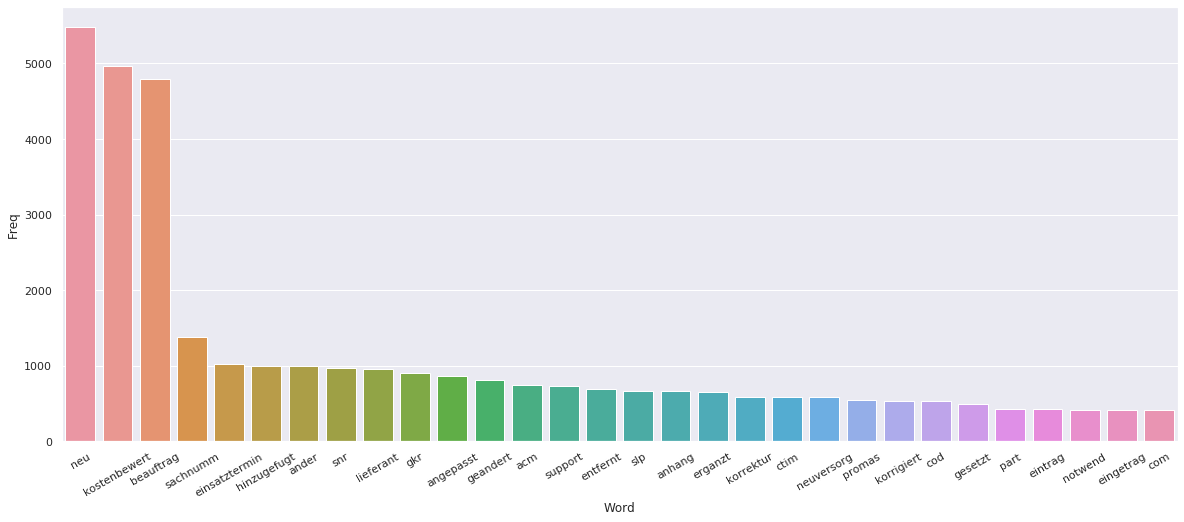

In [747]:
#Convert most freq words to datagrame for plotting bar plot
top_words = get_top_n_words(str_docs, n=30)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word","Freq"]

#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                        Bi-gram  Freq
0              kostenbewert neu  4779
1                 neu beauftrag  4774
2                   acm support   658
3                support promas   286
4             promas syntaxpruf   276
5               neuversorg ctim   262
6                   gkr eintrag   262
7                     part numb   259
8                  neu sachnumm   179
9             englisch ubersetz   170
10                   mail maier   135
11                 ctim notwend   126
12      einsatztermin angepasst   125
13         sachnumm hinzugefugt   115
14        genannt einsatztermin   114
15      neuversorg kostenbewert   112
16      sondervereinbar entfern   112
17  hak entwicklungsdienstleist   107
18                 reit prozess   104
19            kostenbewert mail    97
20           leitungssatz zweit    96
21               zweit erstellt    96
22            erstellt entwickl    96
23             entwickl rebmann    96
24                rebmann weiss    96
25          

[Text(0, 0, 'kostenbewert neu'),
 Text(0, 0, 'neu beauftrag'),
 Text(0, 0, 'acm support'),
 Text(0, 0, 'support promas'),
 Text(0, 0, 'promas syntaxpruf'),
 Text(0, 0, 'neuversorg ctim'),
 Text(0, 0, 'gkr eintrag'),
 Text(0, 0, 'part numb'),
 Text(0, 0, 'neu sachnumm'),
 Text(0, 0, 'englisch ubersetz'),
 Text(0, 0, 'mail maier'),
 Text(0, 0, 'ctim notwend'),
 Text(0, 0, 'einsatztermin angepasst'),
 Text(0, 0, 'sachnumm hinzugefugt'),
 Text(0, 0, 'genannt einsatztermin'),
 Text(0, 0, 'neuversorg kostenbewert'),
 Text(0, 0, 'sondervereinbar entfern'),
 Text(0, 0, 'hak entwicklungsdienstleist'),
 Text(0, 0, 'reit prozess'),
 Text(0, 0, 'kostenbewert mail'),
 Text(0, 0, 'leitungssatz zweit'),
 Text(0, 0, 'zweit erstellt'),
 Text(0, 0, 'erstellt entwickl'),
 Text(0, 0, 'entwickl rebmann'),
 Text(0, 0, 'rebmann weiss'),
 Text(0, 0, 'weiss kalwa'),
 Text(0, 0, 'kalwa nass'),
 Text(0, 0, 'nass entfernt'),
 Text(0, 0, 'termin angepasst'),
 Text(0, 0, 'weidlich snr')]

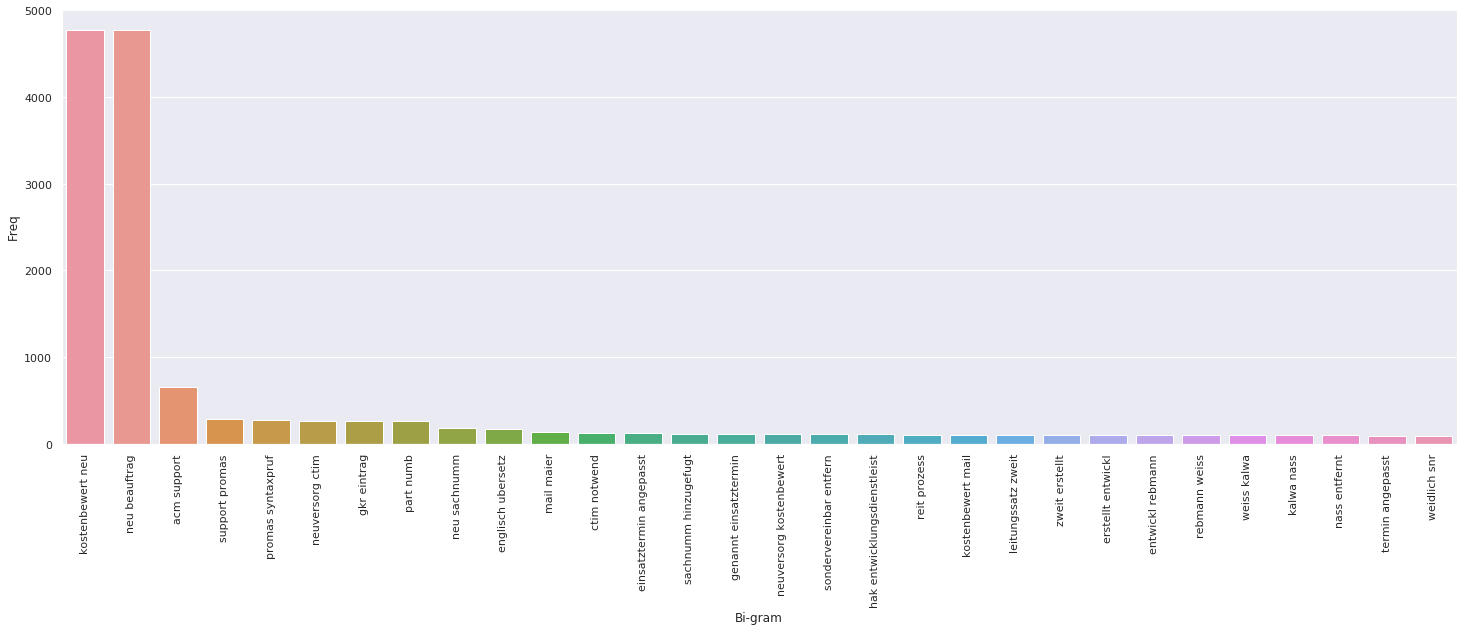

In [748]:
#Most frequently occuring Bi-grams
def get_top_n2_words(docs, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(docs)
    bag_of_words = vec1.transform(docs)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(str_docs, n=30)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(25,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90)

                        Tri-gram  Freq
0     kostenbewert neu beauftrag  4767
1             acm support promas   286
2      support promas syntaxpruf   276
3    leitungssatz zweit erstellt    96
4        zweit erstellt entwickl    96
5      erstellt entwickl rebmann    96
6         entwickl rebmann weiss    96
7            rebmann weiss kalwa    96
8               weiss kalwa nass    96
9            kalwa nass entfernt    96
10       neuversorg ctim notwend    88
11              acm support mail    87
12  neuversorg kostenbewert mail    83
13              ctim acm support    74
14     reit prozess stellungnahm    68
15       kostenbewert mail maier    62
16              ritzmann mla vst    57
17                   mla vst snr    57
18             vst snr platzhalt    57
19         snr platzhalt variant    57


[Text(0, 0, 'kostenbewert neu beauftrag'),
 Text(0, 0, 'acm support promas'),
 Text(0, 0, 'support promas syntaxpruf'),
 Text(0, 0, 'leitungssatz zweit erstellt'),
 Text(0, 0, 'zweit erstellt entwickl'),
 Text(0, 0, 'erstellt entwickl rebmann'),
 Text(0, 0, 'entwickl rebmann weiss'),
 Text(0, 0, 'rebmann weiss kalwa'),
 Text(0, 0, 'weiss kalwa nass'),
 Text(0, 0, 'kalwa nass entfernt'),
 Text(0, 0, 'neuversorg ctim notwend'),
 Text(0, 0, 'acm support mail'),
 Text(0, 0, 'neuversorg kostenbewert mail'),
 Text(0, 0, 'ctim acm support'),
 Text(0, 0, 'reit prozess stellungnahm'),
 Text(0, 0, 'kostenbewert mail maier'),
 Text(0, 0, 'ritzmann mla vst'),
 Text(0, 0, 'mla vst snr'),
 Text(0, 0, 'vst snr platzhalt'),
 Text(0, 0, 'snr platzhalt variant')]

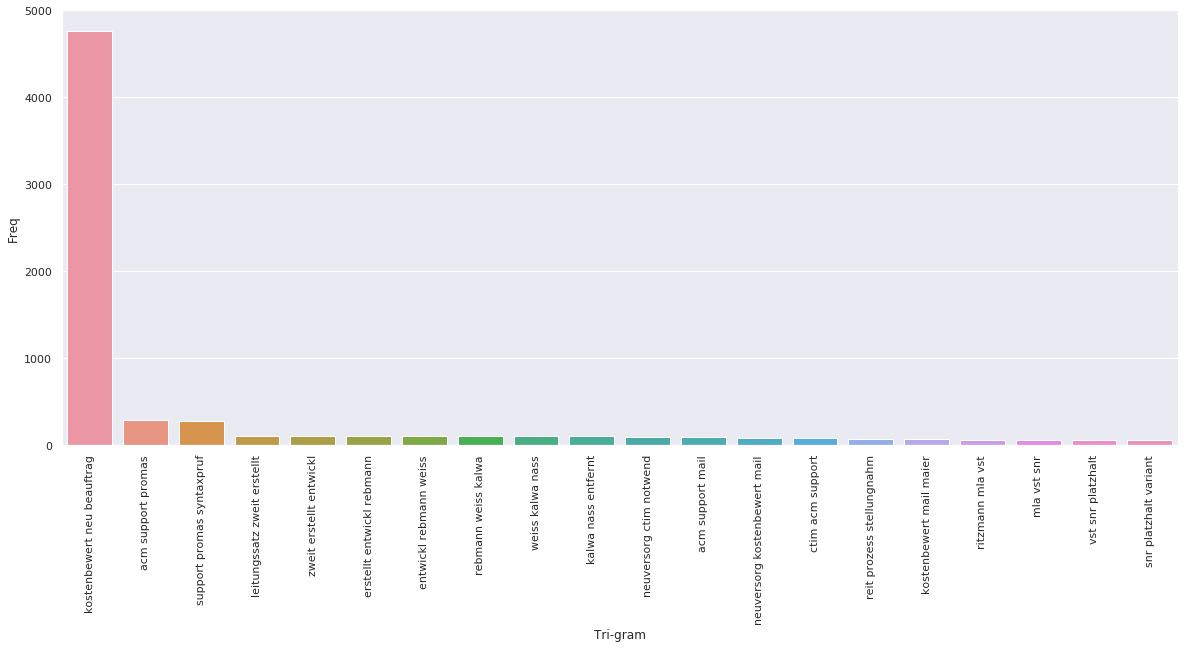

In [749]:
#Most frequently occuring Tri-grams
def get_top_n3_words(docs, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(docs)
    bag_of_words = vec1.transform(docs)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top3_words = get_top_n3_words(str_docs, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=90)

In [750]:
index_ruck_snr = df_bnd_ab.loc[df_bnd_ab['RUECKSPRUNG_KOMMENTAR'].str.contains('SNR')]['RUECKSPRUNG_KOMMENTAR'].index.tolist()
index_ruck_sachnummer = df_bnd_ab.loc[df_bnd_ab['RUECKSPRUNG_KOMMENTAR'].str.contains('Sachnummer')]['RUECKSPRUNG_KOMMENTAR'].index.tolist()
index_ruck_teil = df_bnd_ab.loc[df_bnd_ab['RUECKSPRUNG_KOMMENTAR'].str.contains('Teil')]['RUECKSPRUNG_KOMMENTAR'].index.tolist()

In [751]:
list_ruck_snr_relevant = []
list_ruck_snr_relevant = list(set(index_ruck_snr + index_ruck_sachnummer + index_ruck_teil))
len(list_ruck_snr_relevant)

2701

## 4. Analyzing influencing factors of processing time of Bündels

In [752]:
df_bnd_ab.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'KAT', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'MK', 'MK_BENENNUNG', 'ProduktKlasse', 'BR', 'AA', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'ANZAHL_PAKET',
       'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 'BRAA'],
      dtype='object')

In [753]:
# Focus on Abgeschlossen EC
df_bnd_ab_abgeschlossen = df_bnd_ab.loc[df_bnd_ab['PROZESS_STATUS'] == 'ABGESCHLOSSEN']

In [754]:
df_bnd_ab['BUENDEL_NUMMER'].nunique()

22349

In [755]:
df_bnd_ab_abgeschlossen.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'KAT', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'MK', 'MK_BENENNUNG', 'ProduktKlasse', 'BR', 'AA', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'ANZAHL_PAKET',
       'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 'BRAA'],
      dtype='object')

In [756]:
# for S-Class, there are 24462 Bündels
# Focus on 'Abgeschlossen' Bündels
df_bnd_ab.groupby(['PROZESS_STATUS'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

PROZESS_STATUS
ABGESCHLOSSEN        14585
BEWERTUNG             5452
ABGEBROCHEN           1628
NACH_NCM_VERSORGT      348
DETAILLIERUNG          298
VERTEILUNG              38
Name: BUENDEL_NUMMER, dtype: int64

In [757]:
df_bnd_ab_abgeschlossen.groupby(['RUECKMELDE_DATUM'])['BUENDEL_NUMMER'].nunique()

RUECKMELDE_DATUM
2014-07-21    1
2014-10-01    1
2014-10-02    1
2014-11-18    1
2014-12-25    1
             ..
2020-10-01    1
2020-10-15    1
2020-10-26    1
2020-11-09    1
2098-04-03    1
Name: BUENDEL_NUMMER, Length: 1349, dtype: int64

In [758]:
list_rueckdatum = df_bnd_ab_abgeschlossen['RUECKMELDE_DATUM'].tolist()

In [759]:
list_rueckdatum.sort()

In [760]:
# Feedback date is from 2014 to 2020
list_rueckdatum

[Timestamp('2014-07-21 00:00:00'),
 Timestamp('2014-07-21 00:00:00'),
 Timestamp('2014-07-21 00:00:00'),
 Timestamp('2014-07-21 00:00:00'),
 Timestamp('2014-07-21 00:00:00'),
 Timestamp('2014-10-01 00:00:00'),
 Timestamp('2014-10-01 00:00:00'),
 Timestamp('2014-10-01 00:00:00'),
 Timestamp('2014-10-02 00:00:00'),
 Timestamp('2014-10-02 00:00:00'),
 Timestamp('2014-10-02 00:00:00'),
 Timestamp('2014-10-02 00:00:00'),
 Timestamp('2014-10-02 00:00:00'),
 Timestamp('2014-10-02 00:00:00'),
 Timestamp('2014-11-18 00:00:00'),
 Timestamp('2014-11-18 00:00:00'),
 Timestamp('2014-11-18 00:00:00'),
 Timestamp('2014-11-18 00:00:00'),
 Timestamp('2014-11-18 00:00:00'),
 Timestamp('2014-11-18 00:00:00'),
 Timestamp('2014-11-18 00:00:00'),
 Timestamp('2014-11-18 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2014-12-

In [761]:
# Calculate duration of processing time of finished ECs
df_bnd_ab_abgeschlossen['CREATION_DATE'] = df_bnd_ab_abgeschlossen['CREATION_DATE'].apply(lambda x: pd.to_datetime(x).date())
df_bnd_ab_abgeschlossen['RUECKMELDE_DATUM'] = df_bnd_ab_abgeschlossen['RUECKMELDE_DATUM'].apply(lambda x: pd.to_datetime(x).date())
#df_bnd_ab_abgeschlossen['MODIFICATION_DATE'] = df_bnd_s_abgeschlossen['MODIFICATION_DATE'].apply(lambda x: pd.to_datetime(x).date())

df_bnd_ab_abgeschlossen['DAUER'] = df_bnd_ab_abgeschlossen['RUECKMELDE_DATUM'] - df_bnd_ab_abgeschlossen['CREATION_DATE']

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [762]:
df_bnd_ab_abgeschlossen[['CREATION_DATE','RUECKMELDE_DATUM','DAUER']]

CREATION_DATE RUECKMELDE_DATUM   DAUER
39       2017-07-10       2017-08-15 36 days
40       2017-07-10       2017-08-15 36 days
41       2017-07-10       2017-08-15 36 days
42       2017-07-10       2017-08-15 36 days
43       2017-07-10       2017-08-15 36 days
...             ...              ...     ...
95448    2016-06-20       2016-07-28 38 days
95449    2016-07-05       2016-10-06 93 days
95450    2016-07-05       2016-10-06 93 days
95451    2016-11-04       2016-12-08 34 days
95452    2016-11-04       2016-12-08 34 days

[56189 rows x 3 columns]

In [763]:
df_bnd_ab_abgeschlossen['DAUER'].sort_values(ascending=False)

89837   28861 days
89836   28861 days
89830   28861 days
89831   28861 days
89832   28861 days
           ...    
73252       0 days
73441       0 days
73253       0 days
73447       0 days
73442       0 days
Name: DAUER, Length: 56189, dtype: timedelta64[ns]

In [764]:
df_bnd_ab_abgeschlossen_dauer = df_bnd_ab_abgeschlossen.loc[(df_bnd_ab_abgeschlossen['DAUER'] > '1000 days')==True]
df_bnd_ab_abgeschlossen_dauer

Bnd_ID BUENDEL_NUMMER CREATION_DATE RUECKMELDE_DATUM  \
89830  1238231659547    0024164-005    2019-03-28       2098-04-03   
89831  1238231659547    0024164-005    2019-03-28       2098-04-03   
89832  1238231659547    0024164-005    2019-03-28       2098-04-03   
89833  1238231659547    0024164-005    2019-03-28       2098-04-03   
89834  1238231659547    0024164-005    2019-03-28       2098-04-03   
89835  1238231659547    0024164-005    2019-03-28       2098-04-03   
89836  1238231659547    0024164-005    2019-03-28       2098-04-03   
89837  1238231659547    0024164-005    2019-03-28       2098-04-03   

            MODIFICATION_DATE  STATUS  \
89830 2019-07-16 22:57:13.851  FERTIG   
89831 2019-07-16 22:57:13.851  FERTIG   
89832 2019-07-16 22:57:13.851  FERTIG   
89833 2019-07-16 22:57:13.851  FERTIG   
89834 2019-07-16 22:57:13.851  FERTIG   
89835 2019-07-16 22:57:13.851  FERTIG   
89836 2019-07-16 22:57:13.851  FERTIG   
89837 2019-07-16 22:57:13.851  FERTIG   

                                               BENENNUNG  \
89830  KT-04e Lagerbock Sturzstrebe links MFA1 ZB HAT...   
89831  KT-04e Lagerbock Sturzstrebe links MFA1 ZB HAT...   
89832  KT-04e Lagerbock Sturzstrebe links MFA1 ZB HAT...   
89833  KT-04e Lagerbock Sturzstrebe links MFA1 ZB HAT...   
89834  KT-04e Lagerbock Sturzstrebe links MFA1 ZB HAT...   
89835  KT-04e Lagerbock Sturzstrebe links MFA1 ZB HAT...   
89836  KT-04e Lagerbock Sturzstrebe links MFA1 ZB HAT...   
89837  KT-04e Lagerbock Sturzstrebe links MFA1 ZB HAT...   

                    STICHWORT VERURSACHER                                KAT  \
89830  BR243 BEV : Axle Parts          13                   Marktanforderung   
89831  BR243 BEV : Axle Parts          13  GuK-Fall - Verbesserung Qualitaet   
89832  BR243 BEV : Axle Parts          13                   Marktanforderung   
89833  BR243 BEV : Axle Parts          13  GuK-Fall - Verbesserung Qualitaet   
89834  BR243 BEV : Axle Parts          13                   Marktanforderung   
89835  BR243 BEV : Axle Parts          13  GuK-Fall - Verbesserung Qualitaet   
89836  BR243 BEV : Axle Parts          13                   Marktanforderung   
89837  BR243 BEV : Axle Parts          13  GuK-Fall - Verbesserung Qualitaet   

       ... ANZAHL_EXT ANZAHL_WERK_Ctime word_count_benennung  \
89830  ...        0.0               0.0                    8   
89831  ...        0.0               0.0                    8   
89832  ...        0.0               0.0                    8   
89833  ...        0.0               0.0                    8   
89834  ...        0.0               0.0                    8   
89835  ...        0.0               0.0                    8   
89836  ...        0.0               0.0                    8   
89837  ...        0.0               0.0                    8   

      word_count_stichwort word_count_rueck word_count_berg_rueck  \
89830                    5                1                     1   
89831                    5                1                     1   
89832                    5                1                     1   
89833                    5                1                     1   
89834                    5                1                     1   
89835                    5                1                     1   
89836                    5                1                     1   
89837                    5                1                     1   

      word_count_ist word_count_soll                             BRAA  \
89830             11              13  C117/FC;C117/FX;C246/FS;C246/FX   
89831             11              13  C117/FC;C117/FX;C246/FS;C246/FX   
89832             11              13  C117/FC;C117/FX;C246/FS;C246/FX   
89833             11              13  C117/FC;C117/FX;C246/FS;C246/FX   
89834             11              13  C117/FC;C117/FX;C246/FS;C246/FX   
89835             11              13  C117/FC;C117/FX;C246/FS;C246/FX   
89836             11              13  C11

In [765]:
df_bnd_ab_abgeschlossen_dauer[['BUENDEL_NUMMER','ANZAHL_PAKET','BRAA']]

BUENDEL_NUMMER  ANZAHL_PAKET                             BRAA
89830    0024164-005             4  C117/FC;C117/FX;C246/FS;C246/FX
89831    0024164-005             4  C117/FC;C117/FX;C246/FS;C246/FX
89832    0024164-005             4  C117/FC;C117/FX;C246/FS;C246/FX
89833    0024164-005             4  C117/FC;C117/FX;C246/FS;C246/FX
89834    0024164-005             4  C117/FC;C117/FX;C246/FS;C246/FX
89835    0024164-005             4  C117/FC;C117/FX;C246/FS;C246/FX
89836    0024164-005             4  C117/FC;C117/FX;C246/FS;C246/FX
89837    0024164-005             4  C117/FC;C117/FX;C246/FS;C246/FX

In [766]:
# drop bundels with wrong Ruckmeldung_datum, e.g. in year 2033...2099 
df_bnd_ab_abgeschlossen_dauer = df_bnd_ab_abgeschlossen.loc[(df_bnd_ab_abgeschlossen['DAUER'] > '1000 days')==False]
df_bnd_ab_abgeschlossen_dauer

Bnd_ID BUENDEL_NUMMER CREATION_DATE RUECKMELDE_DATUM  \
39     1218221848023    0031257-002    2017-07-10       2017-08-15   
40     1218221848023    0031257-002    2017-07-10       2017-08-15   
41     1218221848023    0031257-002    2017-07-10       2017-08-15   
42     1218221848023    0031257-002    2017-07-10       2017-08-15   
43     1218221848023    0031257-002    2017-07-10       2017-08-15   
...              ...            ...           ...              ...   
95448  1205618337152    0012951-002    2016-06-20       2016-07-28   
95449  1206103003088    0013933-003    2016-07-05       2016-10-06   
95450  1206103003088    0013933-003    2016-07-05       2016-10-06   
95451  1209326229139    0020340-001    2016-11-04       2016-12-08   
95452  1209326229139    0020340-001    2016-11-04       2016-12-08   

            MODIFICATION_DATE  STATUS  \
39    2019-08-13 22:47:20.441  FERTIG   
40    2019-08-13 22:47:20.441  FERTIG   
41    2019-08-13 22:47:20.441  FERTIG   
42    2019-08-13 22:47:20.441  FERTIG   
43    2019-08-13 22:47:20.441  FERTIG   
...                       ...     ...   
95448 2018-07-31 23:59:16.041  FERTIG   
95449 2016-11-10 18:28:11.051  FERTIG   
95450 2016-11-10 18:28:11.051  FERTIG   
95451 2018-07-31 23:55:15.059  FERTIG   
95452 2018-07-31 23:55:15.059  FERTIG   

                                      BENENNUNG  \
39                               Standardbündel   
40                               Standardbündel   
41                               Standardbündel   
42                               Standardbündel   
43                               Standardbündel   
...                                         ...   
95448                  MFA2 MG11 IT Opti BF NIS   
95449      MFA2 MG11 I-Träger Blankfreigabe NIS   
95450      MFA2 MG11 I-Träger Blankfreigabe NIS   
95451  MG11 MFA2 Entfall I-Träger MR20 Variante   
95452  MG11 MFA2 Entfall I-Träger MR20 Variante   

                                       STICHWORT VERURSACHER  \
39     MG31 Freigabe neuer Teilenummern für MFA2          34   
40     MG31 Freigabe neuer Teilenummern für MFA2          34   
41     MG31 Freigabe neuer Teilenummern für MFA2          34   
42     MG31 Freigabe neuer Teilenummern für MFA2          34   
43     MG31 Freigabe neuer Teilenummern für MFA2          34   
...                                          ...         ...   
95448             MFA2 MG11 IT Opti BF PS und DS          12   
95449           MFA2 MG11 I-Träger Blankfreigabe          12   
95450           MFA2 MG11 I-Träger Blankfreigabe          12   
95451   MG11 MFA2 Entfall I-Träger MR20 Variante          21   
95452   MG11 MFA2 Entfall I-Träger MR20 Variante          21   

                                     KAT  ... ANZAHL_EXT ANZAHL_WERK_Ctime  \
39     GuK-Fall - Verbesserung Qualitaet  ...        9.0               8.0   
40     GuK-Fall - Verbesserung Qualitaet  ...        9.0               8.0   
41     GuK-Fall - Verbesserung Qualitaet  ...        9.0               8.0   
42     GuK-Fall - Verbesserung Qualitaet  ...        9.0               8.0   
43     GuK-Fall - Verbesserung Qualitaet  ...        9.0               8.0   
...                                  ...  ...        ...               ...   
95448  GuK-Fall - Verbesserung Qualitaet  ...        1.0               1.0   
95449  GuK-Fall - Verbesserung Qualitaet  ...        1.0               1.0   
95450  GuK-Fall - Verbesserung Qualitaet  ...        1.0               1.0   
95451                   Marktanforderung  ...        1.0               0.0   
95452                   Marktanforderung  ...        1.0               0.0   

      word_count_benennung word_count_stichwort word_count_rueck  \
39                       1                    6                1   
40                       1                    6                1   
41                       1                    6                1   
42                       1                    6                1   
43                   

In [767]:
# average duration of Bundel processing time for S-Class is 66 days
df_bnd_ab_abgeschlossen_dauer['DAUER'].describe()

count                      56181
mean     62 days 10:58:31.379291
std      60 days 19:29:17.984901
min              0 days 00:00:00
25%             33 days 00:00:00
50%             43 days 00:00:00
75%             69 days 00:00:00
max            685 days 00:00:00
Name: DAUER, dtype: object

In [768]:
df_bnd_ab_abgeschlossen_dauer.loc[df_bnd_ab_abgeschlossen_dauer['DAUER']<'1 days 00:00:00']

Bnd_ID BUENDEL_NUMMER CREATION_DATE RUECKMELDE_DATUM  \
18873  1232024641789    0032339-007    2018-10-09       2018-10-09   
73252  1246565945017    0057606-015    2019-11-25       2019-11-25   
73253  1246565945017    0057606-015    2019-11-25       2019-11-25   
73407  1247657325334    0072562-001    2020-01-09       2020-01-09   
73441  1247657325079    0072258-002    2019-12-18       2019-12-18   
73442  1247657325079    0072258-002    2019-12-18       2019-12-18   
73447  1243015414643    0066855-001    2019-08-20       2019-08-20   

            MODIFICATION_DATE  STATUS  \
18873 2019-10-18 22:43:45.079  FERTIG   
73252 2020-02-24 22:46:44.879  FERTIG   
73253 2020-02-24 22:46:44.879  FERTIG   
73407 2020-05-18 22:38:42.941  FERTIG   
73441 2020-07-08 22:41:41.716  FERTIG   
73442 2020-07-08 22:41:41.716  FERTIG   
73447 2020-01-21 08:10:03.073  FERTIG   

                                               BENENNUNG  \
18873         KTF-01 MFA2 Kraftstoffleitung AMG für Z177   
73252    KTF04e MFA2 AMG H247 kürzere Schraube FL an HAT   
73253    KTF04e MFA2 AMG H247 kürzere Schraube FL an HAT   
73407  KTF08 - H247 AMG STF VO Schraubenwechs KZB ECE...   
73441            KT06 - AMG - Befestigungsmaterial BR247   
73442            KT06 - AMG - Befestigungsmaterial BR247   
73447  KTF08 - H247 Performance Lower Stiff. Anp. Bes...   

                                               STICHWORT VERURSACHER  \
18873  MFA2 MG52 Kraftstoffleitungen Verlaufsoptimierung          12   
73252                   Verstärkung Spurstangenanbindung          13   
73253                   Verstärkung Spurstangenanbindung          13   
73407  KTF08 - H247 AMG STF VO Schraubenwechs KZB ECE...          31   
73441         KT06 - AMG - Befestigungsmaterial fuer AMG          20   
73442         KT06 - AMG - Befestigungsmaterial fuer AMG          20   
73447  KTF08 - H247 Performance Lower Stiff. Anp. Bes...          20   

                                     KAT  ... ANZAHL_EXT ANZAHL_WERK_Ctime  \
18873  GuK-Fall - Verbesserung Qualitaet  ...        0.0               0.0   
73252                   Marktanforderung  ...        1.0               1.0   
73253  GuK-Fall - Verbesserung Qualitaet  ...        1.0               1.0   
73407  GuK-Fall - Verbesserung Qualitaet  ...        3.0               4.0   
73441                   Marktanforderung  ...        2.0               0.0   
73442                   Marktanforderung  ...        2.0               0.0   
73447  GuK-Fall - Verbesserung Qualitaet  ...        2.0               2.0   

      word_count_benennung word_count_stichwort word_count_rueck  \
18873                    6                    4                1   
73252                    9                    2                1   
73253                    9                    2                1   
73407                    9                    9                1   
73441                    6                    7                1   
73442                    6                    7                1   
73447                    8                    8                1   

      word_count_berg_rueck word_count_ist word_count_soll             BRAA  \
18873                     1             15              35          C177/FZ   
73252                     1             36              50          C247/FH   
73253                     1             36              50          C247/FH   
73407                     1             24              23          C247/FH   
73441                     1              4               4  C247/FH;C247/FX   
73442                     1              4               4  C247/FH;C247/FX   
73447                     1             19              13          C247/FH   

       DAUER  
18873 0 days  
73252 0 days  
73253 0 days  
73407 0 days  
73441 0 days  
73442 0 days  
73447 0 days  

[7 rows x 43 columns]

In [769]:
# Histogram Dauer
quantile_list = [0, .25, .5, .75, 1.]


quantiles = df_bnd_ab_abgeschlossen_dauer['DAUER'].quantile(quantile_list).astype('timedelta64[D]').quantile(quantile_list)
quantiles

# quantiles_new = df_bnd_s_abgeschlossen_dauer.loc[input_df_cal_dauer['RUECKSPRUNG_KOMMENTAR'].str.contains('nan')==False]['Dauer'].astype('timedelta64[D]').quantile(quantile_list)
# quantiles_new

0.00      0.0
0.25     33.0
0.50     43.0
0.75     69.0
1.00    685.0
Name: DAUER, dtype: float64

Text(0, 0.5, 'Number of ECRs')

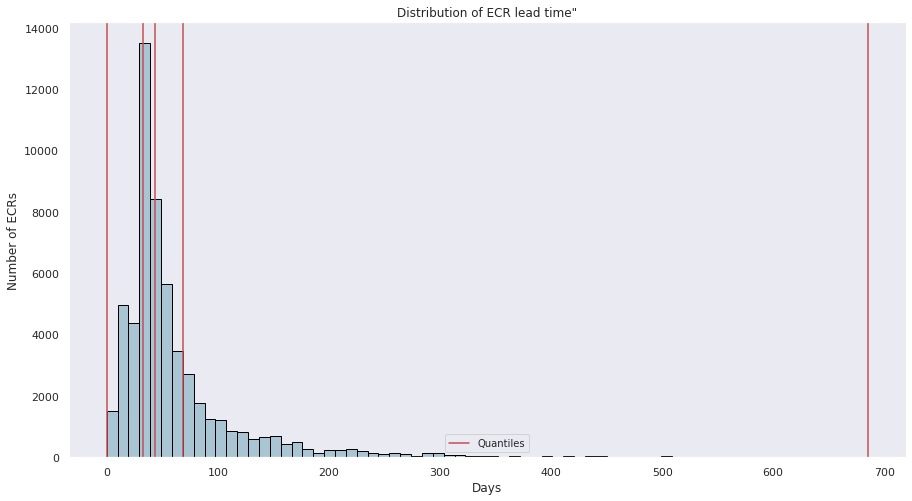

In [770]:
fig, ax = plt.subplots(figsize=(15,8))
df_bnd_ab_abgeschlossen_dauer['DAUER'].astype('timedelta64[D]').hist(bins=70, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Distribution of ECR lead time"', 
             fontsize=12)
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Number of ECRs', fontsize=12)

In [771]:
# Labeling Bündel with Duration Category
# def dauer_cat(row):
#     if row['DAUER'] > pd.to_timedelta('42 days'):
#         val = 'longer'
#     elif row['DAUER'] < pd.to_timedelta('42 days'):
#         val = 'shorter'
#     else:
#         val = 'equal'
#     return val

def dauer_cat(row):
    if row['DAUER'] <= pd.to_timedelta('41 days'):
        val = 'Shorter'
    #elif (row['DAUER'] > pd.to_timedelta('42 days')) & (row['DAUER'] <= pd.to_timedelta('64 days')):
        #val = 'Q2'
#     elif (row['DAUER'] > pd.to_timedelta('33 days')) & (row['DAUER'] <= pd.to_timedelta('64 days')):
#         val = 'Q3'
    else:
        val = 'Longer'
    return val

df_bnd_ab_abgeschlossen_dauer['DAUER_KAT'] = df_bnd_ab_abgeschlossen_dauer.apply(dauer_cat, axis=1)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [772]:
df_bnd_ab_abgeschlossen_dauer[['DAUER','DAUER_KAT']]

DAUER DAUER_KAT
39    36 days   Shorter
40    36 days   Shorter
41    36 days   Shorter
42    36 days   Shorter
43    36 days   Shorter
...       ...       ...
95448 38 days   Shorter
95449 93 days    Longer
95450 93 days    Longer
95451 34 days   Shorter
95452 34 days   Shorter

[56181 rows x 2 columns]

## 5. Change Impact Analysis

### Load SNR related data

In [773]:
df_snrimbuendel = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD301_SachnummerImBuendelEntity.parquet', engine='pyarrow')

In [774]:
df_snrimbuendel = df_snrimbuendel[['SACHNUMMER','BUENDEL_FK','MODULSUBKOMPONENTE','ZB_BENENNUNG',
                                   'MODULGRUPPE','EMISSIONSKENNZEICHEN','BESCHAFFUNGSART',
                                   'SICHERHEITSRELEVANT','TEILEART','WERKZEUGAENDERUNG_ERFORDERLICH',
                                   'EE_STEUERGERAET_BETROFFEN','BETRIEBSANLEITUNG_BETROFFEN',
                                   'LEITUNGSSATZ_BETROFFEN','LASTENHEFTAENDERUNG_ERFORDERLICH',
                                   'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN']]

In [775]:
# merge with buendel entity to get buendel number
new_df_linkbuendelsnr = df_bnd_ab_abgeschlossen_dauer.merge(df_snrimbuendel, left_on='Bnd_ID', right_on='BUENDEL_FK')

In [776]:
new_df_linkbuendelsnr.head()

Bnd_ID BUENDEL_NUMMER CREATION_DATE RUECKMELDE_DATUM  \
0  1218221848023    0031257-002    2017-07-10       2017-08-15   
1  1218221848023    0031257-002    2017-07-10       2017-08-15   
2  1218221848023    0031257-002    2017-07-10       2017-08-15   
3  1218221848023    0031257-002    2017-07-10       2017-08-15   
4  1218221848023    0031257-002    2017-07-10       2017-08-15   

        MODIFICATION_DATE  STATUS       BENENNUNG  \
0 2019-08-13 22:47:20.441  FERTIG  Standardbündel   
1 2019-08-13 22:47:20.441  FERTIG  Standardbündel   
2 2019-08-13 22:47:20.441  FERTIG  Standardbündel   
3 2019-08-13 22:47:20.441  FERTIG  Standardbündel   
4 2019-08-13 22:47:20.441  FERTIG  Standardbündel   

                                   STICHWORT VERURSACHER  \
0  MG31 Freigabe neuer Teilenummern für MFA2          34   
1  MG31 Freigabe neuer Teilenummern für MFA2          34   
2  MG31 Freigabe neuer Teilenummern für MFA2          34   
3  MG31 Freigabe neuer Teilenummern für MFA2          34   
4  MG31 Freigabe neuer Teilenummern für MFA2          34   

                                 KAT  ... EMISSIONSKENNZEICHEN  \
0  GuK-Fall - Verbesserung Qualitaet  ...                 NEIN   
1  GuK-Fall - Verbesserung Qualitaet  ...                 NEIN   
2  GuK-Fall - Verbesserung Qualitaet  ...                 NEIN   
3  GuK-Fall - Verbesserung Qualitaet  ...                 NEIN   
4  GuK-Fall - Verbesserung Qualitaet  ...                 NEIN   

  BESCHAFFUNGSART SICHERHEITSRELEVANT TEILEART WERKZEUGAENDERUNG_ERFORDERLICH  \
0        KAUFTEIL                NEIN  MO_TEIL                           NEIN   
1        KAUFTEIL                NEIN  MO_TEIL                           None   
2        KAUFTEIL                NEIN  MO_TEIL                           None   
3        KAUFTEIL                NEIN  MO_TEIL                           None   
4        KAUFTEIL                NEIN  MO_TEIL                           None   

  EE_STEUERGERAET_BETROFFEN BETRIEBSANLEITUNG_BETROFFEN  \
0                      NEIN                        NEIN   
1                      NEIN                        NEIN   
2                      NEIN                        NEIN   
3                      NEIN                        NEIN   
4                      NEIN                        NEIN   

  LEITUNGSSATZ_BETROFFEN LASTENHEFTAENDERUNG_ERFORDERLICH  \
0                   NEIN                             NEIN   
1                   NEIN                             NEIN   
2                   NEIN                             NEIN   
3                   NEIN                             NEIN   
4                   NEIN                             NEIN   

  VERSUCHSTEIL_ASACHNUMMER_BETROFFEN  
0                               None  
1                               None  
2                               None  
3                               None  
4                               None  

[5 rows x 59 columns]

In [777]:
# choose relavent columns to form a new dataframe
df_linkbuendelsnr = pd.DataFrame
df_linkbuendelsnr = new_df_linkbuendelsnr[['BUENDEL_NUMMER','SACHNUMMER','MODULSUBKOMPONENTE','ZB_BENENNUNG','MODULGRUPPE',
                                          'EMISSIONSKENNZEICHEN','BESCHAFFUNGSART',
                                          'SICHERHEITSRELEVANT','TEILEART','WERKZEUGAENDERUNG_ERFORDERLICH',
                                          'EE_STEUERGERAET_BETROFFEN','BETRIEBSANLEITUNG_BETROFFEN',
                                          'LEITUNGSSATZ_BETROFFEN','LASTENHEFTAENDERUNG_ERFORDERLICH',
                                          'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN']]
df_linkbuendelsnr

BUENDEL_NUMMER   SACHNUMMER MODULSUBKOMPONENTE            ZB_BENENNUNG  \
0         0031257-002  A2479006503              03701  LU STG VST SITZ FAHRER   
1         0031257-002  A2479020100              03701           SW SITZ BEIF.   
2         0031257-002  A2479000200              03701   LU STG VST SITZ BEIF.   
3         0031257-002  A2479002501              03701  LU STG VST SITZ FAHRER   
4         0031257-002  A2479030000              03701   PMD SITZ FAHRER BEIF.   
...               ...          ...                ...                     ...   
513351    0013933-003  A0926200000              08301  ZB INTEGRALTRAEGER VST   
513352    0020340-001  A0926260000              09001              KONSOLE VO   
513353    0020340-001  A0926200000              08301  ZB INTEGRALTRAEGER VST   
513354    0020340-001  A0926260000              09001              KONSOLE VO   
513355    0020340-001  A0926200000              08301  ZB INTEGRALTRAEGER VST   

       MODULGRUPPE EMISSIONSKENNZEICHEN BESCHAFFUNGSART SICHERHEITSRELEVANT  \
0              062                 NEIN        KAUFTEIL                NEIN   
1              062                 NEIN        KAUFTEIL                NEIN   
2              062                 NEIN        KAUFTEIL                NEIN   
3              062                 NEIN        KAUFTEIL                NEIN   
4              062                 NEIN        KAUFTEIL                NEIN   
...            ...                  ...             ...                 ...   
513351         011                 NEIN        KAUFTEIL                  JA   
513352         011                 NEIN        KAUFTEIL                  JA   
513353         011                 NEIN        KAUFTEIL                  JA   
513354         011                 NEIN        KAUFTEIL                  JA   
513355         011                 NEIN        KAUFTEIL                  JA   

       TEILEART WERKZEUGAENDERUNG_ERFORDERLICH EE_STEUERGERAET_BETROFFEN  \
0       MO_TEIL                           NEIN                      NEIN   
1       MO_TEIL                           None                      NEIN   
2       MO_TEIL                           None                      NEIN   
3       MO_TEIL                           None                      NEIN   
4       MO_TEIL                           None                      NEIN   
...         ...                            ...                       ...   
513351  MO_TEIL                           None                      NEIN   
513352  MO_TEIL                           None                      NEIN   
513353  MO_TEIL                           None                      NEIN   
513354  MO_TEIL                           None                      NEIN   
513355  MO_TEIL                           None                      NEIN   

       BETRIEBSANLEITUNG_BETROFFEN LEITUNGSSATZ_BETROFFEN  \
0                             NEIN                   NEIN   
1                             NEIN                   NEIN   
2                             NEIN                   NEIN   
3                             NEIN                   NEIN   
4                             NEIN                   NEIN   
...                            ...                    ...   
513351                        NEIN                   NEIN   
513352                        NEIN                   NEIN   
513353                        NEIN                   NEIN   
513354                        NEIN                   NEIN   
513355                        NEIN                   NEIN   

       LASTENHEFTAENDERUNG_ERFORDERLICH VERSUCHSTEIL_ASACHNUMMER_BETROFFEN  
0                                  NEIN                               None  
1                                  NEIN                               None  
2                                  NEIN                               None  
3                                  NEIN                               None  
4                                  NEIN               

In [778]:
# only focus on A-SNR
df_linkbuendelsnr['Kennbuchstabe'] = df_linkbuendelsnr['SACHNUMMER'].astype(str).str[0]
indexNames_dropsnr_notA = df_linkbuendelsnr.loc[df_linkbuendelsnr['Kennbuchstabe'] != 'A'].index
df_linkbuendelsnr.drop(indexNames_dropsnr_notA, inplace=True)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/yuwepan/.local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [779]:
df_linkbuendelsnr['MODULSUBKOMPONENTE'] = df_linkbuendelsnr['MODULSUBKOMPONENTE'].fillna(0)
df_linkbuendelsnr['MODULGRUPPE'] = df_linkbuendelsnr['MODULGRUPPE'].fillna(999)

# convert columns to appropriate datatype
df_linkbuendelsnr['BUENDEL_NUMMER'] = df_linkbuendelsnr['BUENDEL_NUMMER'].astype('str')
df_linkbuendelsnr['SACHNUMMER'] = df_linkbuendelsnr['SACHNUMMER'].astype('str')
df_linkbuendelsnr['MODULSUBKOMPONENTE'] = df_linkbuendelsnr['MODULSUBKOMPONENTE'].astype('int')
df_linkbuendelsnr['ZB_BENENNUNG'] = df_linkbuendelsnr['ZB_BENENNUNG'].astype('str')
df_linkbuendelsnr['MODULGRUPPE'] = df_linkbuendelsnr['MODULGRUPPE'].astype('int')

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [780]:
# extract MK und MSK from the 5-digit MODULSUBKOMPONENT
for i, row in df_linkbuendelsnr.iterrows():
    temp_msk = str(row['MODULSUBKOMPONENTE']).zfill(5)
    #df_linkbuendelsnr.set_value(i,'MSK',temp_msk)
    df_linkbuendelsnr.at[i,'MSK'] = temp_msk

/home/yuwepan/.local/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/yuwepan/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [781]:
for i, row in df_linkbuendelsnr.iterrows():
    temp_mk = row['MSK'][0:3]
    temp_msubk = row['MSK'][3:5]
    #df_linkbuendelsnr.set_value(i,'MK',temp_mk)
    #df_linkbuendelsnr.set_value(i,'SUBK',temp_msubk)
    df_linkbuendelsnr.at[i,'MK'] = temp_mk
    df_linkbuendelsnr.at[i,'SUBK'] = temp_msubk

In [782]:
# drop items in which MG or MK is invalid
df_linkbuendelsnr = df_linkbuendelsnr.drop('MODULSUBKOMPONENTE', 1)

### Decompose SNR into:

* Kennbuchstabe (SNR-Kennbuchstabe) → 1. Stelle in der A-Sachnummer
* Typzahl → 2. bis einschließlich 4. Stelle in der A-Sachnummer
* Konstruktions_Haupt_und_Untergruppe (Konstruktions-Haupt- und Untergruppe) → 5. bis einschließlich 7. Stelle der A-Sachnummer
* Fortlaufende_Nummer (Abwandlung oder fortlaufende Nummer) → 8. und 9. Stelle der A-Sachnummer
* Teilnummer_Untergruppe (Teilnummer bezogen auf die Untergruppe) → 10. und 11. Stelle der A-Sachnummer

In [783]:
for i, row in df_linkbuendelsnr.iterrows():
    temp_typzahl = 'No Value'
    temp_kg = 'No Value'
    temp_u = 'No Value'
    temp_kgu = 'No Value'
    temp_fortlaufende_nummer = 'No Value'
    temp_teilnummer_untergruppe = 'No Value'
    
    temp_typzahl = row['SACHNUMMER'][1:4]
    temp_kg = row['SACHNUMMER'][4:6]
    temp_u = row['SACHNUMMER'][6:7]
    temp_kgu = row['SACHNUMMER'][4:7]
    temp_fortlaufende_nummer = row['SACHNUMMER'][7:9]
    temp_teilnummer_untergruppe = row['SACHNUMMER'][9:11]
    
#     df_snrimbuendel.set_value(i,'TypZahl',temp_typzahl)
#     df_snrimbuendel.set_value(i,'Konstruktions_Haupt_und_Untergruppe',temp_k_haupt_untergruppe)
#     df_snrimbuendel.set_value(i,'Fortlaufende_Nummer',temp_fortlaufende_nummer)
#     df_snrimbuendel.set_value(i,'Teilnummer_Untergruppe',temp_teilnummer_untergruppe)
    df_linkbuendelsnr.at[i,'TypZahl'] = temp_typzahl
    df_linkbuendelsnr.at[i,'KG'] = temp_kg
    df_linkbuendelsnr.at[i,'U'] = temp_u
    df_linkbuendelsnr.at[i,'KGU'] = temp_kgu
    df_linkbuendelsnr.at[i,'Fortlaufende_Nummer'] = temp_fortlaufende_nummer
    df_linkbuendelsnr.at[i,'Teilnummer_Untergruppe'] = temp_teilnummer_untergruppe

### Merge two dataframes: df_linkbuendelsnr and df_bnd_s_abgeschlossen_dauer, link SNRs with change description

In [784]:
df_linkbuendelsnr.head()

BUENDEL_NUMMER   SACHNUMMER            ZB_BENENNUNG  MODULGRUPPE  \
0    0031257-002  A2479006503  LU STG VST SITZ FAHRER           62   
1    0031257-002  A2479020100           SW SITZ BEIF.           62   
2    0031257-002  A2479000200   LU STG VST SITZ BEIF.           62   
3    0031257-002  A2479002501  LU STG VST SITZ FAHRER           62   
4    0031257-002  A2479030000   PMD SITZ FAHRER BEIF.           62   

  EMISSIONSKENNZEICHEN BESCHAFFUNGSART SICHERHEITSRELEVANT TEILEART  \
0                 NEIN        KAUFTEIL                NEIN  MO_TEIL   
1                 NEIN        KAUFTEIL                NEIN  MO_TEIL   
2                 NEIN        KAUFTEIL                NEIN  MO_TEIL   
3                 NEIN        KAUFTEIL                NEIN  MO_TEIL   
4                 NEIN        KAUFTEIL                NEIN  MO_TEIL   

  WERKZEUGAENDERUNG_ERFORDERLICH EE_STEUERGERAET_BETROFFEN  ... Kennbuchstabe  \
0                           NEIN                      NEIN  ...             A   
1                           None                      NEIN  ...             A   
2                           None                      NEIN  ...             A   
3                           None                      NEIN  ...             A   
4                           None                      NEIN  ...             A   

     MSK   MK SUBK TypZahl  KG  U  KGU Fortlaufende_Nummer  \
0  03701  037   01     247  90  0  900                  65   
1  03701  037   01     247  90  2  902                  01   
2  03701  037   01     247  90  0  900                  02   
3  03701  037   01     247  90  0  900                  25   
4  03701  037   01     247  90  3  903                  00   

  Teilnummer_Untergruppe  
0                     03  
1                     00  
2                     00  
3                     01  
4                     00  

[5 rows x 24 columns]

In [1429]:
df_linkbuendelsnr[df_linkbuendelsnr['BUENDEL_NUMMER']=='0053111-001']['SACHNUMMER']

369663    A2476809901
Name: SACHNUMMER, dtype: object

In [785]:
df_linkbuendelsnr['BUENDEL_NUMMER'].nunique()

14007

In [786]:
df_amount_snr = df_linkbuendelsnr.groupby(['BUENDEL_NUMMER'])['SACHNUMMER'].nunique().reset_index()
df_amount_snr.columns = ['BUENDEL_NUMMER','ANZAHL_SACHNUMMER']

df_amount_snr_benennung = df_linkbuendelsnr.groupby(['BUENDEL_NUMMER'])['ZB_BENENNUNG'].nunique().reset_index()
df_amount_snr_benennung.columns = ['BUENDEL_NUMMER','ANZAHL_ZB_BENENNUNG']

df_linkbuendelsnr = df_linkbuendelsnr.merge(df_amount_snr, left_on = 'BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
df_linkbuendelsnr = df_linkbuendelsnr.merge(df_amount_snr_benennung, left_on = 'BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [787]:
df_buendel_linked = df_linkbuendelsnr.merge(df_bnd_ab_abgeschlossen_dauer, left_on = 'BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [788]:
df_buendel_linked = df_buendel_linked.drop_duplicates()

In [789]:
df_buendel_linked.columns

Index(['BUENDEL_NUMMER', 'SACHNUMMER', 'ZB_BENENNUNG', 'MODULGRUPPE',
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH',
       'EE_STEUERGERAET_BETROFFEN', 'BETRIEBSANLEITUNG_BETROFFEN',
       'LEITUNGSSATZ_BETROFFEN', 'LASTENHEFTAENDERUNG_ERFORDERLICH',
       'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN', 'Kennbuchstabe', 'MSK', 'MK_x',
       'SUBK', 'TypZahl', 'KG', 'U', 'KGU', 'Fortlaufende_Nummer',
       'Teilnummer_Untergruppe', 'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG',
       'Bnd_ID', 'CREATION_DATE', 'RUECKMELDE_DATUM', 'MODIFICATION_DATE',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'KAT', 'new_IST',
       'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'MK_y', 'MK_BE

In [790]:
df_buendel_linked = df_buendel_linked.drop(columns=['BR','AA'])

In [791]:
df_buendel_linked.columns = ['BUENDEL_NUMMER', 'SACHNUMMER', 'ZB_BENENNUNG', 'MODULGRUPPE',
                             'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
                             'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH',
                             'EE_STEUERGERAET_BETROFFEN', 'BETRIEBSANLEITUNG_BETROFFEN',
                             'LEITUNGSSATZ_BETROFFEN', 'LASTENHEFTAENDERUNG_ERFORDERLICH',
                             'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN','Kennbuchstabe', 'MSK', 'MK', 
                             'SUBK', 'TypZahl', 'KG', 'U', 'KGU','Fortlaufende_Nummer', 
                             'Teilnummer_Untergruppe', 'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG',
                             'Bnd_ID','CREATION_DATE', 'RUECKMELDE_DATUM', 'MODIFICATION_DATE',
                             'STATUS', 'BENENNUNG', 'STICHWORT','VERURSACHER','Bnd_KAT','new_IST', 
                             'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
                             'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
                             'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
                             'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
                             'Bnd_MK', 'Bnd_MK_BENENNUNG', 'ProduktKlasse', 'WERKSKENNBUCHSTABE',
                             'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime','ANZAHL_PAKET', 
                             'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
                             'word_count_benennung','word_count_stichwort', 'word_count_rueck', 
                             'word_count_berg_rueck','word_count_ist', 'word_count_soll',  
                             'BRAA','DAUER', 'DAUER_KAT']


In [792]:
df_buendel_linked = df_buendel_linked.merge(df_mk, left_on='MK', right_on='MK')

In [793]:
df_buendel_linked[['BUENDEL_NUMMER','ANZAHL_PAKET','BRAA']]

BUENDEL_NUMMER  ANZAHL_PAKET  \
0         0031257-002            17   
1         0031257-002            17   
2         0031257-002            17   
3         0031257-002            17   
4         0031257-002            17   
...               ...           ...   
462768    0006909-001             8   
462769    0006909-001             8   
462770    0006909-001             8   
462771    0006909-001             8   
462772    0011890-002             2   

                                                     BRAA  
0       C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
1       C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
2       C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
3       C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
4       C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
...                                                   ...  
462768    C117/FC;C117/FX;C246/FS;C246/FX;C246/FT;C091/FX  
462769    C117/FC;C117/FX;C246/FS;C246/FX;C246/FT;C091/FX  
462770    C117/FC;C117/FX;C246/FS;C246/FX;C246/FT;C091/FX  
462771    C117/FC;C117/FX;C246/FS;C246/FX;C246/FT;C091/FX  
462772                                            C246/FS  

[462773 rows x 3 columns]

In [794]:
df_buendel_linked.loc[df_buendel_linked['ANZAHL_PAKET']==2]['BRAA'].head(200)

621      C118/FC;C118/FX
622      C118/FC;C118/FX
623      C118/FC;C118/FX
624      C118/FC;C118/FX
625      C118/FC;C118/FX
              ...       
11886    C177/FW;C118/FX
11887    C177/FW;C118/FX
11888    C177/FW;C118/FX
12953    C247/FW;C247/FH
12954    C247/FW;C247/FH
Name: BRAA, Length: 200, dtype: object

In [795]:
# add prefix for MK/KG for better understanding
MK_arr = []
KG_arr = []
MK_arr = ['MK_'+ s for s in df_buendel_linked['MK'].values.astype(str)]
KG_arr = ['KG_'+ s for s in df_buendel_linked['KG'].values.astype(str)]

df_buendel_linked['MK'] = MK_arr
df_buendel_linked['KG'] = KG_arr

In [796]:
#df_buendel_linked[['ANZAHL_PAKET','BRAA']].iloc[462772]

#### Combine multi variables into one.

In [797]:
df_buendel_typ = df_buendel_linked[['BUENDEL_NUMMER','TypZahl']].drop_duplicates()
concat_df_buendel_typ = df_buendel_typ.groupby(['BUENDEL_NUMMER'])['TypZahl'].apply(';'.join).reset_index()
concat_df_buendel_typ

BUENDEL_NUMMER                              TypZahl
0        0002036-001                          222;242;246
1        0002083-001                                  000
2        0002254-001  253;204;218;213;117;000;246;166;205
3        0002316-001                                  205
4        0002405-001                                  247
...              ...                                  ...
12935    0082370-001                                  243
12936    0082574-001                          177;247;118
12937    0082976-001                                  000
12938    0083177-001                                  000
12939    0083496-001                                  177

[12940 rows x 2 columns]

In [798]:
df_buendel_mk = df_buendel_linked[['BUENDEL_NUMMER','MK_BENENNUNG']].drop_duplicates()
concat_df_buendel_mk = df_buendel_mk.groupby(['BUENDEL_NUMMER'])['MK_BENENNUNG'].apply(';'.join).reset_index()
concat_df_buendel_mk

BUENDEL_NUMMER                                       MK_BENENNUNG
0        0002036-001                   Laderaum und Fahrzeugausstattung
1        0002083-001                                   Außenbeleuchtung
2        0002254-001                   Laderaum und Fahrzeugausstattung
3        0002316-001  Zugangs und Fahrberechtigungssystem/Diebstahlw...
4        0002405-001                                       Lenkgetriebe
...              ...                                                ...
12935    0082370-001                                   Außenbeleuchtung
12936    0082574-001               Vorbau;Kar.-Rohbau / Ascending Order
12937    0082976-001                               Befestigungselemente
12938    0083177-001                               Befestigungselemente
12939    0083496-001                NVH Teile/ Isolation/ Abschirmungen

[12940 rows x 2 columns]

In [799]:
df_buendel_subk = df_buendel_linked[['BUENDEL_NUMMER','SUBK']].drop_duplicates()
concat_df_buendel_subk = df_buendel_subk.groupby(['BUENDEL_NUMMER'])['SUBK'].apply(';'.join).reset_index()
concat_df_buendel_subk

BUENDEL_NUMMER      SUBK
0        0002036-001        07
1        0002083-001        01
2        0002254-001        01
3        0002316-001        04
4        0002405-001        02
...              ...       ...
12935    0082370-001        02
12936    0082574-001  03;02;01
12937    0082976-001        02
12938    0083177-001        02
12939    0083496-001        08

[12940 rows x 2 columns]

In [800]:
df_buendel_msk = df_buendel_linked[['BUENDEL_NUMMER','MSK']].drop_duplicates()
concat_df_buendel_msk = df_buendel_msk.groupby(['BUENDEL_NUMMER'])['MSK'].apply(';'.join).reset_index()
concat_df_buendel_msk

BUENDEL_NUMMER                MSK
0        0002036-001              02207
1        0002083-001              00101
2        0002254-001              02201
3        0002316-001              04004
4        0002405-001              04702
...              ...                ...
12935    0082370-001              00102
12936    0082574-001  09003;09002;09701
12937    0082976-001              09302
12938    0083177-001              09302
12939    0083496-001              07908

[12940 rows x 2 columns]

In [801]:
df_buendel_kat=df_buendel_linked[['BUENDEL_NUMMER','Bnd_KAT']].drop_duplicates()
df_buendel_kat['Bnd_KAT'] = df_buendel_kat['Bnd_KAT'].astype('str')
concat_df_buendel_kat = df_buendel_kat.groupby(['BUENDEL_NUMMER'])['Bnd_KAT'].apply(';'.join).reset_index()

# sort strings in column EC_KATEGORIE of df_x
for i, row in concat_df_buendel_kat.iterrows():
    tmp_cat = list(row['Bnd_KAT'].split(sep=';'))
    tmp_cat.sort()
    cat = ','.join([str(elem) for elem in tmp_cat]) 
    #temp_art = ' '.join(set(row['ProduktArt'].split(sep=',')))
    concat_df_buendel_kat.at[i,'Bnd_KAT'] = cat

concat_df_buendel_kat

BUENDEL_NUMMER                                            Bnd_KAT
0        0002036-001                              Gesetzliche Massnahme
1        0002083-001                                   Marktanforderung
2        0002254-001                  GuK-Fall - Verbesserung Qualitaet
3        0002316-001  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...
4        0002405-001                                   Marktanforderung
...              ...                                                ...
12935    0082370-001                                   Marktanforderung
12936    0082574-001                  GuK-Fall - Verbesserung Qualitaet
12937    0082976-001                  GuK-Fall - Verbesserung Qualitaet
12938    0083177-001                  GuK-Fall - Verbesserung Qualitaet
12939    0083496-001                                   Marktanforderung

[12940 rows x 2 columns]

In [802]:
concat_df_buendel_kat['Bnd_KAT'].nunique()

14

In [803]:
df_buendel_kg = df_buendel_linked[['BUENDEL_NUMMER','KG']].drop_duplicates()
df_buendel_kg['KG'] = df_buendel_kg['KG'].astype('str')
concat_df_buendel_kg = df_buendel_kg.groupby(['BUENDEL_NUMMER'])['KG'].apply(';'.join).reset_index()
concat_df_buendel_kg

BUENDEL_NUMMER           KG
0        0002036-001        KG_58
1        0002083-001        KG_82
2        0002254-001        KG_81
3        0002316-001        KG_76
4        0002405-001        KG_46
...              ...          ...
12935    0082370-001        KG_90
12936    0082574-001  KG_61;KG_60
12937    0082976-001        KG_99
12938    0083177-001        KG_98
12939    0083496-001        KG_52

[12940 rows x 2 columns]

In [804]:
df_buendel_u = df_buendel_linked[['BUENDEL_NUMMER','U']].drop_duplicates()
df_buendel_u['U'] = df_buendel_u['U'].astype('str')
concat_df_buendel_u = df_buendel_u.groupby(['BUENDEL_NUMMER'])['U'].apply(';'.join).reset_index()
concat_df_buendel_u

BUENDEL_NUMMER    U
0        0002036-001    4
1        0002083-001    6
2        0002254-001    0
3        0002316-001    6
4        0002405-001    0
...              ...  ...
12935    0082370-001    6
12936    0082574-001  1;0
12937    0082976-001    5
12938    0083177-001    9
12939    0083496-001    4

[12940 rows x 2 columns]

In [805]:
df_buendel_kgu = df_buendel_linked[['BUENDEL_NUMMER','KGU']].drop_duplicates()
df_buendel_kgu['KGU'] = df_buendel_kgu['KGU'].astype('str')
concat_df_buendel_kgu = df_buendel_kgu.groupby(['BUENDEL_NUMMER'])['KGU'].apply(';'.join).reset_index()
concat_df_buendel_kgu

BUENDEL_NUMMER          KGU
0        0002036-001          584
1        0002083-001          826
2        0002254-001          810
3        0002316-001          766
4        0002405-001          460
...              ...          ...
12935    0082370-001          906
12936    0082574-001  611;610;600
12937    0082976-001          995
12938    0083177-001          989
12939    0083496-001          524

[12940 rows x 2 columns]

In [806]:
# Emissionsart
df_buendel_emi = df_buendel_linked[['BUENDEL_NUMMER','EMISSIONSKENNZEICHEN']].drop_duplicates()
df_buendel_emi['EMISSIONSKENNZEICHEN'] = df_buendel_emi['EMISSIONSKENNZEICHEN'].astype('str')
concat_df_buendel_emi = df_buendel_emi.groupby(['BUENDEL_NUMMER'])['EMISSIONSKENNZEICHEN'].apply(';'.join).reset_index()
concat_df_buendel_emi

BUENDEL_NUMMER EMISSIONSKENNZEICHEN
0        0002036-001                 NEIN
1        0002083-001                 NEIN
2        0002254-001                 NEIN
3        0002316-001                 NEIN
4        0002405-001                 NEIN
...              ...                  ...
12935    0082370-001                 NEIN
12936    0082574-001                 NEIN
12937    0082976-001                 NEIN
12938    0083177-001                 NEIN
12939    0083496-001                 NEIN

[12940 rows x 2 columns]

In [807]:
concat_df_buendel_emi.groupby(['EMISSIONSKENNZEICHEN'])['BUENDEL_NUMMER'].nunique()

EMISSIONSKENNZEICHEN
JA             253
JA;NEIN         15
NEIN         12632
NEIN;JA         36
NEIN;None        2
None;NEIN        2
Name: BUENDEL_NUMMER, dtype: int64

In [808]:
def emission (s):
    tmp_emi = ""
    if (s == 'JA') | (s == 'JA;NEIN') | (s=='NEIN;JA'):
        tmp_emi = 'JA'
    else:
        tmp_emi = 'NEIN'
    return tmp_emi


In [809]:
concat_df_buendel_emi['new_EMISSIONSKENNZEICHEN'] = concat_df_buendel_emi['EMISSIONSKENNZEICHEN'].apply(lambda x: emission(x))

In [810]:
concat_df_buendel_emi.groupby(['new_EMISSIONSKENNZEICHEN'])['BUENDEL_NUMMER'].nunique()

new_EMISSIONSKENNZEICHEN
JA        304
NEIN    12636
Name: BUENDEL_NUMMER, dtype: int64

In [811]:
# Beschfungsart
df_buendel_beschafungsart = df_buendel_linked[['BUENDEL_NUMMER','BESCHAFFUNGSART']].drop_duplicates()
df_buendel_beschafungsart['BESCHAFFUNGSART'] = df_buendel_beschafungsart['BESCHAFFUNGSART'].astype('str')
concat_df_buendel_beschafung = df_buendel_beschafungsart.groupby(['BUENDEL_NUMMER'])['BESCHAFFUNGSART'].apply(';'.join).reset_index()
concat_df_buendel_beschafung

BUENDEL_NUMMER    BESCHAFFUNGSART
0        0002036-001             BEIDES
1        0002083-001           KAUFTEIL
2        0002254-001           KAUFTEIL
3        0002316-001           KAUFTEIL
4        0002405-001           KAUFTEIL
...              ...                ...
12935    0082370-001           KAUFTEIL
12936    0082574-001  KAUFTEIL;HAUSTEIL
12937    0082976-001           KAUFTEIL
12938    0083177-001           KAUFTEIL
12939    0083496-001           KAUFTEIL

[12940 rows x 2 columns]

In [812]:
concat_df_buendel_beschafung.groupby(['BESCHAFFUNGSART'])['BUENDEL_NUMMER'].nunique()

BESCHAFFUNGSART
BEIDES                        256
BEIDES;HAUSTEIL                66
BEIDES;HAUSTEIL;KAUFTEIL       18
BEIDES;KAUFTEIL               138
BEIDES;KAUFTEIL;HAUSTEIL       34
HAUSTEIL                      642
HAUSTEIL;BEIDES                33
HAUSTEIL;BEIDES;KAUFTEIL        6
HAUSTEIL;KAUFTEIL             112
HAUSTEIL;KAUFTEIL;BEIDES       14
KAUFTEIL                    11217
KAUFTEIL;BEIDES               146
KAUFTEIL;BEIDES;HAUSTEIL       21
KAUFTEIL;HAUSTEIL             226
KAUFTEIL;HAUSTEIL;BEIDES       11
Name: BUENDEL_NUMMER, dtype: int64

In [813]:
def beschafung (s):
    tmp_besch = ""
    if 'BEIDES' in s:
        tmp_besch = 'BEIDES'
    elif (s == 'HAUSTEIL;KAUFTEIL') | (s == 'KAUFTEIL;HAUSTEIL'):
        tmp_besch = 'BEIDES'
    else:
        tmp_besch = s
    return tmp_besch

In [814]:
concat_df_buendel_beschafung['new_BESCHAFFUNGSART'] = concat_df_buendel_beschafung['BESCHAFFUNGSART'].apply(lambda x: beschafung(x))
concat_df_buendel_beschafung.groupby(['new_BESCHAFFUNGSART'])['BUENDEL_NUMMER'].nunique()

new_BESCHAFFUNGSART
BEIDES       1081
HAUSTEIL      642
KAUFTEIL    11217
Name: BUENDEL_NUMMER, dtype: int64

In [815]:
# Sicherheit
df_buendel_sicherheit = df_buendel_linked[['BUENDEL_NUMMER','SICHERHEITSRELEVANT']].drop_duplicates()
df_buendel_sicherheit['SICHERHEITSRELEVANT'] = df_buendel_sicherheit['SICHERHEITSRELEVANT'].astype('str')
concat_df_buendel_sicherheit = df_buendel_sicherheit.groupby(['BUENDEL_NUMMER'])['SICHERHEITSRELEVANT'].apply(';'.join).reset_index()
concat_df_buendel_sicherheit

BUENDEL_NUMMER SICHERHEITSRELEVANT
0        0002036-001                NEIN
1        0002083-001                NEIN
2        0002254-001             NEIN;JA
3        0002316-001                NEIN
4        0002405-001             NEIN;JA
...              ...                 ...
12935    0082370-001                NEIN
12936    0082574-001             NEIN;JA
12937    0082976-001                NEIN
12938    0083177-001                NEIN
12939    0083496-001                NEIN

[12940 rows x 2 columns]

In [816]:
concat_df_buendel_sicherheit.groupby(['SICHERHEITSRELEVANT'])['BUENDEL_NUMMER'].nunique()

SICHERHEITSRELEVANT
JA              1994
JA;NEIN          812
JA;None            1
NEIN            9125
NEIN;JA         1005
NEIN;None          1
None;NEIN          1
None;NEIN;JA       1
Name: BUENDEL_NUMMER, dtype: int64

In [817]:
def sicherheit (s):
    tmp_sicherheit = ""
    if 'JA' in s:
        tmp_sicherheit = 'JA'
    else:
        tmp_sicherheit = 'NEIN'
    return tmp_sicherheit

In [818]:
concat_df_buendel_sicherheit['new_SICHERHEITSRELEVANT'] = concat_df_buendel_sicherheit['SICHERHEITSRELEVANT'].apply(lambda x: sicherheit(x))
concat_df_buendel_sicherheit.groupby(['new_SICHERHEITSRELEVANT'])['BUENDEL_NUMMER'].nunique()

new_SICHERHEITSRELEVANT
JA      3813
NEIN    9127
Name: BUENDEL_NUMMER, dtype: int64

In [819]:
# Teileart
df_buendel_teileart = df_buendel_linked[['BUENDEL_NUMMER','TEILEART']].drop_duplicates()
df_buendel_teileart['TEILEART'] = df_buendel_teileart['TEILEART'].astype('str')
concat_df_buendel_teileart = df_buendel_teileart.groupby(['BUENDEL_NUMMER'])['TEILEART'].apply(';'.join).reset_index()
concat_df_buendel_teileart

BUENDEL_NUMMER TEILEART
0        0002036-001  MO_TEIL
1        0002083-001  MO_TEIL
2        0002254-001  MO_TEIL
3        0002316-001  MO_TEIL
4        0002405-001  MO_TEIL
...              ...      ...
12935    0082370-001  MO_TEIL
12936    0082574-001  RB_TEIL
12937    0082976-001  MO_TEIL
12938    0083177-001  MO_TEIL
12939    0083496-001  MO_TEIL

[12940 rows x 2 columns]

In [820]:
concat_df_buendel_teileart.groupby(['TEILEART'])['BUENDEL_NUMMER'].nunique()

TEILEART
AGGREGATE_TEIL                      246
AGGREGATE_TEIL;MO_TEIL               28
AGGREGATE_TEIL;MO_TEIL;RB_TEIL        1
AGGREGATE_TEIL;RB_TEIL                3
AGGREGATE_TEIL;RB_TEIL;MO_TEIL        1
MO_TEIL                           10515
MO_TEIL;AGGREGATE_TEIL               51
MO_TEIL;AGGREGATE_TEIL;RB_TEIL        1
MO_TEIL;None                          2
MO_TEIL;RB_TEIL                      78
MO_TEIL;RB_TEIL;AGGREGATE_TEIL        1
None;MO_TEIL                          2
RB_TEIL                            1953
RB_TEIL;AGGREGATE_TEIL                5
RB_TEIL;AGGREGATE_TEIL;MO_TEIL        1
RB_TEIL;MO_TEIL                      52
Name: BUENDEL_NUMMER, dtype: int64

In [821]:
def teileart (s):
    tmp_teileart = ""
    if (s == "MO_TEIL;None") | (s == "None;MO_TEIL"):
        tmp_teileart = "MO_TEIL"
    elif (s == "AGGREGATE_TEIL;MO_TEIL") | (s== "MO_TEIL;AGGREGATE_TEIL"):
        tmp_teileart = "AGGREGATE_TEIL;MO_TEIL"
    elif (s == "AGGREGATE_TEIL;MO_TEIL;RB_TEIL") | (s == "AGGREGATE_TEIL;RB_TEIL;MO_TEIL") | (s == "MO_TEIL;AGGREGATE_TEIL;RB_TEIL") | (s == "MO_TEIL;RB_TEIL;AGGREGATE_TEIL") | (s == "RB_TEIL;AGGREGATE_TEIL;MO_TEIL"):
         tmp_teileart = "AGGREGATE_TEIL;MO_TEIL;RB_TEIL"
    elif (s == "AGGREGATE_TEIL;RB_TEIL") | (s == "RB_TEIL;AGGREGATE_TEIL"):
        tmp_teileart = "AGGREGATE_TEIL;RB_TEIL"
    elif (s == "MO_TEIL;RB_TEIL") | (s =="RB_TEIL;MO_TEIL"):
        tmp_teileart = "MO_TEIL;RB_TEIL"
    else:    
        tmp_teileart = s
    return tmp_teileart

In [822]:
concat_df_buendel_teileart['new_TEILEART'] = concat_df_buendel_teileart['TEILEART'].apply(lambda x: teileart(x))
concat_df_buendel_teileart.groupby(['new_TEILEART'])['BUENDEL_NUMMER'].nunique()

new_TEILEART
AGGREGATE_TEIL                      246
AGGREGATE_TEIL;MO_TEIL               79
AGGREGATE_TEIL;MO_TEIL;RB_TEIL        5
AGGREGATE_TEIL;RB_TEIL                8
MO_TEIL                           10519
MO_TEIL;RB_TEIL                     130
RB_TEIL                            1953
Name: BUENDEL_NUMMER, dtype: int64

In [823]:
# WERKZEUGAENDERUNG_ERFORDERLICH
df_buendel_werkzeug = df_buendel_linked[['BUENDEL_NUMMER','WERKZEUGAENDERUNG_ERFORDERLICH']].drop_duplicates()
df_buendel_werkzeug['WERKZEUGAENDERUNG_ERFORDERLICH'] = df_buendel_werkzeug['WERKZEUGAENDERUNG_ERFORDERLICH'].astype('str')
concat_df_buendel_werkzeug = df_buendel_werkzeug.groupby(['BUENDEL_NUMMER'])['WERKZEUGAENDERUNG_ERFORDERLICH'].apply(';'.join).reset_index()
concat_df_buendel_werkzeug

BUENDEL_NUMMER WERKZEUGAENDERUNG_ERFORDERLICH
0        0002036-001                           None
1        0002083-001                           None
2        0002254-001                           NEIN
3        0002316-001                           NEIN
4        0002405-001                        None;JA
...              ...                            ...
12935    0082370-001                           None
12936    0082574-001                           None
12937    0082976-001                           None
12938    0083177-001                           None
12939    0083496-001                           None

[12940 rows x 2 columns]

In [824]:
concat_df_buendel_werkzeug.groupby(['WERKZEUGAENDERUNG_ERFORDERLICH'])['BUENDEL_NUMMER'].nunique()

WERKZEUGAENDERUNG_ERFORDERLICH
JA              1099
JA;NEIN           54
JA;NEIN;None      12
JA;None          204
JA;None;NEIN       7
NEIN            1033
NEIN;JA          102
NEIN;JA;None      12
NEIN;None        398
NEIN;None;JA      19
None            9211
None;JA          262
None;JA;NEIN      20
None;NEIN        489
None;NEIN;JA      18
Name: BUENDEL_NUMMER, dtype: int64

In [825]:
def werkzeug (s):
    tmp_werkzeug = ""
    if 'JA' in s:
        tmp_werkzeug = 'JA'
    elif 'NEIN' in s:
        tmp_werkzeug = 'NEIN'
    else:
        tmp_werkzeug = 'None'
    return tmp_werkzeug

In [826]:
concat_df_buendel_werkzeug['new_WERKZEUGAENDERUNG_ERFORDERLICH'] = concat_df_buendel_werkzeug['WERKZEUGAENDERUNG_ERFORDERLICH'].apply(lambda x: werkzeug(x))
concat_df_buendel_werkzeug.groupby(['new_WERKZEUGAENDERUNG_ERFORDERLICH'])['BUENDEL_NUMMER'].nunique()

new_WERKZEUGAENDERUNG_ERFORDERLICH
JA      1809
NEIN    1920
None    9211
Name: BUENDEL_NUMMER, dtype: int64

In [827]:
# EE_STEUERGERAET_BETROFFEN
df_buendel_ee = df_buendel_linked[['BUENDEL_NUMMER','EE_STEUERGERAET_BETROFFEN']].drop_duplicates()
df_buendel_ee['EE_STEUERGERAET_BETROFFEN'] = df_buendel_ee['EE_STEUERGERAET_BETROFFEN'].astype('str')
concat_df_buendel_ee = df_buendel_ee.groupby(['BUENDEL_NUMMER'])['EE_STEUERGERAET_BETROFFEN'].apply(';'.join).reset_index()
concat_df_buendel_ee

BUENDEL_NUMMER EE_STEUERGERAET_BETROFFEN
0        0002036-001                      NEIN
1        0002083-001                      NEIN
2        0002254-001                      NEIN
3        0002316-001                      NEIN
4        0002405-001                      NEIN
...              ...                       ...
12935    0082370-001                      NEIN
12936    0082574-001                      NEIN
12937    0082976-001                      NEIN
12938    0083177-001                      NEIN
12939    0083496-001                      NEIN

[12940 rows x 2 columns]

In [828]:
concat_df_buendel_ee.groupby(['EE_STEUERGERAET_BETROFFEN'])['BUENDEL_NUMMER'].nunique()

EE_STEUERGERAET_BETROFFEN
JA              51
JA;NEIN         25
NEIN         12821
NEIN;JA         39
NEIN;None        2
None;NEIN        2
Name: BUENDEL_NUMMER, dtype: int64

In [829]:
def ee(s):
    tmp_ee = ""
    if 'JA' in s:
        tmp_ee = 'JA'
    else:
        tmp_ee = 'NEIN'
    return tmp_ee

In [830]:
concat_df_buendel_ee['new_EE_STEUERGERAET_BETROFFEN'] = concat_df_buendel_ee['EE_STEUERGERAET_BETROFFEN'].apply(lambda x: ee(x))
concat_df_buendel_ee.groupby(['new_EE_STEUERGERAET_BETROFFEN'])['BUENDEL_NUMMER'].nunique()

new_EE_STEUERGERAET_BETROFFEN
JA        115
NEIN    12825
Name: BUENDEL_NUMMER, dtype: int64

In [831]:
# BETRIEBSANLEITUNG_BETROFFEN
df_buendel_anleitung = df_buendel_linked[['BUENDEL_NUMMER','BETRIEBSANLEITUNG_BETROFFEN']].drop_duplicates()
df_buendel_anleitung['BETRIEBSANLEITUNG_BETROFFEN'] = df_buendel_anleitung['BETRIEBSANLEITUNG_BETROFFEN'].astype('str')
concat_df_buendel_anleitung = df_buendel_anleitung.groupby(['BUENDEL_NUMMER'])['BETRIEBSANLEITUNG_BETROFFEN'].apply(';'.join).reset_index()
concat_df_buendel_anleitung

BUENDEL_NUMMER BETRIEBSANLEITUNG_BETROFFEN
0        0002036-001                        NEIN
1        0002083-001                        NEIN
2        0002254-001                        NEIN
3        0002316-001                        NEIN
4        0002405-001                        NEIN
...              ...                         ...
12935    0082370-001                        NEIN
12936    0082574-001                        NEIN
12937    0082976-001                        NEIN
12938    0083177-001                        NEIN
12939    0083496-001                        NEIN

[12940 rows x 2 columns]

In [832]:
concat_df_buendel_anleitung.groupby(['BETRIEBSANLEITUNG_BETROFFEN'])['BUENDEL_NUMMER'].nunique()

BETRIEBSANLEITUNG_BETROFFEN
JA              16
JA;NEIN          5
NEIN         12902
NEIN;JA         13
NEIN;None        2
None;NEIN        2
Name: BUENDEL_NUMMER, dtype: int64

In [833]:
def anleitung (s):
    tmp_anleitung = ""
    if 'JA' in s:
        tmp_anleitung = 'JA'
    else:
        tmp_anleitung = 'NEIN'
    return tmp_anleitung

In [834]:
concat_df_buendel_anleitung['new_BETRIEBSANLEITUNG_BETROFFEN'] = concat_df_buendel_anleitung['BETRIEBSANLEITUNG_BETROFFEN'].apply(lambda x: anleitung(x))
concat_df_buendel_anleitung.groupby(['new_BETRIEBSANLEITUNG_BETROFFEN'])['BUENDEL_NUMMER'].nunique()

new_BETRIEBSANLEITUNG_BETROFFEN
JA         34
NEIN    12906
Name: BUENDEL_NUMMER, dtype: int64

In [835]:
# LEITUNGSSATZ_BETROFFEN
df_buendel_leitungssatz = df_buendel_linked[['BUENDEL_NUMMER','LEITUNGSSATZ_BETROFFEN']].drop_duplicates()
df_buendel_leitungssatz['LEITUNGSSATZ_BETROFFEN'] = df_buendel_leitungssatz['LEITUNGSSATZ_BETROFFEN'].astype('str')
concat_df_buendel_leitungssatz = df_buendel_leitungssatz.groupby(['BUENDEL_NUMMER'])['LEITUNGSSATZ_BETROFFEN'].apply(';'.join).reset_index()
concat_df_buendel_leitungssatz

BUENDEL_NUMMER LEITUNGSSATZ_BETROFFEN
0        0002036-001                   NEIN
1        0002083-001                   NEIN
2        0002254-001                   NEIN
3        0002316-001                   NEIN
4        0002405-001                   NEIN
...              ...                    ...
12935    0082370-001                   NEIN
12936    0082574-001                   NEIN
12937    0082976-001                   NEIN
12938    0083177-001                   NEIN
12939    0083496-001                   NEIN

[12940 rows x 2 columns]

In [836]:
concat_df_buendel_leitungssatz.groupby(['LEITUNGSSATZ_BETROFFEN'])['BUENDEL_NUMMER'].nunique()

LEITUNGSSATZ_BETROFFEN
JA              18
JA;NEIN          8
NEIN         12883
NEIN;JA         27
NEIN;None        2
None;NEIN        2
Name: BUENDEL_NUMMER, dtype: int64

In [837]:
def leitungssatz (s):
    tmp_ls = ""
    if 'JA' in s:
        tmp_ls = 'JA'
    else:
        tmp_ls = 'NEIN'
    return tmp_ls

In [838]:
concat_df_buendel_leitungssatz['new_LEITUNGSSATZ_BETROFFEN'] = concat_df_buendel_leitungssatz['LEITUNGSSATZ_BETROFFEN'].apply(lambda x: leitungssatz(x))
concat_df_buendel_leitungssatz.groupby(['new_LEITUNGSSATZ_BETROFFEN'])['BUENDEL_NUMMER'].nunique()

new_LEITUNGSSATZ_BETROFFEN
JA         53
NEIN    12887
Name: BUENDEL_NUMMER, dtype: int64

In [839]:
# LASTENHEFTAENDERUNG_ERFORDERLICH
df_buendel_lh = df_buendel_linked[['BUENDEL_NUMMER','LASTENHEFTAENDERUNG_ERFORDERLICH']].drop_duplicates()
df_buendel_lh['LASTENHEFTAENDERUNG_ERFORDERLICH'] = df_buendel_lh['LASTENHEFTAENDERUNG_ERFORDERLICH'].astype('str')
concat_df_buendel_lh = df_buendel_lh.groupby(['BUENDEL_NUMMER'])['LASTENHEFTAENDERUNG_ERFORDERLICH'].apply(';'.join).reset_index()
concat_df_buendel_lh

BUENDEL_NUMMER LASTENHEFTAENDERUNG_ERFORDERLICH
0        0002036-001                             NEIN
1        0002083-001                             NEIN
2        0002254-001                             NEIN
3        0002316-001                             NEIN
4        0002405-001                             NEIN
...              ...                              ...
12935    0082370-001                             NEIN
12936    0082574-001                             NEIN
12937    0082976-001                             NEIN
12938    0083177-001                             NEIN
12939    0083496-001                             NEIN

[12940 rows x 2 columns]

In [840]:
concat_df_buendel_lh.groupby(['LASTENHEFTAENDERUNG_ERFORDERLICH'])['BUENDEL_NUMMER'].nunique()

LASTENHEFTAENDERUNG_ERFORDERLICH
JA              10
JA;NEIN          1
NEIN         12920
NEIN;JA          5
NEIN;None        2
None;NEIN        2
Name: BUENDEL_NUMMER, dtype: int64

In [841]:

def lh (s):
    tmp_lh = ""
    if 'JA' in s:
        tmp_lh = 'JA'
    else:
        tmp_lh = 'NEIN'
    return tmp_lh

In [842]:
concat_df_buendel_lh['new_LASTENHEFTAENDERUNG_ERFORDERLICH'] = concat_df_buendel_lh['LASTENHEFTAENDERUNG_ERFORDERLICH'].apply(lambda x: lh(x))
concat_df_buendel_lh.groupby(['new_LASTENHEFTAENDERUNG_ERFORDERLICH'])['BUENDEL_NUMMER'].nunique()

new_LASTENHEFTAENDERUNG_ERFORDERLICH
JA         16
NEIN    12924
Name: BUENDEL_NUMMER, dtype: int64

In [843]:
# VERSUCHSTEIL_ASACHNUMMER_BETROFFEN
df_buendel_versuchteil = df_buendel_linked[['BUENDEL_NUMMER','VERSUCHSTEIL_ASACHNUMMER_BETROFFEN']].drop_duplicates()
df_buendel_versuchteil['VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'] = df_buendel_versuchteil['VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'].astype('str')
concat_df_buendel_versuchteil = df_buendel_versuchteil.groupby(['BUENDEL_NUMMER'])['VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'].apply(';'.join).reset_index()
concat_df_buendel_versuchteil

BUENDEL_NUMMER VERSUCHSTEIL_ASACHNUMMER_BETROFFEN
0        0002036-001                               None
1        0002083-001                               None
2        0002254-001                               None
3        0002316-001                               None
4        0002405-001                               None
...              ...                                ...
12935    0082370-001                               None
12936    0082574-001                               None
12937    0082976-001                               None
12938    0083177-001                               None
12939    0083496-001                               None

[12940 rows x 2 columns]

In [844]:
concat_df_buendel_versuchteil.groupby(['VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'])['BUENDEL_NUMMER'].nunique()

VERSUCHSTEIL_ASACHNUMMER_BETROFFEN
JA                  6
JA;NEIN             1
JA;None;NEIN        1
NEIN              226
NEIN;None          83
None            12509
None;JA             1
None;NEIN         113
Name: BUENDEL_NUMMER, dtype: int64

In [845]:
def versuchteil (s):
    tmp_versuchteil = ""
    if 'JA' in s:
        tmp_versuchteil = 'JA'
    elif 'NEIN' in s:
        tmp_versuchteil = 'NEIN'
    else:
        tmp_versuchteil = 'None'
    return tmp_versuchteil

In [846]:
concat_df_buendel_versuchteil['new_VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'] = concat_df_buendel_versuchteil['VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'].apply(lambda x: versuchteil(x))
concat_df_buendel_versuchteil.groupby(['new_VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'])['BUENDEL_NUMMER'].nunique()

new_VERSUCHSTEIL_ASACHNUMMER_BETROFFEN
JA          9
NEIN      422
None    12509
Name: BUENDEL_NUMMER, dtype: int64

### Merge all variables via bnd-nummer

In [847]:
concat_df_buendel_typ_mk = pd.merge(concat_df_buendel_typ, concat_df_buendel_mk, 
                                   left_on='BUENDEL_NUMMER', right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_typ_mk

BUENDEL_NUMMER                              TypZahl  \
0        0002036-001                          222;242;246   
1        0002083-001                                  000   
2        0002254-001  253;204;218;213;117;000;246;166;205   
3        0002316-001                                  205   
4        0002405-001                                  247   
...              ...                                  ...   
12935    0082370-001                                  243   
12936    0082574-001                          177;247;118   
12937    0082976-001                                  000   
12938    0083177-001                                  000   
12939    0083496-001                                  177   

                                            MK_BENENNUNG  
0                       Laderaum und Fahrzeugausstattung  
1                                       Außenbeleuchtung  
2                       Laderaum und Fahrzeugausstattung  
3      Zugangs und Fahrberechtigungssystem/Diebstahlw...  
4                                           Lenkgetriebe  
...                                                  ...  
12935                                   Außenbeleuchtung  
12936               Vorbau;Kar.-Rohbau / Ascending Order  
12937                               Befestigungselemente  
12938                               Befestigungselemente  
12939                NVH Teile/ Isolation/ Abschirmungen  

[12940 rows x 3 columns]

In [848]:
concat_df_buendel_mk_subk = pd.merge(concat_df_buendel_typ_mk, concat_df_buendel_subk, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_subk

BUENDEL_NUMMER                              TypZahl  \
0        0002036-001                          222;242;246   
1        0002083-001                                  000   
2        0002254-001  253;204;218;213;117;000;246;166;205   
3        0002316-001                                  205   
4        0002405-001                                  247   
...              ...                                  ...   
12935    0082370-001                                  243   
12936    0082574-001                          177;247;118   
12937    0082976-001                                  000   
12938    0083177-001                                  000   
12939    0083496-001                                  177   

                                            MK_BENENNUNG      SUBK  
0                       Laderaum und Fahrzeugausstattung        07  
1                                       Außenbeleuchtung        01  
2                       Laderaum und Fahrzeugausstattung        01  
3      Zugangs und Fahrberechtigungssystem/Diebstahlw...        04  
4                                           Lenkgetriebe        02  
...                                                  ...       ...  
12935                                   Außenbeleuchtung        02  
12936               Vorbau;Kar.-Rohbau / Ascending Order  03;02;01  
12937                               Befestigungselemente        02  
12938                               Befestigungselemente        02  
12939                NVH Teile/ Isolation/ Abschirmungen        08  

[12940 rows x 4 columns]

In [849]:
concat_df_buendel_mk_subk_msk = pd.merge(concat_df_buendel_mk_subk, concat_df_buendel_msk, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_subk_msk

BUENDEL_NUMMER                              TypZahl  \
0        0002036-001                          222;242;246   
1        0002083-001                                  000   
2        0002254-001  253;204;218;213;117;000;246;166;205   
3        0002316-001                                  205   
4        0002405-001                                  247   
...              ...                                  ...   
12935    0082370-001                                  243   
12936    0082574-001                          177;247;118   
12937    0082976-001                                  000   
12938    0083177-001                                  000   
12939    0083496-001                                  177   

                                            MK_BENENNUNG      SUBK  \
0                       Laderaum und Fahrzeugausstattung        07   
1                                       Außenbeleuchtung        01   
2                       Laderaum und Fahrzeugausstattung        01   
3      Zugangs und Fahrberechtigungssystem/Diebstahlw...        04   
4                                           Lenkgetriebe        02   
...                                                  ...       ...   
12935                                   Außenbeleuchtung        02   
12936               Vorbau;Kar.-Rohbau / Ascending Order  03;02;01   
12937                               Befestigungselemente        02   
12938                               Befestigungselemente        02   
12939                NVH Teile/ Isolation/ Abschirmungen        08   

                     MSK  
0                  02207  
1                  00101  
2                  02201  
3                  04004  
4                  04702  
...                  ...  
12935              00102  
12936  09003;09002;09701  
12937              09302  
12938              09302  
12939              07908  

[12940 rows x 5 columns]

In [850]:
concat_df_buendel_mk_cat = pd.merge(concat_df_buendel_mk_subk_msk,concat_df_buendel_kat, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_cat

BUENDEL_NUMMER                              TypZahl  \
0        0002036-001                          222;242;246   
1        0002083-001                                  000   
2        0002254-001  253;204;218;213;117;000;246;166;205   
3        0002316-001                                  205   
4        0002405-001                                  247   
...              ...                                  ...   
12935    0082370-001                                  243   
12936    0082574-001                          177;247;118   
12937    0082976-001                                  000   
12938    0083177-001                                  000   
12939    0083496-001                                  177   

                                            MK_BENENNUNG      SUBK  \
0                       Laderaum und Fahrzeugausstattung        07   
1                                       Außenbeleuchtung        01   
2                       Laderaum und Fahrzeugausstattung        01   
3      Zugangs und Fahrberechtigungssystem/Diebstahlw...        04   
4                                           Lenkgetriebe        02   
...                                                  ...       ...   
12935                                   Außenbeleuchtung        02   
12936               Vorbau;Kar.-Rohbau / Ascending Order  03;02;01   
12937                               Befestigungselemente        02   
12938                               Befestigungselemente        02   
12939                NVH Teile/ Isolation/ Abschirmungen        08   

                     MSK                                            Bnd_KAT  
0                  02207                              Gesetzliche Massnahme  
1                  00101                                   Marktanforderung  
2                  02201                  GuK-Fall - Verbesserung Qualitaet  
3                  04004  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...  
4                  04702                                   Marktanforderung  
...                  ...                                                ...  
12935              00102                                   Marktanforderung  
12936  09003;09002;09701                  GuK-Fall - Verbesserung Qualitaet  
12937              09302                  GuK-Fall - Verbesserung Qualitaet  
12938              09302                  GuK-Fall - Verbesserung Qualitaet  
12939              07908                                   Marktanforderung  

[12940 rows x 6 columns]

In [851]:
concat_df_buendel_mk_cat_kg = pd.merge(concat_df_buendel_mk_cat, concat_df_buendel_kg, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_cat_kg

BUENDEL_NUMMER                              TypZahl  \
0        0002036-001                          222;242;246   
1        0002083-001                                  000   
2        0002254-001  253;204;218;213;117;000;246;166;205   
3        0002316-001                                  205   
4        0002405-001                                  247   
...              ...                                  ...   
12935    0082370-001                                  243   
12936    0082574-001                          177;247;118   
12937    0082976-001                                  000   
12938    0083177-001                                  000   
12939    0083496-001                                  177   

                                            MK_BENENNUNG      SUBK  \
0                       Laderaum und Fahrzeugausstattung        07   
1                                       Außenbeleuchtung        01   
2                       Laderaum und Fahrzeugausstattung        01   
3      Zugangs und Fahrberechtigungssystem/Diebstahlw...        04   
4                                           Lenkgetriebe        02   
...                                                  ...       ...   
12935                                   Außenbeleuchtung        02   
12936               Vorbau;Kar.-Rohbau / Ascending Order  03;02;01   
12937                               Befestigungselemente        02   
12938                               Befestigungselemente        02   
12939                NVH Teile/ Isolation/ Abschirmungen        08   

                     MSK                                            Bnd_KAT  \
0                  02207                              Gesetzliche Massnahme   
1                  00101                                   Marktanforderung   
2                  02201                  GuK-Fall - Verbesserung Qualitaet   
3                  04004  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...   
4                  04702                                   Marktanforderung   
...                  ...                                                ...   
12935              00102                                   Marktanforderung   
12936  09003;09002;09701                  GuK-Fall - Verbesserung Qualitaet   
12937              09302                  GuK-Fall - Verbesserung Qualitaet   
12938              09302                  GuK-Fall - Verbesserung Qualitaet   
12939              07908                                   Marktanforderung   

                KG  
0            KG_58  
1            KG_82  
2            KG_81  
3            KG_76  
4            KG_46  
...            ...  
12935        KG_90  
12936  KG_61;KG_60  
12937        KG_99  
12938        KG_98  
12939        KG_52  

[12940 rows x 7 columns]

In [852]:
concat_df_buendel_mk_cat_kg_u = pd.merge(concat_df_buendel_mk_cat_kg, concat_df_buendel_u, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_cat_kg_u

BUENDEL_NUMMER                              TypZahl  \
0        0002036-001                          222;242;246   
1        0002083-001                                  000   
2        0002254-001  253;204;218;213;117;000;246;166;205   
3        0002316-001                                  205   
4        0002405-001                                  247   
...              ...                                  ...   
12935    0082370-001                                  243   
12936    0082574-001                          177;247;118   
12937    0082976-001                                  000   
12938    0083177-001                                  000   
12939    0083496-001                                  177   

                                            MK_BENENNUNG      SUBK  \
0                       Laderaum und Fahrzeugausstattung        07   
1                                       Außenbeleuchtung        01   
2                       Laderaum und Fahrzeugausstattung        01   
3      Zugangs und Fahrberechtigungssystem/Diebstahlw...        04   
4                                           Lenkgetriebe        02   
...                                                  ...       ...   
12935                                   Außenbeleuchtung        02   
12936               Vorbau;Kar.-Rohbau / Ascending Order  03;02;01   
12937                               Befestigungselemente        02   
12938                               Befestigungselemente        02   
12939                NVH Teile/ Isolation/ Abschirmungen        08   

                     MSK                                            Bnd_KAT  \
0                  02207                              Gesetzliche Massnahme   
1                  00101                                   Marktanforderung   
2                  02201                  GuK-Fall - Verbesserung Qualitaet   
3                  04004  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...   
4                  04702                                   Marktanforderung   
...                  ...                                                ...   
12935              00102                                   Marktanforderung   
12936  09003;09002;09701                  GuK-Fall - Verbesserung Qualitaet   
12937              09302                  GuK-Fall - Verbesserung Qualitaet   
12938              09302                  GuK-Fall - Verbesserung Qualitaet   
12939              07908                                   Marktanforderung   

                KG    U  
0            KG_58    4  
1            KG_82    6  
2            KG_81    0  
3            KG_76    6  
4            KG_46    0  
...            ...  ...  
12935        KG_90    6  
12936  KG_61;KG_60  1;0  
12937        KG_99    5  
12938        KG_98    9  
12939        KG_52    4  

[12940 rows x 8 columns]

In [853]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_mk_cat_kg_u, concat_df_buendel_kgu, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_linked

BUENDEL_NUMMER                              TypZahl  \
0        0002036-001                          222;242;246   
1        0002083-001                                  000   
2        0002254-001  253;204;218;213;117;000;246;166;205   
3        0002316-001                                  205   
4        0002405-001                                  247   
...              ...                                  ...   
12935    0082370-001                                  243   
12936    0082574-001                          177;247;118   
12937    0082976-001                                  000   
12938    0083177-001                                  000   
12939    0083496-001                                  177   

                                            MK_BENENNUNG      SUBK  \
0                       Laderaum und Fahrzeugausstattung        07   
1                                       Außenbeleuchtung        01   
2                       Laderaum und Fahrzeugausstattung        01   
3      Zugangs und Fahrberechtigungssystem/Diebstahlw...        04   
4                                           Lenkgetriebe        02   
...                                                  ...       ...   
12935                                   Außenbeleuchtung        02   
12936               Vorbau;Kar.-Rohbau / Ascending Order  03;02;01   
12937                               Befestigungselemente        02   
12938                               Befestigungselemente        02   
12939                NVH Teile/ Isolation/ Abschirmungen        08   

                     MSK                                            Bnd_KAT  \
0                  02207                              Gesetzliche Massnahme   
1                  00101                                   Marktanforderung   
2                  02201                  GuK-Fall - Verbesserung Qualitaet   
3                  04004  Kostenoptimierung > 50 TEuro (inkl. Verbesseru...   
4                  04702                                   Marktanforderung   
...                  ...                                                ...   
12935              00102                                   Marktanforderung   
12936  09003;09002;09701                  GuK-Fall - Verbesserung Qualitaet   
12937              09302                  GuK-Fall - Verbesserung Qualitaet   
12938              09302                  GuK-Fall - Verbesserung Qualitaet   
12939              07908                                   Marktanforderung   

                KG    U          KGU  
0            KG_58    4          584  
1            KG_82    6          826  
2            KG_81    0          810  
3            KG_76    6          766  
4            KG_46    0          460  
...            ...  ...          ...  
12935        KG_90    6          906  
12936  KG_61;KG_60  1;0  611;610;600  
12937        KG_99    5          995  
12938        KG_98    9          989  
12939        KG_52    4          524  

[12940 rows x 9 columns]

In [854]:
df_amount_snr = df_buendel_linked.groupby(['BUENDEL_NUMMER'])['SACHNUMMER'].nunique().reset_index()
df_amount_snr.columns = ['BUENDEL_NUMMER','ANZAHL_SACHNUMMER']

df_amount_snr_benennung = df_buendel_linked.groupby(['BUENDEL_NUMMER'])['ZB_BENENNUNG'].nunique().reset_index()
df_amount_snr_benennung.columns = ['BUENDEL_NUMMER','ANZAHL_ZB_BENENNUNG']

In [855]:
df_amount_snr

BUENDEL_NUMMER  ANZAHL_SACHNUMMER
0        0002036-001                  5
1        0002083-001                  6
2        0002254-001                 13
3        0002316-001                  1
4        0002405-001                 12
...              ...                ...
12935    0082370-001                  1
12936    0082574-001                 41
12937    0082976-001                  1
12938    0083177-001                  1
12939    0083496-001                  1

[12940 rows x 2 columns]

In [856]:
df_amount_snr_benennung

BUENDEL_NUMMER  ANZAHL_ZB_BENENNUNG
0        0002036-001                    5
1        0002083-001                    3
2        0002254-001                    5
3        0002316-001                    1
4        0002405-001                    4
...              ...                  ...
12935    0082370-001                    1
12936    0082574-001                   11
12937    0082976-001                    1
12938    0083177-001                    1
12939    0083496-001                    1

[12940 rows x 2 columns]

In [857]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_emi, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [858]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_beschafung, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [859]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_sicherheit, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [860]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_teileart, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [861]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_werkzeug, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [862]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_ee, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [863]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_anleitung, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [864]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_leitungssatz, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [865]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_lh, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [866]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, concat_df_buendel_versuchteil, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [867]:
concat_df_buendel_linked.columns

Index(['BUENDEL_NUMMER', 'TypZahl', 'MK_BENENNUNG', 'SUBK', 'MSK', 'Bnd_KAT',
       'KG', 'U', 'KGU', 'EMISSIONSKENNZEICHEN', 'new_EMISSIONSKENNZEICHEN',
       'BESCHAFFUNGSART', 'new_BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'new_SICHERHEITSRELEVANT', 'TEILEART', 'new_TEILEART',
       'WERKZEUGAENDERUNG_ERFORDERLICH', 'new_WERKZEUGAENDERUNG_ERFORDERLICH',
       'EE_STEUERGERAET_BETROFFEN', 'new_EE_STEUERGERAET_BETROFFEN',
       'BETRIEBSANLEITUNG_BETROFFEN', 'new_BETRIEBSANLEITUNG_BETROFFEN',
       'LEITUNGSSATZ_BETROFFEN', 'new_LEITUNGSSATZ_BETROFFEN',
       'LASTENHEFTAENDERUNG_ERFORDERLICH',
       'new_LASTENHEFTAENDERUNG_ERFORDERLICH',
       'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN',
       'new_VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'],
      dtype='object')

In [868]:
concat_df_buendel_linked = concat_df_buendel_linked[['BUENDEL_NUMMER', 'TypZahl', 'MK_BENENNUNG', 'SUBK', 'MSK', 'Bnd_KAT',
       'KG', 'U', 'KGU', 
       'new_EMISSIONSKENNZEICHEN', 'new_BESCHAFFUNGSART', 'new_SICHERHEITSRELEVANT',
       'new_TEILEART', 'new_WERKZEUGAENDERUNG_ERFORDERLICH', 
       'new_EE_STEUERGERAET_BETROFFEN', 'new_BETRIEBSANLEITUNG_BETROFFEN',
       'new_LEITUNGSSATZ_BETROFFEN', 'new_LASTENHEFTAENDERUNG_ERFORDERLICH',
       'new_VERSUCHSTEIL_ASACHNUMMER_BETROFFEN']]

In [869]:
concat_df_buendel_linked.columns = ['BUENDEL_NUMMER', 'TypZahl', 'MK_BENENNUNG', 'SUBK', 'MSK', 'Bnd_KAT',
       'KG', 'U', 'KGU', 
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH', 
       'EE_STEUERGERAET_BETROFFEN', 'BETRIEBSANLEITUNG_BETROFFEN',
       'LEITUNGSSATZ_BETROFFEN', 'LASTENHEFTAENDERUNG_ERFORDERLICH',
       'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN']

### Merge description with part info

In [870]:
df_bnd_ab_abgeschlossen_dauer.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'KAT', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'MK', 'MK_BENENNUNG', 'ProduktKlasse', 'BR', 'AA', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'ANZAHL_PAKET',
       'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 'BRAA',
       'DAUER', 'DAUER_KAT'],
      dtype='object')

In [871]:
df_buendel_linked.columns

Index(['BUENDEL_NUMMER', 'SACHNUMMER', 'ZB_BENENNUNG', 'MODULGRUPPE',
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH',
       'EE_STEUERGERAET_BETROFFEN', 'BETRIEBSANLEITUNG_BETROFFEN',
       'LEITUNGSSATZ_BETROFFEN', 'LASTENHEFTAENDERUNG_ERFORDERLICH',
       'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN', 'Kennbuchstabe', 'MSK', 'MK',
       'SUBK', 'TypZahl', 'KG', 'U', 'KGU', 'Fortlaufende_Nummer',
       'Teilnummer_Untergruppe', 'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG',
       'Bnd_ID', 'CREATION_DATE', 'RUECKMELDE_DATUM', 'MODIFICATION_DATE',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'Bnd_KAT', 'new_IST',
       'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'B

In [872]:
input_df = pd.merge(df_bnd_ab_abgeschlossen_dauer, concat_df_buendel_linked, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
input_df = pd.merge(input_df, df_amount_snr,left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
input_df = pd.merge(input_df, df_amount_snr_benennung,left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
input_df.head()

Bnd_ID BUENDEL_NUMMER CREATION_DATE RUECKMELDE_DATUM  \
0  1218221848023    0031257-002    2017-07-10       2017-08-15   
1  1218221848023    0031257-002    2017-07-10       2017-08-15   
2  1218221848023    0031257-002    2017-07-10       2017-08-15   
3  1218221848023    0031257-002    2017-07-10       2017-08-15   
4  1218221848023    0031257-002    2017-07-10       2017-08-15   

        MODIFICATION_DATE  STATUS       BENENNUNG  \
0 2019-08-13 22:47:20.441  FERTIG  Standardbündel   
1 2019-08-13 22:47:20.441  FERTIG  Standardbündel   
2 2019-08-13 22:47:20.441  FERTIG  Standardbündel   
3 2019-08-13 22:47:20.441  FERTIG  Standardbündel   
4 2019-08-13 22:47:20.441  FERTIG  Standardbündel   

                                   STICHWORT VERURSACHER  \
0  MG31 Freigabe neuer Teilenummern für MFA2          34   
1  MG31 Freigabe neuer Teilenummern für MFA2          34   
2  MG31 Freigabe neuer Teilenummern für MFA2          34   
3  MG31 Freigabe neuer Teilenummern für MFA2          34   
4  MG31 Freigabe neuer Teilenummern für MFA2          34   

                                 KAT  ... SICHERHEITSRELEVANT TEILEART  \
0  GuK-Fall - Verbesserung Qualitaet  ...                NEIN  MO_TEIL   
1  GuK-Fall - Verbesserung Qualitaet  ...                NEIN  MO_TEIL   
2  GuK-Fall - Verbesserung Qualitaet  ...                NEIN  MO_TEIL   
3  GuK-Fall - Verbesserung Qualitaet  ...                NEIN  MO_TEIL   
4  GuK-Fall - Verbesserung Qualitaet  ...                NEIN  MO_TEIL   

  WERKZEUGAENDERUNG_ERFORDERLICH EE_STEUERGERAET_BETROFFEN  \
0                           NEIN                      NEIN   
1                           NEIN                      NEIN   
2                           NEIN                      NEIN   
3                           NEIN                      NEIN   
4                           NEIN                      NEIN   

  BETRIEBSANLEITUNG_BETROFFEN LEITUNGSSATZ_BETROFFEN  \
0                        NEIN                   NEIN   
1                        NEIN                   NEIN   
2                        NEIN                   NEIN   
3                        NEIN                   NEIN   
4                        NEIN                   NEIN   

  LASTENHEFTAENDERUNG_ERFORDERLICH VERSUCHSTEIL_ASACHNUMMER_BETROFFEN  \
0                             NEIN                               None   
1                             NEIN                               None   
2                             NEIN                               None   
3                             NEIN                               None   
4                             NEIN                               None   

  ANZAHL_SACHNUMMER ANZAHL_ZB_BENENNUNG  
0                14                   5  
1                14                   5  
2                14                   5  
3                14                   5  
4                14                   5  

[5 rows x 64 columns]

In [873]:
input_df.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'KAT', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'MK', 'MK_BENENNUNG_x', 'ProduktKlasse', 'BR', 'AA',
       'WERKSKENNBUCHSTABE', 'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME',
       'WERK_Ctime', 'ANZAHL_PAKET', 'ANZAHL_WERK', 'ANZAHL_EXT',
       'ANZAHL_WERK_Ctime', 'word_count_benennung', 'word_count_stichwort',
       'word_count_rueck', 'word_count_berg_rueck', 'word_count_ist',
       'word_count_soll', 'BRAA', 'DAUER', 'DAUER_KAT', 'TypZahl',
       'MK_BENENNUNG_y', 'SUBK', 'MSK', 'Bnd_KAT', 'KG', 'U', 'KGU',
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
    

In [874]:
input_df = input_df.drop(columns=['KAT','BR','AA'])

In [875]:
input_df.columns = ['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
                    'MODIFICATION_DATE','STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
                    'new_IST', 'new_SOLL','GEWUENSCHTER_EINSATZ', 
                    'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT','PROZESS_STATUS', 
                    'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
                    'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
                    'BEGR_RUECKSPRUNG', 'Bnd_MK', 'Bnd_MK_BENENNUNG', 'ProduktKlasse',
                    'WERKSKENNBUCHSTABE', 'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME',
                    'WERK_Ctime', 'ANZAHL_PAKET', 'ANZAHL_WERK', 'ANZAHL_EXT',
                    'ANZAHL_WERK_Ctime','word_count_benennung', 'word_count_stichwort', 
                    'word_count_rueck','word_count_berg_rueck', 'word_count_ist', 
                    'word_count_soll', 'BRAA','DAUER', 'DAUER_KAT', 'TypZahl', 
                    'MK_BENENNUNG', 'SUBK', 'MSK', 'Bnd_KAT', 'KG','U', 'KGU', 
                    'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
                    'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH', 
                    'EE_STEUERGERAET_BETROFFEN', 'BETRIEBSANLEITUNG_BETROFFEN',
                    'LEITUNGSSATZ_BETROFFEN', 'LASTENHEFTAENDERUNG_ERFORDERLICH',
                    'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN', 'ANZAHL_SACHNUMMER', 
                    'ANZAHL_ZB_BENENNUNG']

In [876]:
input_df[['Bnd_MK','Bnd_MK_BENENNUNG','MK_BENENNUNG','KG']]

Bnd_MK Bnd_MK_BENENNUNG           MK_BENENNUNG     KG
0        102              VAN  Sitzkomfortelektronik  KG_90
1        102              VAN  Sitzkomfortelektronik  KG_90
2        102              VAN  Sitzkomfortelektronik  KG_90
3        102              VAN  Sitzkomfortelektronik  KG_90
4        102              VAN  Sitzkomfortelektronik  KG_90
...      ...              ...                    ...    ...
50232    083   Integralträger  Integralträger;Vorbau  KG_62
50233    083   Integralträger         Integralträger  KG_62
50234    083   Integralträger         Integralträger  KG_62
50235    083   Integralträger  Integralträger;Vorbau  KG_62
50236    083   Integralträger  Integralträger;Vorbau  KG_62

[50237 rows x 4 columns]

### Delete instances with duplicated change description
based on 'new_IST' and 'MK' (suppose same 'new_IST' has also the same 'new_SOLL' and 'Stichwort'
- delete duplicate data, otherwise in test data may overlap with train data
- concat MK based on the same 'new_IST', just like above: merge MK on the same BuendelNummer

In [877]:
input_df_final = input_df.drop_duplicates(subset=['BENENNUNG','STICHWORT','new_IST','new_SOLL'],keep='first')
input_df_final.head()

Bnd_ID BUENDEL_NUMMER CREATION_DATE RUECKMELDE_DATUM  \
0   1218221848023    0031257-002    2017-07-10       2017-08-15   
10  1241893346094    0042927-003    2019-07-03       2019-09-24   
28  1229348209396    0047807-001    2018-06-26       2018-08-10   
38  1224312578393    0040804-001    2018-01-30       2018-04-06   
48  1214754504677    0027988-001    2017-04-20       2017-06-01   

         MODIFICATION_DATE  STATUS  \
0  2019-08-13 22:47:20.441  FERTIG   
10 2020-03-27 23:06:26.692  FERTIG   
28 2019-08-13 22:39:05.688  FERTIG   
38 2019-08-13 22:43:12.829  FERTIG   
48 2019-08-13 22:48:43.535  FERTIG   

                                           BENENNUNG  \
0                                     Standardbündel   
10          Optimierung Standard-Feuerlöscherhalter    
28  Wachsen Integralträger Konsole Pendelstütze MFA2   
38     Lichschalter - Optimierung Steckerverclipsung   
48                 TSS Entfall Canada Symbolvariante   

                                           STICHWORT VERURSACHER  \
0          MG31 Freigabe neuer Teilenummern für MFA2          34   
10        Optimierung Feuerlöscherhalter A2058601001          12   
28  Wachsen Integralträger Konsole Pendelstütze MFA2          12   
38     Lichschalter - Optimierung Steckerverclipsung          12   
48                 TSS Entfall Canada Symbolvariante          21   

                                              new_IST  ...  \
0                                  alte SW Release 6   ...   
10  Es gelten die Beschreibungen aus Bündel 001 un...  ...   
28  Schweißverbindung Konsole Pendelstütze am Inte...  ...   
38  Der Sicherungsbügel des Steckers am Kabelsatz ...  ...   
48  TASTENSCHALTER START-STOPP (TSS) hat heute für...  ...   

   SICHERHEITSRELEVANT TEILEART WERKZEUGAENDERUNG_ERFORDERLICH  \
0                 NEIN  MO_TEIL                           NEIN   
10                NEIN  MO_TEIL                           None   
28                  JA  MO_TEIL                           None   
38                  JA  MO_TEIL                           None   
48                NEIN  MO_TEIL                           None   

   EE_STEUERGERAET_BETROFFEN BETRIEBSANLEITUNG_BETROFFEN  \
0                       NEIN                        NEIN   
10                      NEIN                        NEIN   
28                      NEIN                        NEIN   
38                      NEIN                        NEIN   
48                      NEIN                        NEIN   

   LEITUNGSSATZ_BETROFFEN LASTENHEFTAENDERUNG_ERFORDERLICH  \
0                    NEIN                             NEIN   
10                   NEIN                             NEIN   
28                   NEIN                             NEIN   
38                   NEIN                             NEIN   
48                   NEIN                             NEIN   

   VERSUCHSTEIL_ASACHNUMMER_BETROFFEN ANZAHL_SACHNUMMER ANZAHL_ZB_BENENNUNG  
0                                None                14                   5  
10                               None                 2                   2  
28                               None                 1                   1  
38                               None                 5                   2  
48                               None                 4                   1  

[5 rows x 61 columns]

### Text Preprocessing + NLP Pipeline

In [878]:
%matplotlib inline

from wordcloud import WordCloud
import matplotlib.pyplot as plt 

stops = set(stopwords.words('german'))
stops.update(set(stopwords.words('english')))
    
stops.update(['snr','oder','kommen','neuen','no','sachnummern',
                   'führt','aber','vorgesehen','bis','current','teile',
                    'gemäß','erfolgt','änderung','at','aktuellen',
                   'from','currently','as','parts','vergeben','sa',
                   'notwendig','zwei','müssen','lieferanten','release','bauteil',
                   'soll','verwendet','werk','hi','was','dieser',
                    'part','erforderlich','position','line','dies','kommt',
                   'serie','lieferant','varianten','mm','be','fahrzeuge',
                   'war','dadurch','bündel','unter','benötigt','00',
                   'vergabestand','mehr','fahrzeug','alle','001','bisher',
                   'variante','können','ab','änderungen','auch','bzw',
                    'aktuelle','china','bauteile','möglich','on','zeus',
                   'muss','neue','siehe','dokumentiert','dass','are',
                    'mopf','einem','da','not','einen','reifegrad',
                   'br','blank','wurden','haben','vorhanden','verbaut',
                    'gibt','über','diese','kein','vergabe','um',
                   'code','derzeit','einer','fzg','with','stand',
                   'zwischen','vom','aufgrund','als','bereich','ec',
                   'nur','sich','freigabe','noch','ohne','freigegeben',
                   'and','to','hat','nach','for','zb',
                    'wurde','beim','of','is','durch','zum',
                   'kann','keine','ein','am','aus','es',
                    'aktuell','dem','zur','von','eine','das',
                   'sind','wird','an','the','bei','auf',
                   'werden','zu','des','den','im','ist',
                   'nicht','mit','für','in','und','die',
                    'der','de','waren','übernahme','worden','dafür',
                   'hierzu','bekommt','jedoch','wegen','baureihen','baureihe',
                   'heute','stattfinden','geöffnetem','geöffneten','neben','geschehen',
                   'beigelegt','select','sollten','well','geänderte','aktueller',
                   'somit','bundel','hinzu','zwei','bereits','seit',
                   'bnd','lasst','beide','beiden','neu','neuer',
                   'alt','alter','alten','alte','liegt','dieseein',
                    'ec','freigabe','blankfreigegeben','change','neues','optimization',
                   'to','edition','optimierungen','code','entfall','standardbündel',
                   'standard','doku','mopf','freigeben','falsch','angepasst',
                   'berücksicht','berucksicht','teilweis','beid','entsprech',
                    'ausreich','teil','released','design','per','http'
                    'intra','corpintra','net','itp','html','yyyy','see'])
  

In [879]:
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=stops,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

In [880]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import GermanStemmer
from gensim import utils

from nltk.stem import SnowballStemmer

import spacy
nlp = spacy.load('de_core_news_sm')

### Replacement of Abbreviations

In [881]:
df_sbreviation_list = pd.read_excel("abbreviation_ecr_des_20200511.xlsx")
df_sbreviation_list.columns = ['Abkuerzung', 'Bedeutung']
s_sbreviation_list = set(df_sbreviation_list['Abkuerzung'].map(lambda s: s.lower()))

In [882]:
d_all_id_sbreviations = {}
for index,row in df_sbreviation_list.iterrows():
    if row['Abkuerzung'].lower() in s_sbreviation_list:
        
        d_all_id_sbreviations[row['Abkuerzung'].lower()] = row['Bedeutung'].lower().replace(u'\xa0', u'')

In [883]:
def pre_sbv (s):
    s = s.lower()
    s = gsp.strip_punctuation(s)
    return s

# Hinweis: Wenn Abkürzungen Leerzeichen beinhalten (bsp. a / c) werden diese noch nicht korrigiert
def replace_with_sbreviations(d):
    ds = d.split()
    new_d = []
    for t in ds:
        if t.lower() in d_all_id_sbreviations:
            new_d.append(d_all_id_sbreviations[t.lower()])
        else:
            new_d.append(t)
    return " ".join(new_d)


# Hinweis: Wenn Abkürzungen Leerzeichen beinhalten (bsp. a / c) werden diese noch nicht korrigiert
def note_replaced_sbreviations(d):
    ds = d.split()
    replaced = []
    for t in ds:
        if t.lower() in d_all_id_sbreviations:
            replaced.append(t.lower())
    return set(replaced)

In [884]:
from gensim import utils
import gensim.parsing.preprocessing as gsp


stemmer = SnowballStemmer('german')

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.strip_short
           #gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    
    s = ' '.join([token.lemma_ for token in nlp(s)])
    s = ' '.join([word for word in s.split() if word not in stops]) # delete stopwords from text
    s = ' '.join([stemmer.stem(word) for word in s.split()]) # stem german words
    return s


In [885]:
input_df_final['new_IST_rep'] = input_df_final['new_IST'].apply(lambda x: pre_sbv(x))
input_df_final['IST_replaced_sb'] = input_df_final['new_IST_rep'].map(note_replaced_sbreviations)
input_df_final['new_IST_rep'] = input_df_final['new_IST_rep'].map(replace_with_sbreviations)

input_df_final['new_SOLL_rep'] = input_df_final['new_SOLL'].apply(lambda x: pre_sbv(x))
input_df_final['SOLL_replaced_sb'] = input_df_final['new_SOLL_rep'].map(note_replaced_sbreviations)
input_df_final['new_SOLL_rep'] = input_df_final['new_SOLL_rep'].map(replace_with_sbreviations)

input_df_final['Stichwort_rep'] = input_df_final['STICHWORT'].apply(lambda x: pre_sbv(x))
input_df_final['Stichwort_replaced_sb'] = input_df_final['Stichwort_rep'].map(note_replaced_sbreviations)
input_df_final['Stichwort_rep'] = input_df_final['Stichwort_rep'].map(replace_with_sbreviations)

input_df_final['Benennung_rep'] = input_df_final['BENENNUNG'].apply(lambda x: pre_sbv(x))
input_df_final['Benennung_replaced_sb'] = input_df_final['Benennung_rep'].map(note_replaced_sbreviations)
input_df_final['Benennung_rep'] = input_df_final['Benennung_rep'].map(replace_with_sbreviations)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [886]:
input_df_final['cleaned_IST'] = input_df_final['new_IST_rep'].apply(lambda x: clean_text(x))
input_df_final['cleaned_SOLL'] = input_df_final['new_SOLL_rep'].apply(lambda x: clean_text(x))
input_df_final['cleaned_Stichwort'] = input_df_final['Stichwort_rep'].apply(lambda x: clean_text(x))
input_df_final['cleaned_Benennung'] = input_df_final['Benennung_rep'].apply(lambda x: clean_text(x))

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [887]:
input_df_final.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'ProduktKlasse', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'ANZAHL_PAKET',
       'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 'BRAA',
       'DAUER', 'DAUER_KAT', 'TypZahl', 'MK_BENENNUNG', 'SUBK', 'MSK',
       'Bnd_KAT', 'KG', 'U', 'KGU', 'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART',
       'SICHERHEITSRELEVANT', 'TEILEART', 'WERKZE

In [888]:
input_df_final_clean = input_df_final[['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
                                       'MODIFICATION_DATE','STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
                                       'new_IST', 'new_SOLL','GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT', 
                                       'ZERTIFIZIERUNGS_RELEVANT','PROZESS_STATUS', 'VERANTWORTLICHER_FK', 
                                       'GREMIUM_ENTSCHEIDUNG_MANUELL','STATUS_GENEHMIGUNG', 
                                       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART','BEGR_RUECKSPRUNG', 
                                       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'WERKSKENNBUCHSTABE',
                                       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'BRAA','ANZAHL_PAKET',
                                       'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime', 'ANZAHL_SACHNUMMER', 
                                       'ANZAHL_ZB_BENENNUNG','DAUER',
                                       'DAUER_KAT', 'TypZahl', 'MK_BENENNUNG','MSK', 'Bnd_KAT', 'KG', 
                                       'KGU','cleaned_IST', 'cleaned_SOLL','cleaned_Stichwort', 'cleaned_Benennung',
                                       'EMISSIONSKENNZEICHEN',
                                       'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT', 'TEILEART',
                                       'WERKZEUGAENDERUNG_ERFORDERLICH', 'EE_STEUERGERAET_BETROFFEN',
                                       'BETRIEBSANLEITUNG_BETROFFEN', 'LEITUNGSSATZ_BETROFFEN',
                                       'LASTENHEFTAENDERUNG_ERFORDERLICH',
                                       'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN']]

In [889]:
input_df_final_clean[['BUENDEL_NUMMER','BRAA','ANZAHL_PAKET']].head(10)

BUENDEL_NUMMER                                               BRAA  \
0     0031257-002  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...   
10    0042927-003  C177/FV;C177/FW;C247/FW;C247/FH;C247/FX;C243/F...   
28    0047807-001  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...   
38    0040804-001  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...   
48    0027988-001  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...   
58    0027988-004  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...   
68    0027971-001  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...   
78    0008827-001  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...   
86    0006870-001  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...   
94    0009514-001  C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...   

    ANZAHL_PAKET  
0             17  
10            50  
28            10  
38            13  
48            13  
58            13  
68            10  
78            20  
86            20  
94            20

In [890]:
input_df_final['DAUER_KAT'].nunique()

2

### Building the Machine Learning model & pipeline for Multilabel Classification

After all data exploration, let’s concentrate now on building the actual model. As it is a hierarchical multi-label classification, we need to convert our target label into a binarised vector with multiple bits set as 1.

‘MultiLabelBinarizer’ of ‘scikit-learn’ can do that

In [891]:
# delete duplicate strings in column ProduktArt 
for i, row in input_df_final_clean.iterrows():
    temp_typ = ';'.join(set(row['TypZahl'].split(sep=';')))
    input_df_final_clean.at[i,'TypZahl'] = temp_typ
    
# delete duplicate strings in column MK 
for i, row in input_df_final_clean.iterrows():
    temp_mk = ';'.join(set(row['MK_BENENNUNG'].split(sep=';')))
    input_df_final_clean.at[i,'MK_BENENNUNG'] = temp_mk

# delete duplicate strings in column KG
for i, row in input_df_final_clean.iterrows():
    temp_kg = ';'.join(set(row['KG'].split(sep=';')))
    input_df_final_clean.at[i,'KG'] = temp_kg
 
# delete duplicate strings in column KGU
for i, row in input_df_final_clean.iterrows():
    temp_kgu = ';'.join(set(row['KGU'].split(sep=';')))
    input_df_final_clean.at[i,'KGU'] = temp_kgu
    
# delete duplicate strings in column SUBK 
for i, row in input_df_final_clean.iterrows():
    temp_msk = ';'.join(set(row['MSK'].split(sep=';')))
    input_df_final_clean.at[i,'MSK'] = temp_msk
       

In [892]:
input_df_final_clean

BUENDEL_NUMMER CREATION_DATE RUECKMELDE_DATUM       MODIFICATION_DATE  \
0        0031257-002    2017-07-10       2017-08-15 2019-08-13 22:47:20.441   
10       0042927-003    2019-07-03       2019-09-24 2020-03-27 23:06:26.692   
28       0047807-001    2018-06-26       2018-08-10 2019-08-13 22:39:05.688   
38       0040804-001    2018-01-30       2018-04-06 2019-08-13 22:43:12.829   
48       0027988-001    2017-04-20       2017-06-01 2019-08-13 22:48:43.535   
...              ...           ...              ...                     ...   
50227    0007414-002    2016-02-12       2016-05-05 2018-08-01 00:03:03.628   
50229    0009914-016    2016-03-22       2016-05-17 2018-08-01 00:01:38.848   
50231    0012951-002    2016-06-20       2016-07-28 2018-07-31 23:59:16.041   
50233    0013933-003    2016-07-05       2016-10-06 2016-11-10 18:28:11.051   
50235    0020340-001    2016-11-04       2016-12-08 2018-07-31 23:55:15.059   

       STATUS                                         BENENNUNG  \
0      FERTIG                                    Standardbündel   
10     FERTIG          Optimierung Standard-Feuerlöscherhalter    
28     FERTIG  Wachsen Integralträger Konsole Pendelstütze MFA2   
38     FERTIG     Lichschalter - Optimierung Steckerverclipsung   
48     FERTIG                 TSS Entfall Canada Symbolvariante   
...       ...                                               ...   
50227  FERTIG        MG11 MFA2 IT Herstellbarkeit und W-Frg ZBs   
50229  FERTIG                  MG11 W-Fr. ZB Integralträger NIS   
50231  FERTIG                          MFA2 MG11 IT Opti BF NIS   
50233  FERTIG              MFA2 MG11 I-Träger Blankfreigabe NIS   
50235  FERTIG          MG11 MFA2 Entfall I-Träger MR20 Variante   

                                              STICHWORT VERURSACHER  \
0             MG31 Freigabe neuer Teilenummern für MFA2          34   
10           Optimierung Feuerlöscherhalter A2058601001          12   
28     Wachsen Integralträger Konsole Pendelstütze MFA2          12   
38        Lichschalter - Optimierung Steckerverclipsung          12   
48                    TSS Entfall Canada Symbolvariante          21   
...                                                 ...         ...   
50227        MG11 MFA2 IT Herstellbarkeit und W-Frg ZBs          12   
50229                MG11 MFA2: W177 W-Fr. Montageteile          12   
50231                    MFA2 MG11 IT Opti BF PS und DS          12   
50233                  MFA2 MG11 I-Träger Blankfreigabe          12   
50235          MG11 MFA2 Entfall I-Träger MR20 Variante          21   

                                                 new_IST  \
0                                     alte SW Release 6    
10     Es gelten die Beschreibungen aus Bündel 001 un...   
28     Schweißverbindung Konsole Pendelstütze am Inte...   
38     Der Sicherungsbügel des Steckers am Kabelsatz ...   
48     TASTENSCHALTER START-STOPP (TSS) hat heute für...   
...                                                  ...   
50227  Freigegeben ist der Aufbauzustand E-Fahrzeug. ...   
50229                 Reifegrad: P <E> Maturity level: P   
50231  Der Integraltraeger MFA2 - auch die NIS Varian...   
50233  Der Umfang Integralträger DAI ist "W"-freigege...   
50235  es existiert eine Variante des Integralträgers...   

                                                new_SOLL  ...  \
0      neue SW mit Release 7, neue Sachnummern zu Rel...  ...   
10     Es gelten die Beschreibungen aus Bündel 001 un...  ...   
28     Um die Anbindung der Konsole Pendelstütze am I...  ...   
38     Durch Optimierung am Gehäuse durch einbringen ...  ...   
48                         Entfall Symbolvariante Canada  ...   
...                                                  ...  ...   
50227  Herstellbarkeitsoptimierungen umsetzen und Bau...  ...   
50229  Einige Herstellbarkeitsoptimierungen sollen ei...  ...   
50231  Änderung an den Bauteilen Montagerahmen ob, Mo...  ...   
50233  Der Umfang Integraltr

In [893]:
input_df_final_clean['MK_KG'] = input_df_final_clean[['MK_BENENNUNG', 'KG']].apply(lambda x: ';'.join(x), axis=1)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Wordcloud of problem description 

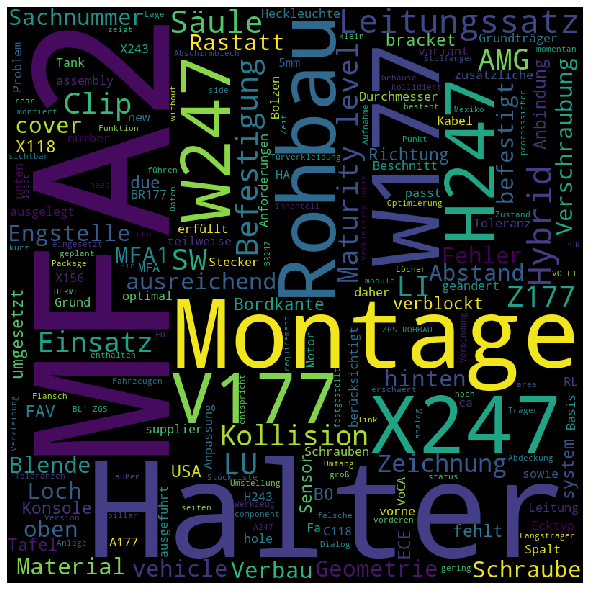

In [894]:
ist_all = ''
for index, row in input_df_final_clean.iterrows():
    ist_all = ist_all + ',' + row['new_IST']
plot_word_cloud(ist_all)

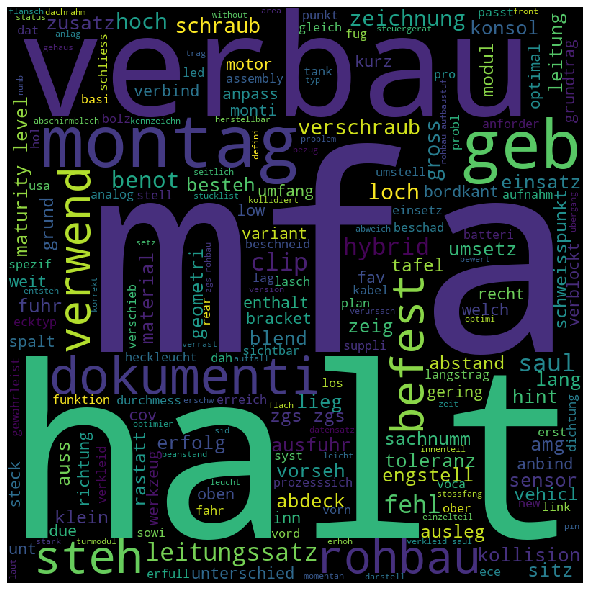

In [895]:
# with preprocessing
ist_all = ''
for index, row in input_df_final_clean.iterrows():
    ist_all = ist_all + ',' + clean_text(row['new_IST'])
plot_word_cloud(ist_all)

### Statistics of Data Source

In [896]:
copy_df_kg = pd.DataFrame()
copy_df_kg['KG'] = input_df_final_clean['KG'].copy()
copy_df_kg['KG_count'] = copy_df_kg['KG'].apply(lambda x: len(str(x).split(";")))
tmp_buendel_kg_count = pd.DataFrame(copy_df_kg.groupby('KG_count').size())
tmp_buendel_kg_count

0
KG_count       
1         10921
2          1580
3           262
4            65
5            19
6             3
7             3
8             2
12            1

In [897]:
copy_df_kg['KG_count'].mean()

1.189250155569384

In [898]:
copy_df_mk = pd.DataFrame()
copy_df_mk['MK'] = input_df_final_clean['MK_BENENNUNG'].copy()
copy_df_mk['MK_count'] = copy_df_mk['MK'].apply(lambda x: len(str(x).split(";")))
tmp_buendel_mk_count = pd.DataFrame(copy_df_mk.groupby('MK_count').size())
tmp_buendel_mk_count

0
MK_count       
1         10882
2          1527
3           331
4            90
5            17
6             3
7             2
8             1
10            2
15            1

In [899]:
copy_df_mk['MK_count'].mean()

1.201695706285003

In [900]:
copy_df_msk = pd.DataFrame()
copy_df_msk['MSK'] = input_df_final_clean['MSK'].copy()
copy_df_msk['MSK_count'] = copy_df_msk['MSK'].apply(lambda x: len(str(x).split(";")))
tmp_buendel_msk_count = pd.DataFrame(copy_df_msk.groupby('MSK_count').size())
tmp_buendel_msk_count

0
MSK_count       
1          10154
2           1948
3            506
4            160
5             39
6             28
7              7
8              7
9              1
10             2
11             3
22             1

In [901]:
copy_df_msk['MSK_count'].mean()

1.3036714374611076

In [902]:
copy_df_mk_kg = pd.DataFrame()
copy_df_mk_kg['MK_KG'] = input_df_final_clean['MK_KG'].copy()
copy_df_mk_kg['MK_KG_count'] = copy_df_mk_kg['MK_KG'].apply(lambda x: len(str(x).split(";")))

In [903]:
tmp_buendel_mk_kg_count = pd.DataFrame()
tmp_buendel_mk_kg_count['ECR_count']= copy_df_mk_kg.groupby('MK_KG_count').size()
tmp_buendel_mk_kg_count

ECR_count
MK_KG_count           
2                10209
3                 1265
4                  925
5                  195
6                  140
7                   59
8                   34
9                   10
10                   9
11                   2
13                   4
14                   1
15                   2
27                   1

In [904]:
copy_df_mk_kg['MK_KG_count'].mean()

2.390945861854387

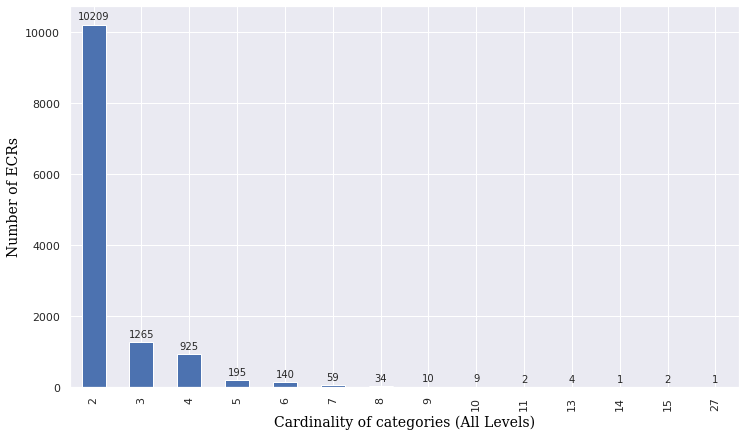

In [905]:
# plot the distribution of KG among Bündles (when Bundle's istzustand is not NULL)
plt.figure(figsize=(12,7))

ax = tmp_buendel_mk_kg_count['ECR_count'].plot(kind='bar')

rects = ax.patches

for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 3
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    #label = "{:.1f}".format(y_value)
    label=y_value

    # Create annotation
    plt.annotate(                     # Use `label` as label
        label,
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }


plt.xlabel("Cardinality of categories (All Levels)",fontdict=font)
plt.ylabel("Number of ECRs",fontdict=font)

plt.show()

In [906]:
df_buendel_linked.groupby(['VERANTWORTLICHER_FK'])['SACHNUMMER'].nunique().sort_values(ascending=False).head(10)

VERANTWORTLICHER_FK
KOGELEF    2162
KRAUART    1506
ACHINNU    1151
EISENBM    1112
MSCHNE2    1036
WEBEMA3     935
THJURDZ     886
JOSPICH     846
JBEGINS     816
PETEMI1     813
Name: SACHNUMMER, dtype: int64

In [907]:
df_buendel_linked.groupby('VERANTWORTLICHER_FK')['SACHNUMMER'].nunique().sort_values(ascending=False).mean()

53.23857868020305

In [908]:
df_buendel_linked.groupby(['BUENDEL_NUMMER'])['ZB_BENENNUNG'].nunique()

BUENDEL_NUMMER
0002036-001     5
0002083-001     3
0002254-001     5
0002316-001     1
0002405-001     4
               ..
0082370-001     1
0082574-001    11
0082976-001     1
0083177-001     1
0083496-001     1
Name: ZB_BENENNUNG, Length: 12940, dtype: int64

In [909]:
df_buendel_linked.groupby(['BUENDEL_NUMMER'])['SACHNUMMER'].nunique()

BUENDEL_NUMMER
0002036-001     5
0002083-001     6
0002254-001    13
0002316-001     1
0002405-001    12
               ..
0082370-001     1
0082574-001    41
0082976-001     1
0083177-001     1
0083496-001     1
Name: SACHNUMMER, Length: 12940, dtype: int64

In [910]:
input_df_final_clean.nunique()

BUENDEL_NUMMER                        12856
CREATION_DATE                          1336
RUECKMELDE_DATUM                       1331
MODIFICATION_DATE                     12856
STATUS                                    2
BENENNUNG                              8751
STICHWORT                              9533
VERURSACHER                              29
new_IST                               10780
new_SOLL                              11363
GEWUENSCHTER_EINSATZ                     42
KOSTEN_RELEVANT                           3
ZERTIFIZIERUNGS_RELEVANT                  3
PROZESS_STATUS                            1
VERANTWORTLICHER_FK                    1182
GREMIUM_ENTSCHEIDUNG_MANUELL             51
STATUS_GENEHMIGUNG                        2
RUECKSPRUNG_KOMMENTAR                  1808
KOSTENBEWERTUNGS_ART                      3
BEGR_RUECKSPRUNG                        566
Bnd_MK                                  101
Bnd_MK_BENENNUNG                        101
WERKSKENNBUCHSTABE              

In [911]:
index_empty_zerti = input_df_final_clean.loc[input_df_final_clean['ZERTIFIZIERUNGS_RELEVANT']=='EMPTY'].index.tolist()
index_empty_zerti

[29757, 48673]

In [912]:
input_df_final_clean.drop(index_empty_zerti,inplace=True)

/home/yuwepan/.local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Analyzing influencing factors

In [913]:
input_df_final_clean.columns

Index(['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'BRAA',
       'ANZAHL_PAKET', 'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG', 'DAUER', 'DAUER_KAT',
       'TypZahl', 'MK_BENENNUNG', 'MSK', 'Bnd_KAT', 'KG', 'KGU', 'cleaned_IST',
       'cleaned_SOLL', 'cleaned_Stichwort', 'cleaned_Benennung',
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH',
       'EE_STEUERGERAET_BE

In [914]:
df_bnd_ab_abgeschlossen_dauer.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'KAT', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'MK', 'MK_BENENNUNG', 'ProduktKlasse', 'BR', 'AA', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'ANZAHL_PAKET',
       'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 'BRAA',
       'DAUER', 'DAUER_KAT'],
      dtype='object')

In [915]:
df_bnd_ab_abgeschlossen_dauer[['BUENDEL_NUMMER','BR','AA','BRAA']]

BUENDEL_NUMMER    BR  AA  \
39       0031257-002  C177  FZ   
40       0031257-002  C177  FV   
41       0031257-002  C177  FW   
42       0031257-002  C247  FW   
43       0031257-002  C247  FH   
...              ...   ...  ..   
95448    0012951-002  C092  FV   
95449    0013933-003  C092  FH   
95450    0013933-003  C092  FV   
95451    0020340-001  C092  FH   
95452    0020340-001  C092  FV   

                                                    BRAA  
39     C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
40     C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
41     C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
42     C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
43     C177/FZ;C177/FV;C177/FW;C247/FW;C247/FH;C247/F...  
...                                                  ...  
95448                                    C092/FH;C092/FV  
95449                                    C092/FH;C092/FV  
95450                                    C092/FH;C092/FV  
95451                                    C092/FH;C092/FV  
95452                                    C092/FH;C092/FV  

[56181 rows x 4 columns]

In [916]:
df_bnd_ab_abgeschlossen_dauer['BR'].unique()

array(['C177', 'C247', 'C243', 'C118', 'C169', 'C117', 'C246', 'C242',
       'C091', 'C093', 'C092'], dtype=object)

In [917]:
df_bnd_ab_abgeschlossen_dauer[['BUENDEL_NUMMER','ZERTIFIZIERUNGS_RELEVANT','WERK_Ctime','LIEFERANTEN_NUMMER','DAUER']].head(10)

BUENDEL_NUMMER ZERTIFIZIERUNGS_RELEVANT  \
39    0031257-002                     NEIN   
40    0031257-002                     NEIN   
41    0031257-002                     NEIN   
42    0031257-002                     NEIN   
43    0031257-002                     NEIN   
44    0031257-002                     NEIN   
45    0031257-002                     NEIN   
46    0031257-002                     NEIN   
47    0031257-002                     NEIN   
48    0031257-002                     NEIN   

                                      WERK_Ctime  \
39  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   
40  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   
41  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   
42  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   
43  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   
44  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   
45  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   
46  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   
47  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   
48  None;0650;0540;3710;TRMX;TRNS;5660;4831;0370   

                                   LIEFERANTEN_NUMMER   DAUER  
39  None;10900017;15449788;15303480;15661038;18559... 36 days  
40  None;10900017;15449788;15303480;15661038;18559... 36 days  
41  None;10900017;15449788;15303480;15661038;18559... 36 days  
42  None;10900017;15449788;15303480;15661038;18559... 36 days  
43  None;10900017;15449788;15303480;15661038;18559... 36 days  
44  None;10900017;15449788;15303480;15661038;18559... 36 days  
45  None;10900017;15449788;15303480;15661038;18559... 36 days  
46  None;10900017;15449788;15303480;15661038;18559... 36 days  
47  None;10900017;15449788;15303480;15661038;18559... 36 days  
48  None;10900017;15449788;15303480;15661038;18559... 36 days

In [918]:
input_df_final_clean.columns

Index(['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'BRAA',
       'ANZAHL_PAKET', 'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG', 'DAUER', 'DAUER_KAT',
       'TypZahl', 'MK_BENENNUNG', 'MSK', 'Bnd_KAT', 'KG', 'KGU', 'cleaned_IST',
       'cleaned_SOLL', 'cleaned_Stichwort', 'cleaned_Benennung',
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH',
       'EE_STEUERGERAET_BE

In [919]:
input_df_final_clean[['BUENDEL_NUMMER','ZERTIFIZIERUNGS_RELEVANT','SICHERHEITSRELEVANT','ANZAHL_SACHNUMMER','DAUER']]

BUENDEL_NUMMER ZERTIFIZIERUNGS_RELEVANT SICHERHEITSRELEVANT  \
0        0031257-002                     NEIN                NEIN   
10       0042927-003                     NEIN                NEIN   
28       0047807-001                       JA                  JA   
38       0040804-001                       JA                  JA   
48       0027988-001                       JA                NEIN   
...              ...                      ...                 ...   
50227    0007414-002                     NEIN                NEIN   
50229    0009914-016                       JA                  JA   
50231    0012951-002                       JA                  JA   
50233    0013933-003                       JA                  JA   
50235    0020340-001                       JA                  JA   

       ANZAHL_SACHNUMMER   DAUER  
0                     14 36 days  
10                     2 83 days  
28                     1 45 days  
38                     5 66 days  
48                     4 42 days  
...                  ...     ...  
50227                  1 83 days  
50229                  2 56 days  
50231                  2 38 days  
50233                  1 93 days  
50235                  2 34 days  

[12854 rows x 5 columns]

In [920]:
df_bnd_ab_abgeschlossen_dauer['BUENDEL_NUMMER'].nunique()

14584

In [921]:
input_df_final_clean['DAUER_KAT'].unique()

array(['Shorter', 'Longer'], dtype=object)

In [922]:
#29%
df_bnd_ab_abgeschlossen_dauer.loc[df_bnd_ab_abgeschlossen_dauer['DAUER']>'41 days 19:18:43.751891']['BUENDEL_NUMMER'].nunique()

7331

In [923]:
df_bnd_ab_abgeschlossen_dauer.loc[df_bnd_ab_abgeschlossen_dauer['DAUER']<='41 days 19:18:43.751891']['BUENDEL_NUMMER'].nunique()

7253

In [924]:
df_bnd_ab_abgeschlossen_dauer.loc[(df_bnd_ab_abgeschlossen_dauer['DAUER']<'41 days 19:18:43.751891')
                        & (df_bnd_ab_abgeschlossen_dauer['ANZAHL_WERK_Ctime']!=0)]['ANZAHL_WERK_Ctime'].describe()

count    21420.000000
mean         5.544678
std          3.606220
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         32.000000
Name: ANZAHL_WERK_Ctime, dtype: float64

In [925]:
#input_df_final_clean['DAUER'].describe()

In [926]:
input_df_final_clean.loc[input_df_final_clean['new_IST'].str.contains('Das Abschirmblech hat im hinteren Bereich eine kleine Kollision mit dem Tankspannband und eine Engstelle zur AGA')]['ANZAHL_EXT']

3972    1.0
Name: ANZAHL_EXT, dtype: float64

### 1. ANZAHL_SACHNUMMER

In [927]:
input_df_final_clean['BUENDEL_NUMMER'].nunique()

12854

In [928]:
input_df_final_clean.loc[input_df_final_clean['DAUER']>'41 days 19:18:43.751891']['BUENDEL_NUMMER'].nunique()

6579

In [929]:
input_df_final_clean.loc[input_df_final_clean['DAUER']<='41 days 19:18:43.751891']['BUENDEL_NUMMER'].nunique()

6275

In [930]:
input_df_final_clean['DAUER'].describe()

count                      12854
mean     60 days 16:16:39.284269
std      59 days 00:41:22.049421
min              0 days 00:00:00
25%             33 days 00:00:00
50%             42 days 00:00:00
75%             66 days 00:00:00
max            685 days 00:00:00
Name: DAUER, dtype: object

In [931]:
input_df_final_clean['ANZAHL_SACHNUMMER'].mean()

8.863777812354131

In [932]:
input_df_final_clean.loc[input_df_final_clean['DAUER']>'41 days 19:18:43.751891']['ANZAHL_SACHNUMMER'].mean()

9.331965344277245

In [933]:
input_df_final_clean.loc[input_df_final_clean['DAUER']<='41 days 19:18:43.751891']['ANZAHL_SACHNUMMER'].mean()

8.372908366533865

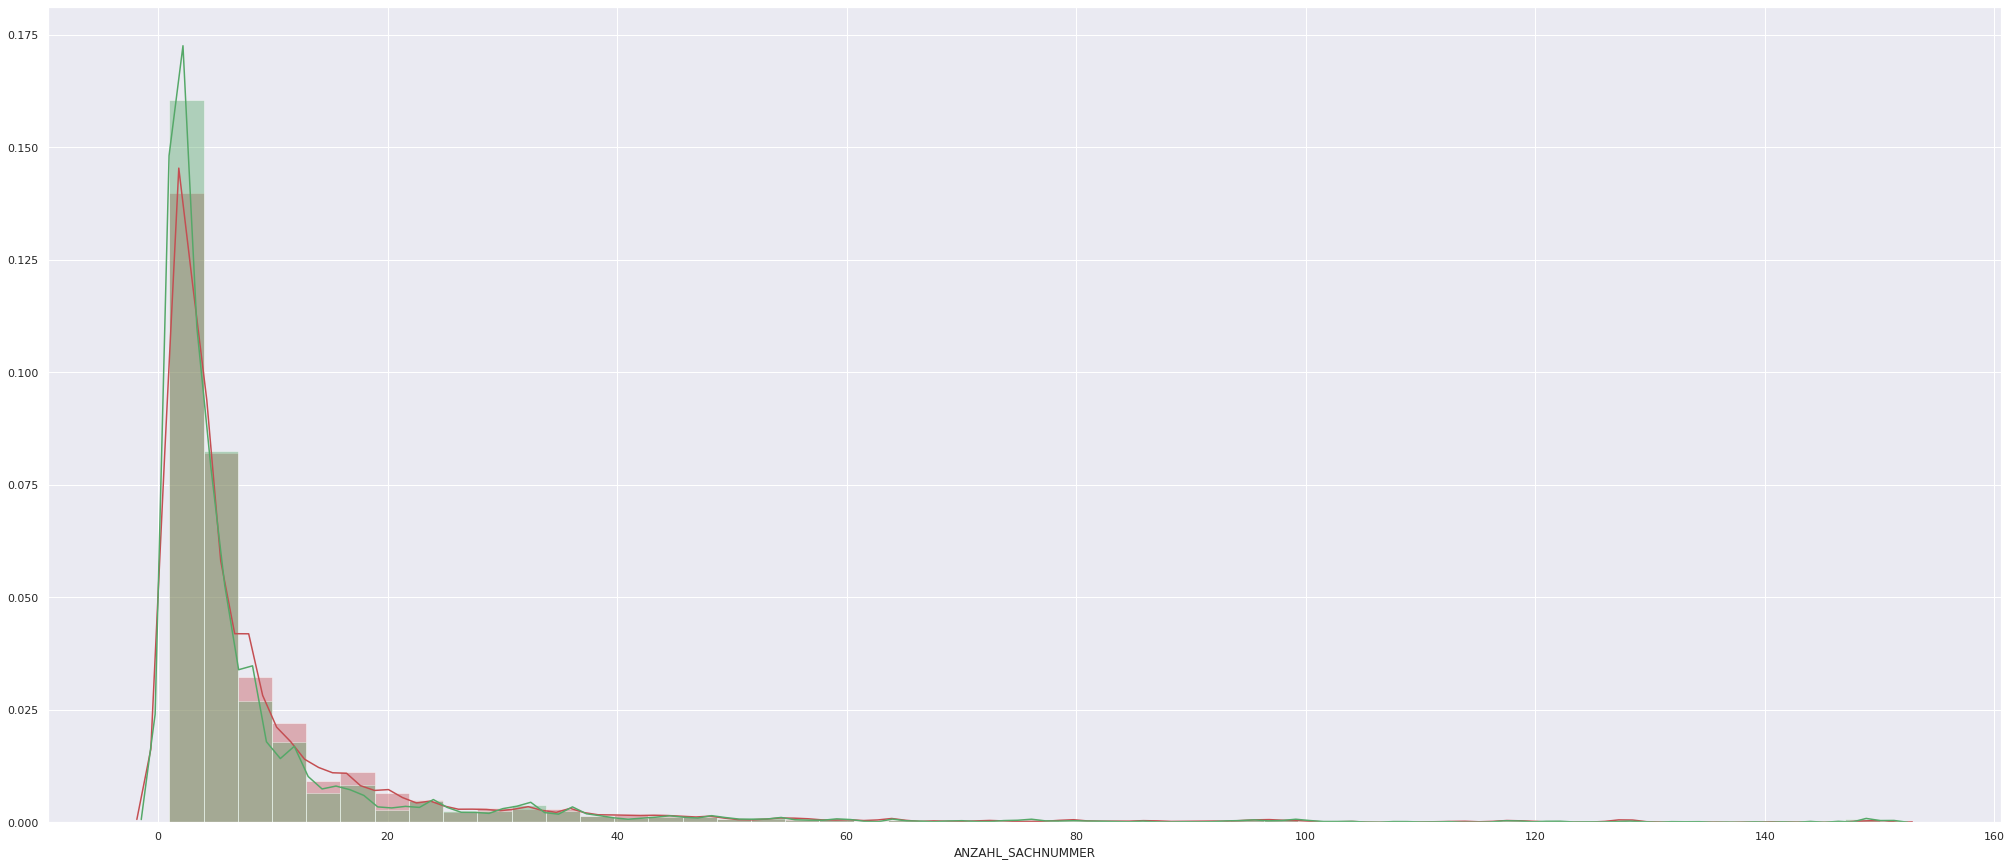

In [934]:
fig = plt.figure(figsize = (35, 15))
sns.distplot(input_df_final_clean['ANZAHL_SACHNUMMER'][input_df_final_clean['DAUER_KAT']=='Longer'],color='r', label = 'longer')
sns.distplot(input_df_final_clean['ANZAHL_SACHNUMMER'][input_df_final_clean['DAUER_KAT']=='Shorter'],color='g', label = 'shorter')

### 2. ANZAHL_PAKET

In [935]:
input_df_final_clean['ANZAHL_PAKET'].describe()

count    12854.000000
mean         4.418391
std          5.711971
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        185.000000
Name: ANZAHL_PAKET, dtype: float64

In [936]:
input_df_final_clean.loc[input_df_final_clean['DAUER']>'41 days 19:18:43.751891']['ANZAHL_PAKET'].mean()

4.811977504179967

In [937]:
input_df_final_clean.loc[input_df_final_clean['DAUER']<='41 days 19:18:43.751891']['ANZAHL_PAKET'].mean()

4.005737051792829

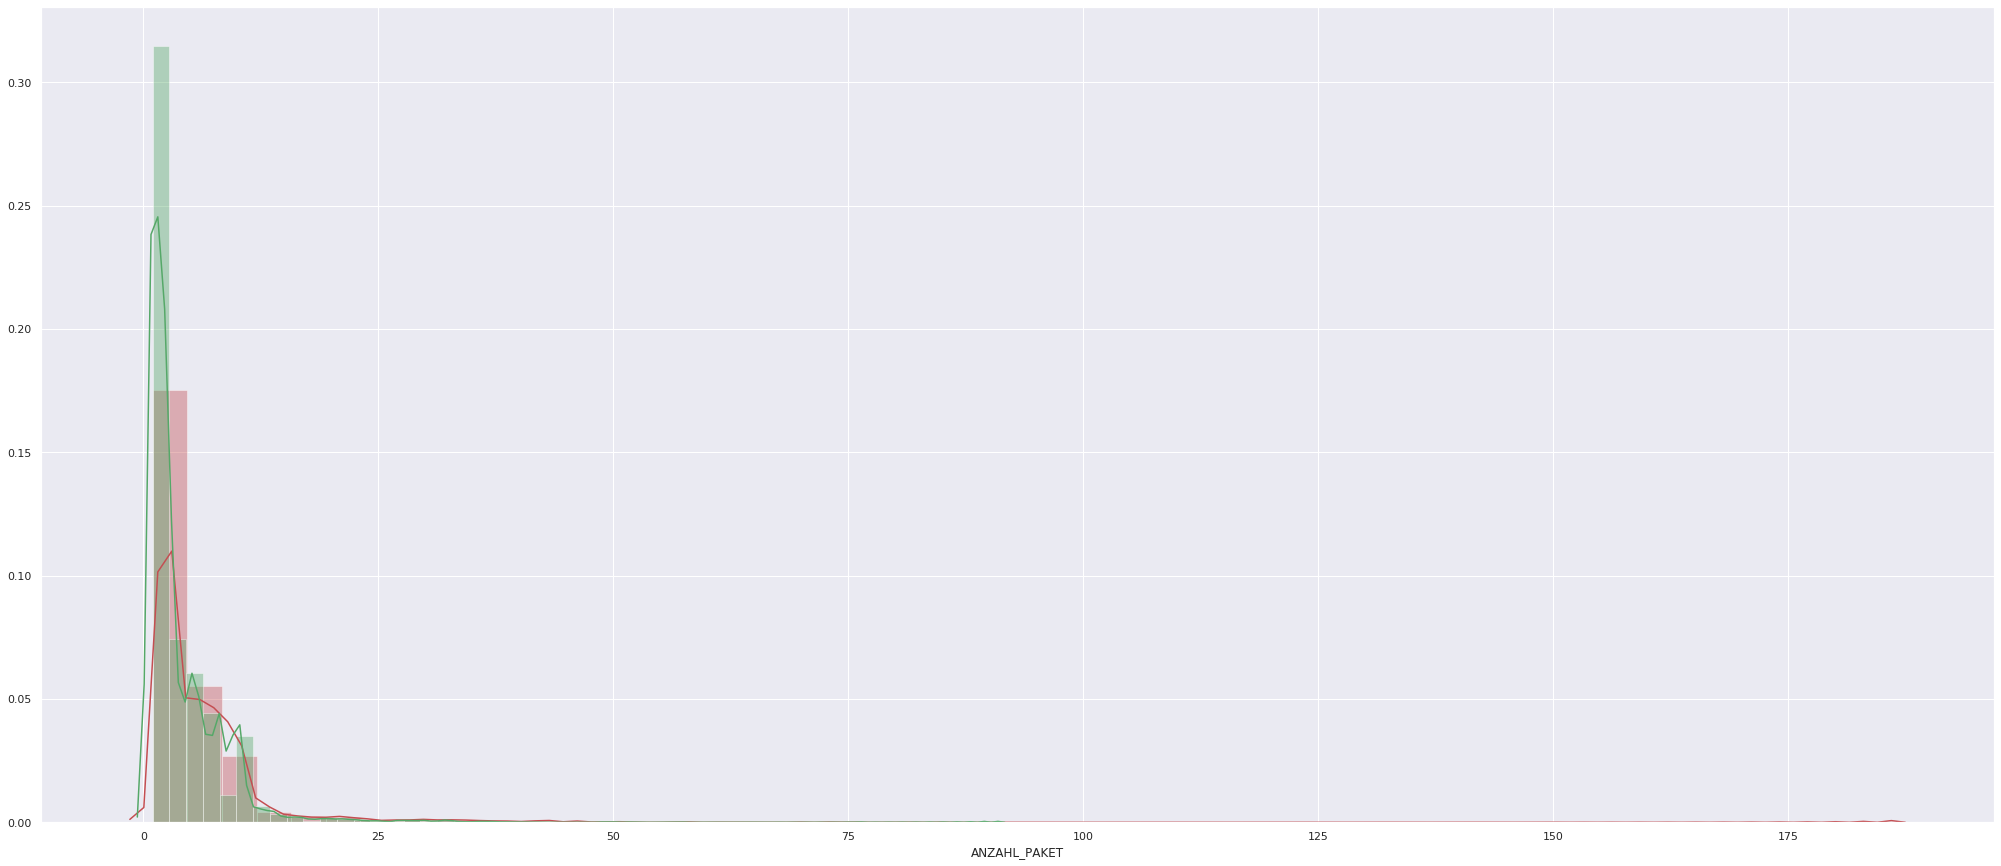

In [938]:
fig = plt.figure(figsize = (35, 15))
sns.distplot(input_df_final_clean['ANZAHL_PAKET'][input_df_final_clean['DAUER_KAT']=='Longer'],color='r', label = 'longer')
sns.distplot(input_df_final_clean['ANZAHL_PAKET'][input_df_final_clean['DAUER_KAT']=='Shorter'],color='g', label = 'shorter')

In [939]:
input_df_final_clean.loc[input_df_final_clean['BRAA']==None]

Empty DataFrame
Columns: [BUENDEL_NUMMER, CREATION_DATE, RUECKMELDE_DATUM, MODIFICATION_DATE, STATUS, BENENNUNG, STICHWORT, VERURSACHER, new_IST, new_SOLL, GEWUENSCHTER_EINSATZ, KOSTEN_RELEVANT, ZERTIFIZIERUNGS_RELEVANT, PROZESS_STATUS, VERANTWORTLICHER_FK, GREMIUM_ENTSCHEIDUNG_MANUELL, STATUS_GENEHMIGUNG, RUECKSPRUNG_KOMMENTAR, KOSTENBEWERTUNGS_ART, BEGR_RUECKSPRUNG, Bnd_MK, Bnd_MK_BENENNUNG, WERKSKENNBUCHSTABE, LIEFERANTEN_NUMMER, LIEFERANTEN_NAME, WERK_Ctime, BRAA, ANZAHL_PAKET, ANZAHL_WERK, ANZAHL_EXT, ANZAHL_WERK_Ctime, ANZAHL_SACHNUMMER, ANZAHL_ZB_BENENNUNG, DAUER, DAUER_KAT, TypZahl, MK_BENENNUNG, MSK, Bnd_KAT, KG, KGU, cleaned_IST, cleaned_SOLL, cleaned_Stichwort, cleaned_Benennung, EMISSIONSKENNZEICHEN, BESCHAFFUNGSART, SICHERHEITSRELEVANT, TEILEART, WERKZEUGAENDERUNG_ERFORDERLICH, EE_STEUERGERAET_BETROFFEN, BETRIEBSANLEITUNG_BETROFFEN, LEITUNGSSATZ_BETROFFEN, LASTENHEFTAENDERUNG_ERFORDERLICH, VERSUCHSTEIL_ASACHNUMMER_BETROFFEN, MK_KG]
Index: []

[0 rows x 56 columns]

In [940]:
#  Amount distribution of all external partners
value_count_braa = input_df_final_clean.BRAA.str.split(expand=True,pat=';').stack().value_counts()

In [941]:
value_count_braa

C177/FW    5010
C118/FC    4711
C177/FV    4689
C118/FX    4637
C247/FH    4461
C247/FW    4394
C247/FX    4242
C177/FZ    3886
C243/FX    2374
C243/FH    2274
C246/FX     940
C117/FC     739
C117/FX     728
C246/FS     675
C246/FT     605
C092/FV     520
C092/FH     516
C242/FN     391
C091/FX     333
C169/FT      30
C169/FC      26
C169/FW      24
C093/FC      13
C246/FC       1
C246/FN       1
dtype: int64

In [942]:
# Distribution of BRAA in shorter ECs
value_count_braa_shorter = input_df_final_clean.loc[(input_df_final_clean['DAUER']<='41 days 19:18:43.751891')].BRAA.str.split(expand=True,pat=';').stack().value_counts()
value_count_braa_shorter

C177/FW    2433
C118/FC    2345
C118/FX    2288
C177/FV    2198
C247/FH    2127
C247/FW    2062
C247/FX    2006
C177/FZ    1680
C243/FX    1134
C243/FH    1077
C246/FX     373
C117/FC     296
C117/FX     292
C246/FS     273
C092/FV     248
C092/FH     240
C246/FT     224
C242/FN     143
C091/FX     112
C169/FT       9
C169/FC       7
C169/FW       6
C093/FC       4
C246/FN       1
C246/FC       1
dtype: int64

In [943]:
# Distribution of BRAA in shorter ECs
value_count_braa_longer = input_df_final_clean.loc[(input_df_final_clean['DAUER']>'41 days 19:18:43.751891')].BRAA.str.split(expand=True,pat=';').stack().value_counts()
value_count_braa_longer

C177/FW    2577
C177/FV    2491
C118/FC    2366
C118/FX    2349
C247/FH    2334
C247/FW    2332
C247/FX    2236
C177/FZ    2206
C243/FX    1240
C243/FH    1197
C246/FX     567
C117/FC     443
C117/FX     436
C246/FS     402
C246/FT     381
C092/FH     276
C092/FV     272
C242/FN     248
C091/FX     221
C169/FT      21
C169/FC      19
C169/FW      18
C093/FC       9
dtype: int64

In [944]:
df_value_count_braa_shorter = value_count_braa_shorter.to_frame(name='ECR_count')
df_value_count_braa_longer = value_count_braa_longer.to_frame(name='ECR_count')

In [945]:
df_value_count_braa = pd.concat([df_value_count_braa_shorter, df_value_count_braa_longer], axis=1)
df_value_count_braa.columns = ['Shorter','Longer']
df_value_count_braa['Shorter'] = df_value_count_braa['Shorter'].fillna(0)
df_value_count_braa['Longer'] = df_value_count_braa['Longer'].fillna(0)
df_value_count_braa

Shorter  Longer
C177/FW     2433  2577.0
C118/FC     2345  2366.0
C118/FX     2288  2349.0
C177/FV     2198  2491.0
C247/FH     2127  2334.0
C247/FW     2062  2332.0
C247/FX     2006  2236.0
C177/FZ     1680  2206.0
C243/FX     1134  1240.0
C243/FH     1077  1197.0
C246/FX      373   567.0
C117/FC      296   443.0
C117/FX      292   436.0
C246/FS      273   402.0
C092/FV      248   272.0
C092/FH      240   276.0
C246/FT      224   381.0
C242/FN      143   248.0
C091/FX      112   221.0
C169/FT        9    21.0
C169/FC        7    19.0
C169/FW        6    18.0
C093/FC        4     9.0
C246/FN        1     0.0
C246/FC        1     0.0

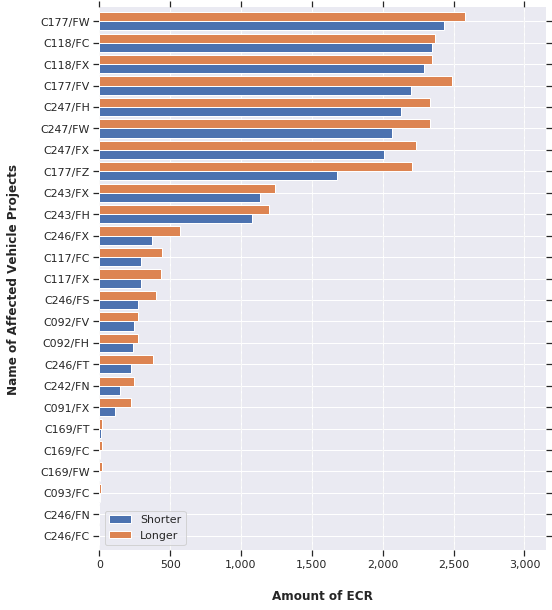

In [946]:
from matplotlib.ticker import StrMethodFormatter
#df_value_count_ext_longer.head(20).sort_values('ECR_count').plot(kind='barh')

#ax = df_value_count_ext_longer.head(20).sort_values('ECR_count').plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)
#df_value_count_ext_shorter.head(20).sort_values('ECR_count').plot(ax=ax, kind='barh',color='b',zorder=2,width=0.85)

#ax = df_value_count_ext.head(20).plot.barh()
ax = df_value_count_braa.sort_values('Shorter').plot(kind='barh', figsize=(8, 10), zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Amount of ECR", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Name of Affected Vehicle Projects", labelpad=20, weight='bold', size=12)

# Format y-axis label
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

### 3. ANZAHL_WERK

In [947]:
input_df_final_clean['ANZAHL_WERK'] = input_df_final_clean['ANZAHL_WERK'].fillna(0)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


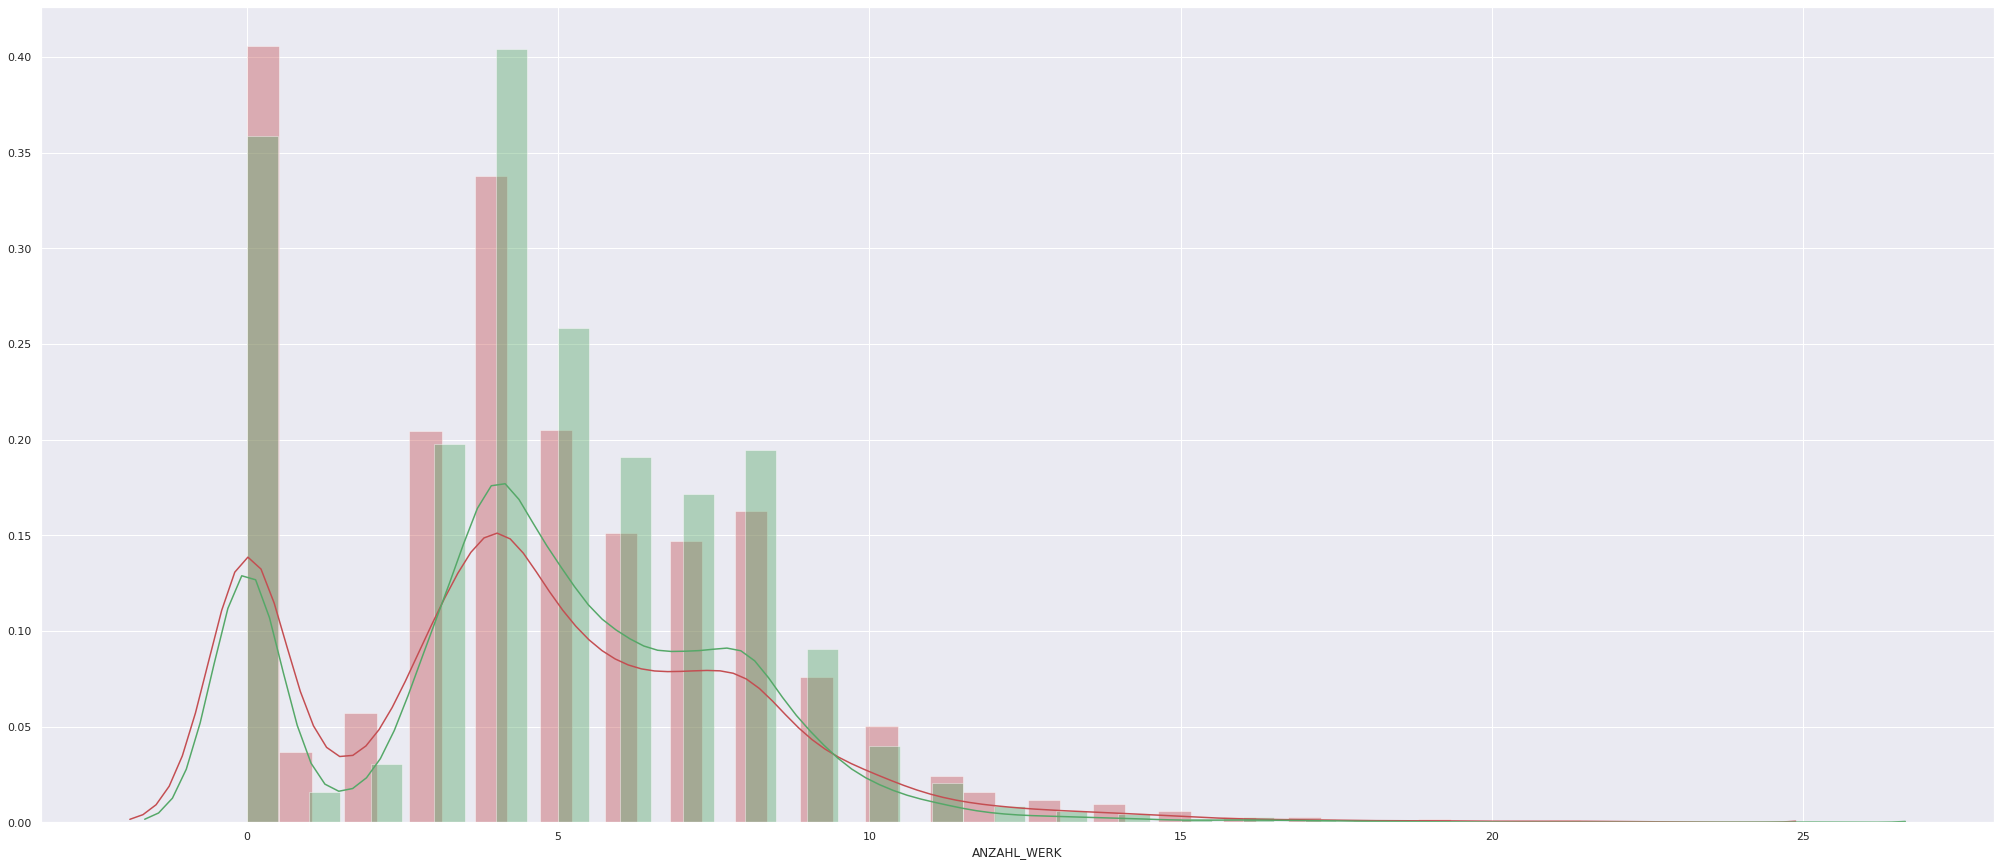

In [948]:
fig = plt.figure(figsize = (35, 15))
sns.distplot(input_df_final_clean['ANZAHL_WERK'][input_df_final_clean['DAUER_KAT']=='Longer'],color='r', label = 'longer')
sns.distplot(input_df_final_clean['ANZAHL_WERK'][input_df_final_clean['DAUER_KAT']=='Shorter'],color='g', label = 'shorter')

In [949]:
#df_bnd_ab_abgeschlossen_dauer['ANZAHL_WERK'] = df_bnd_ab_abgeschlossen_dauer['ANZAHL_WERK'].fillna(0)
input_df_final_clean['ANZAHL_WERK'].mean()

4.5733623774700485

In [950]:
input_df_final_clean.loc[(input_df_final_clean['ANZAHL_WERK']!=0)]['ANZAHL_WERK'].describe()

count    10332.000000
mean         5.689702
std          2.606054
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         25.000000
Name: ANZAHL_WERK, dtype: float64

In [951]:
input_df_final_clean.loc[(input_df_final_clean['DAUER']>'41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_WERK']!=0)]['ANZAHL_WERK'].describe()

count    5183.000000
mean        5.713293
std         2.828562
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        23.000000
Name: ANZAHL_WERK, dtype: float64

In [952]:
input_df_final_clean.loc[(input_df_final_clean['DAUER']<='41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_WERK']!=0)]['ANZAHL_WERK'].describe()

count    5149.000000
mean        5.665955
std         2.361034
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        25.000000
Name: ANZAHL_WERK, dtype: float64

In [953]:
#  Amount distribution of all Werks
value_count_werk_shorter = input_df_final_clean.loc[(input_df_final_clean['DAUER']<='41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_WERK']!=0)].WERKSKENNBUCHSTABE.str.split(expand=True,pat=';').stack().value_counts()

In [954]:
#  Amount distribution of all Werks
value_count_werk_longer = input_df_final_clean.loc[(input_df_final_clean['DAUER']>'41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_WERK']!=0)].WERKSKENNBUCHSTABE.str.split(expand=True,pat=';').stack().value_counts()

In [955]:
df_value_count_werk_shorter = value_count_werk_shorter.to_frame(name='ECR_count')
df_value_count_werk_longer = value_count_werk_longer.to_frame(name='ECR_count')

In [956]:
df_value_count_werk = pd.concat([df_value_count_werk_shorter, df_value_count_werk_longer], axis=1)
df_value_count_werk.columns = ['Shorter','Longer']
df_value_count_werk['Shorter'] = df_value_count_werk['Shorter'].fillna(0)
df_value_count_werk['Longer'] = df_value_count_werk['Longer'].fillna(0)
df_value_count_werk

Shorter  Longer
Z    5040.0  5015.0
WA   4744.0  4642.0
I    3341.0  3251.0
XQ   3174.0  3145.0
EG   2821.0  2700.0
FL   2745.0  2797.0
WO   2437.0  2465.0
WW   1522.0  1492.0
EH   1051.0   850.0
XC    561.0   650.0
B     249.0   383.0
XP    187.0   183.0
D     180.0   191.0
UA    158.0   298.0
FY    122.0   100.0
N     114.0   246.0
A      95.0   124.0
ZV     91.0   122.0
XB     75.0   140.0
ZM     71.0    83.0
AX     58.0   155.0
G      44.0    63.0
K      35.0    41.0
W      35.0    47.0
F      30.0    30.0
UC     29.0    29.0
L      28.0    52.0
WY     19.0    37.0
DP     18.0    18.0
O      16.0    53.0
R      15.0    42.0
V      15.0    37.0
XE     10.0     3.0
WR      8.0    36.0
FW      5.0     1.0
C       4.0    10.0
H       3.0     9.0
CM      3.0     7.0
SB      2.0     3.0
XT      2.0     4.0
VW      2.0     0.0
XA      2.0    13.0
FU      2.0    12.0
EI      2.0     3.0
P       1.0     2.0
DE      1.0     7.0
E       1.0     2.0
XM      1.0     1.0
WI      1.0     1.0
WD      1.0     3.0
U       1.0     3.0
XR      1.0     1.0
WL      1.0     2.0
ED      0.0     4.0
X       0.0     2.0
XG      0.0     1.0
DT      0.0     1.0

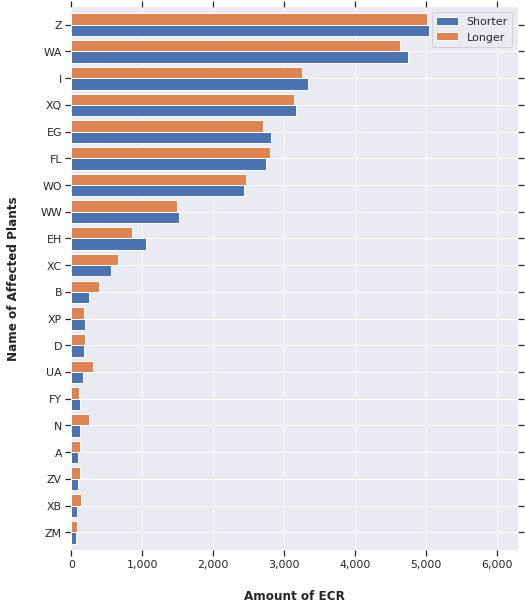

In [957]:
from matplotlib.ticker import StrMethodFormatter
#df_value_count_ext_longer.head(20).sort_values('ECR_count').plot(kind='barh')

#ax = df_value_count_ext_longer.head(20).sort_values('ECR_count').plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)
#df_value_count_ext_shorter.head(20).sort_values('ECR_count').plot(ax=ax, kind='barh',color='b',zorder=2,width=0.85)

#ax = df_value_count_ext.head(20).plot.barh()
ax = df_value_count_werk.head(20).sort_values('Shorter').plot(kind='barh', figsize=(8, 10), zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Amount of ECR", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Name of Affected Plants", labelpad=20, weight='bold', size=12)

# Format y-axis label
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

### 4. ANZAHL_EXT

In [958]:
input_df_final_clean.loc[(input_df_final_clean['ANZAHL_EXT']!=0)]['ANZAHL_EXT'].describe()

count    10587.000000
mean         1.811184
std          1.446102
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         32.000000
Name: ANZAHL_EXT, dtype: float64

In [959]:
input_df_final_clean.loc[(input_df_final_clean['DAUER']>'41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_EXT']!=0)]['ANZAHL_EXT'].describe()

count    5337.000000
mean        1.958216
std         1.645816
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        32.000000
Name: ANZAHL_EXT, dtype: float64

In [960]:
input_df_final_clean.loc[(input_df_final_clean['DAUER']<='41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_EXT']!=0)]['ANZAHL_EXT'].describe()

count    5250.000000
mean        1.661714
std         1.191448
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: ANZAHL_EXT, dtype: float64

In [961]:
#  Amount distribution of all external partners
value_count_ext_shorter = input_df_final_clean.loc[(input_df_final_clean['DAUER']<='41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_EXT']!=0)].LIEFERANTEN_NAME.str.split(expand=True,pat=';').stack().value_counts().drop(index='None')

In [962]:
#  Amount distribution of all external partners
value_count_ext_nummer_shorter = input_df_final_clean.loc[(input_df_final_clean['DAUER']<='41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_EXT']!=0)].LIEFERANTEN_NUMMER.str.split(expand=True,pat=';').stack().value_counts().drop(index='None')

In [963]:
value_count_ext_longer = input_df_final_clean.loc[(input_df_final_clean['DAUER']>'41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_EXT']!=0)].LIEFERANTEN_NAME.str.split(expand=True,pat=';').stack().value_counts().drop(index='None')

In [964]:
#  Amount distribution of all external partners
value_count_ext_nummer_longer = input_df_final_clean.loc[(input_df_final_clean['DAUER']>'41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_EXT']!=0)].LIEFERANTEN_NUMMER.str.split(expand=True,pat=';').stack().value_counts().drop(index='None')

In [965]:
df_value_count_ext_longer = value_count_ext_longer.to_frame(name='ECR_count')

In [966]:
df_value_count_ext_nummer_longer = value_count_ext_nummer_longer.to_frame(name='ECR_count')

In [967]:
df_value_count_ext_shorter = value_count_ext_shorter.to_frame(name='ECR_count')

In [968]:
df_value_count_ext_nummer_shorter = value_count_ext_nummer_shorter.to_frame(name='ECR_count')

In [969]:
df_value_count_ext_nummer_shorter

ECR_count
11004660        392
12344180        321
10940211        164
16856239        145
18546754        145
...             ...
15306376          1
15495591          1
12301008          1
15328495          1
15414873          1

[801 rows x 1 columns]

In [970]:
df_value_count_ext_shorter

ECR_count
Aptiv Services Deutschland GmbH                         392
Yazaki Europe Ltd. Zweigniederlassung Köln              321
Adient Interiors Ltd. & Co. KG                          167
HBPO Rastatt GmbH HPC 011 i                             145
International Automotive Components Group s.r.o.        134
...                                                     ...
LES GRAVEURS GRAVUREN GmbH                                1
ZF Automotive Germany GmbH                                1
KNIPPING KUNSTSTOFFTECHNIK Gessmann GmbH                  1
tk Components Technology HU                               1
SaarGummi Americas Plant Pulaski                          1

[824 rows x 1 columns]

In [971]:
df_value_count_ext_longer

ECR_count
Yazaki Europe Ltd. Zweigniederlassung Köln              236
Aptiv Services Deutschland GmbH                         231
International Automotive Components Group s.r.o.        197
Adient Interiors Ltd. & Co. KG                          179
HBPO Rastatt GmbH HPC 011 i                             178
...                                                     ...
Grosshaus Hungaria Kft                                    1
nmc Deutschland GmbH                                      1
Kiekert de Mexico S.A. de C.V.                            1
Veoneer France SAS formerly AUTOLIV ELECTR. SAS           1
FIAMM Energy Technology ( USA ) LLC                       1

[1022 rows x 1 columns]

In [972]:
df_value_count_ext_nummer_longer

ECR_count
12344180        236
11004660        230
16856239        178
10940211        176
18546754        161
...             ...
15637021          1
12597928          1
18527259          1
15646111          1
15414873          1

[987 rows x 1 columns]

In [973]:
df_value_count_ext = pd.concat([df_value_count_ext_shorter, df_value_count_ext_longer], axis=1)
df_value_count_ext.columns = ['Shorter','Longer']
df_value_count_ext['Shorter'] = df_value_count_ext['Shorter'].fillna(0)
df_value_count_ext['Longer'] = df_value_count_ext['Longer'].fillna(0)
df_value_count_ext

Shorter  Longer
Aptiv Services Deutschland GmbH                     392.0   231.0
Yazaki Europe Ltd. Zweigniederlassung Köln          321.0   236.0
Adient Interiors Ltd. & Co. KG                      167.0   179.0
HBPO Rastatt GmbH HPC 011 i                         145.0   178.0
International Automotive Components Group s.r.o.    134.0   197.0
...                                                   ...     ...
WEGMANN automotive GmbH                               0.0     1.0
Hebu GmbH                                             0.0     1.0
MC Syncro Supply GmbH                                 0.0     1.0
nmc Deutschland GmbH                                  0.0     1.0
FIAMM Energy Technology ( USA ) LLC                   0.0     1.0

[1123 rows x 2 columns]

In [974]:
df_value_count_ext_nummer = pd.concat([df_value_count_ext_nummer_shorter, df_value_count_ext_nummer_longer], axis=1)
df_value_count_ext_nummer.columns = ['Shorter','Longer']
df_value_count_ext_nummer['Shorter'] = df_value_count_ext_nummer['Shorter'].fillna(0)
df_value_count_ext_nummer['Longer'] = df_value_count_ext_nummer['Longer'].fillna(0)
df_value_count_ext_nummer

Shorter  Longer
11004660    392.0   230.0
12344180    321.0   236.0
10940211    164.0   176.0
16856239    145.0   178.0
18546754    145.0   161.0
...           ...     ...
15216856      0.0     1.0
13221296      0.0     1.0
15399223      0.0     1.0
15637021      0.0     1.0
15646111      0.0     1.0

[1082 rows x 2 columns]

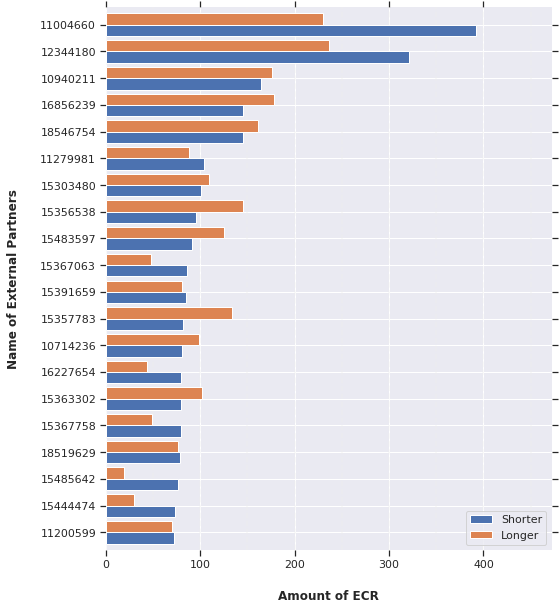

In [975]:
from matplotlib.ticker import StrMethodFormatter
#df_value_count_ext_longer.head(20).sort_values('ECR_count').plot(kind='barh')

#ax = df_value_count_ext_longer.head(20).sort_values('ECR_count').plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)
#df_value_count_ext_shorter.head(20).sort_values('ECR_count').plot(ax=ax, kind='barh',color='b',zorder=2,width=0.85)

#ax = df_value_count_ext.head(20).plot.barh()
ax = df_value_count_ext_nummer.head(20).sort_values('Shorter').plot(kind='barh', figsize=(8, 10), zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Amount of ECR", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Name of External Partners", labelpad=20, weight='bold', size=12)

# Format y-axis label
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [976]:
input_df_final_clean['DAUER']

0       36 days
10      83 days
28      45 days
38      66 days
48      42 days
          ...  
50227   83 days
50229   56 days
50231   38 days
50233   93 days
50235   34 days
Name: DAUER, Length: 12854, dtype: timedelta64[ns]

In [977]:
input_df_final_clean.dtypes

BUENDEL_NUMMER                                 object
CREATION_DATE                                  object
RUECKMELDE_DATUM                               object
MODIFICATION_DATE                      datetime64[ns]
STATUS                                         object
BENENNUNG                                      object
STICHWORT                                      object
VERURSACHER                                    object
new_IST                                        object
new_SOLL                                       object
GEWUENSCHTER_EINSATZ                   datetime64[ns]
KOSTEN_RELEVANT                                object
ZERTIFIZIERUNGS_RELEVANT                       object
PROZESS_STATUS                                 object
VERANTWORTLICHER_FK                            object
GREMIUM_ENTSCHEIDUNG_MANUELL                   object
STATUS_GENEHMIGUNG                             object
RUECKSPRUNG_KOMMENTAR                          object
KOSTENBEWERTUNGS_ART        

In [978]:
input_df_final_clean.loc[(input_df_final_clean['ANZAHL_EXT']!=0)].LIEFERANTEN_NUMMER.str.split(expand=True,pat=';').stack().value_counts().drop(index='None').head(10)

11004660    622
12344180    557
10940211    340
16856239    323
18546754    306
15356538    241
15483597    217
15357783    216
15303480    211
11279981    192
dtype: int64

In [979]:
# Calculate average processing time for each external partners
tmp_df_x = input_df_final_clean.copy()
tmp_df_x['DAUER_Int'] = tmp_df_x['DAUER'].values
#tmp_df_x.groupby('LIEFERANTEN_NUMMER')['DAUER']

In [980]:
tmp_df_x['WERKSKENNBUCHSTABE']

0                         Z;W;K;F;UC
10                             Z;V;R
28          Z;WA;XQ;FL;EG;I;WW;WO;EH
38       Z;WA;UA;XQ;XC;FL;EG;I;WW;WO
48          Z;WA;UA;XQ;FL;EG;I;WW;WO
                    ...             
50227                            NaN
50229                            NaN
50231                            NaN
50233                            NaN
50235                            NaN
Name: WERKSKENNBUCHSTABE, Length: 12854, dtype: object

In [981]:
tmp_df_x.loc[tmp_df_x['LIEFERANTEN_NAME']=='Autoneum Mexico Operations S.A de C.V.']['DAUER_Int'].mean()

Timedelta('57 days 06:32:43.636363')

In [1515]:
tmp_df_x.loc[tmp_df_x['WERKSKENNBUCHSTABE']=='FL']['DAUER_Int'].describe()

count    34                     
mean     74 days 12:42:21.176470
std      49 days 18:11:08.520823
min      18 days 00:00:00       
25%      44 days 00:00:00       
50%      57 days 00:00:00       
75%      87 days 00:00:00       
max      245 days 00:00:00      
Name: DAUER_Int, dtype: object

In [1497]:
tmp_df_x.loc[tmp_df_x['LIEFERANTEN_NUMMER']=='10940211']['BUENDEL_NUMMER'].nunique()

53

### 5. ANZAHL_WERK_Ctime

In [983]:
input_df_final_clean.loc[(input_df_final_clean['ANZAHL_WERK_Ctime']!=0)]['ANZAHL_WERK_Ctime'].describe()

count    10583.000000
mean         4.864783
std          4.472870
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         99.000000
Name: ANZAHL_WERK_Ctime, dtype: float64

In [984]:
input_df_final_clean.loc[(input_df_final_clean['DAUER']>'41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_WERK_Ctime']!=0)]['ANZAHL_WERK_Ctime'].describe()

count    5381.000000
mean        5.282661
std         5.120501
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        99.000000
Name: ANZAHL_WERK_Ctime, dtype: float64

In [985]:
input_df_final_clean.loc[(input_df_final_clean['DAUER']<='41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_WERK_Ctime']!=0)]['ANZAHL_WERK_Ctime'].describe()

count    5202.000000
mean        4.432526
std         3.635392
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        32.000000
Name: ANZAHL_WERK_Ctime, dtype: float64

In [986]:
#  Amount distribution of all external partners
value_count_werkctime = input_df_final_clean.loc[input_df_final_clean['ANZAHL_WERK_Ctime']!=0].WERK_Ctime.str.split(expand=True,pat=';').stack().value_counts().drop(index='None')

In [987]:
value_count_werkctime_shorter = input_df_final_clean.loc[(input_df_final_clean['DAUER']<='41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_WERK_Ctime']!=0)].WERK_Ctime.str.split(expand=True,pat=';').stack().value_counts().drop(index='None')

In [988]:
value_count_werkctime_longer = input_df_final_clean.loc[(input_df_final_clean['DAUER']>'41 days 19:18:43.751891')
                        & (input_df_final_clean['ANZAHL_WERK_Ctime']!=0)].WERK_Ctime.str.split(expand=True,pat=';').stack().value_counts().drop(index='None')

In [989]:
df_value_count_werkctime_longer = value_count_werkctime_longer.to_frame(name='ECR_count')
df_value_count_werkctime_longer

ECR_count
0540       4084
3710       3647
3020       2432
4831       1900
0501       1623
...         ...
3954          1
TRIS          1
9440          1
TRDV          1
1474          1

[117 rows x 1 columns]

In [990]:
df_value_count_werkctime_shorter = value_count_werkctime_shorter.to_frame(name='ECR_count')
df_value_count_werkctime_shorter

ECR_count
0540       3814
3710       3441
3020       2154
4831       1670
0501       1417
...         ...
3010          1
1370          1
TRIS          1
1474          1
1494          1

[89 rows x 1 columns]

In [991]:
df_value_count_werctime = pd.concat([df_value_count_werkctime_shorter, df_value_count_werkctime_longer], axis=1)
df_value_count_werctime.columns = ['Shorter','Longer']
df_value_count_werctime['Shorter'] = df_value_count_werctime['Shorter'].fillna(0)
df_value_count_werctime['Longer'] = df_value_count_werctime['Longer'].fillna(0)
df_value_count_werctime

Shorter  Longer
0540   3814.0  4084.0
3710   3441.0  3647.0
3020   2154.0  2432.0
4831   1670.0  1900.0
0501   1417.0  1623.0
...       ...     ...
0251      0.0     4.0
6930      0.0     3.0
2701      0.0     2.0
3954      0.0     1.0
TRDV      0.0     1.0

[121 rows x 2 columns]

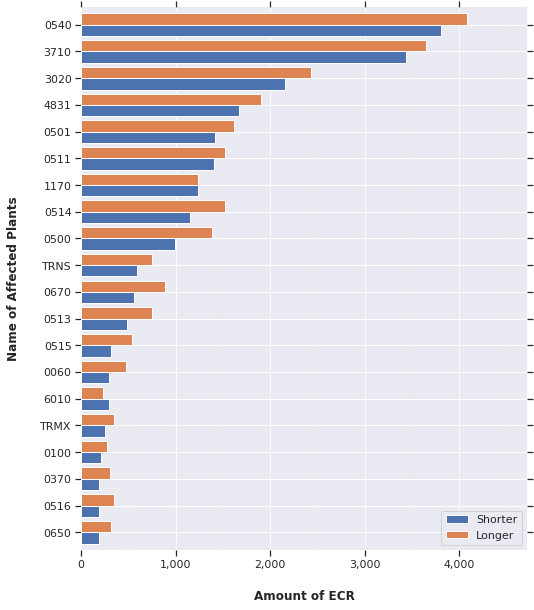

In [992]:
from matplotlib.ticker import StrMethodFormatter

ax = df_value_count_werctime.head(20).sort_values('Shorter').plot(kind='barh', figsize=(8, 10), zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Amount of ECR", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Name of Affected Plants", labelpad=20, weight='bold', size=12)

# Format y-axis label
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

### 6. Teileart

In [993]:
input_df_final_clean.groupby(['TEILEART'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

TEILEART
MO_TEIL                           10437
RB_TEIL                            1949
AGGREGATE_TEIL                      246
MO_TEIL;RB_TEIL                     130
AGGREGATE_TEIL;MO_TEIL               79
AGGREGATE_TEIL;RB_TEIL                8
AGGREGATE_TEIL;MO_TEIL;RB_TEIL        5
Name: BUENDEL_NUMMER, dtype: int64

In [994]:
input_df_final_clean.loc[input_df_final_clean['DAUER']<='41 days 19:18:43.751891'].groupby(
    ['TEILEART'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

TEILEART
MO_TEIL                           5134
RB_TEIL                            939
AGGREGATE_TEIL                     124
MO_TEIL;RB_TEIL                     51
AGGREGATE_TEIL;MO_TEIL              26
AGGREGATE_TEIL;MO_TEIL;RB_TEIL       1
Name: BUENDEL_NUMMER, dtype: int64

In [995]:
input_df_final_clean.loc[input_df_final_clean['DAUER']>'41 days 19:18:43.751891'].groupby(
    ['TEILEART'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

TEILEART
MO_TEIL                           5303
RB_TEIL                           1010
AGGREGATE_TEIL                     122
MO_TEIL;RB_TEIL                     79
AGGREGATE_TEIL;MO_TEIL              53
AGGREGATE_TEIL;RB_TEIL               8
AGGREGATE_TEIL;MO_TEIL;RB_TEIL       4
Name: BUENDEL_NUMMER, dtype: int64

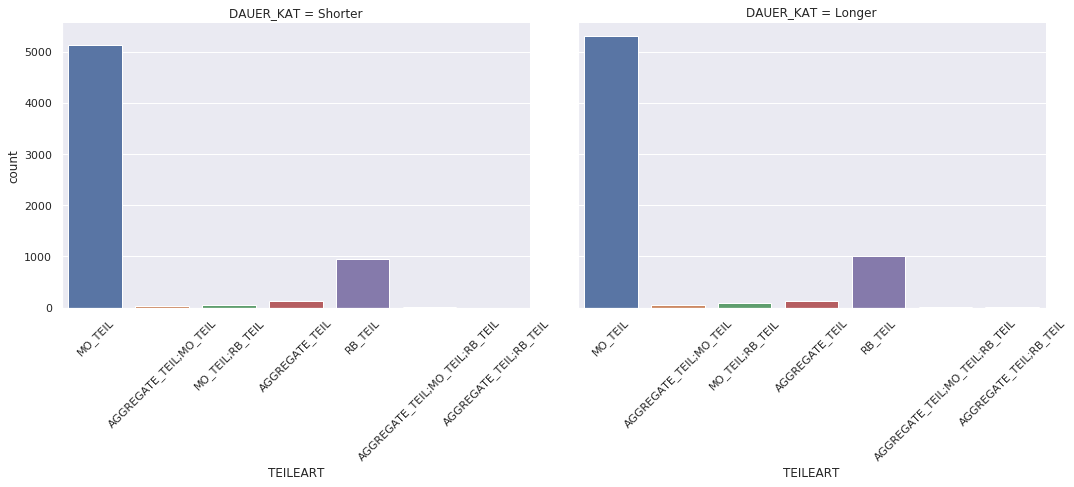

In [996]:
g = sns.catplot(x="TEILEART",col ='DAUER_KAT',kind="count", data=input_df_final_clean,height=5,aspect=1.5)
g.set_xticklabels(rotation=45)

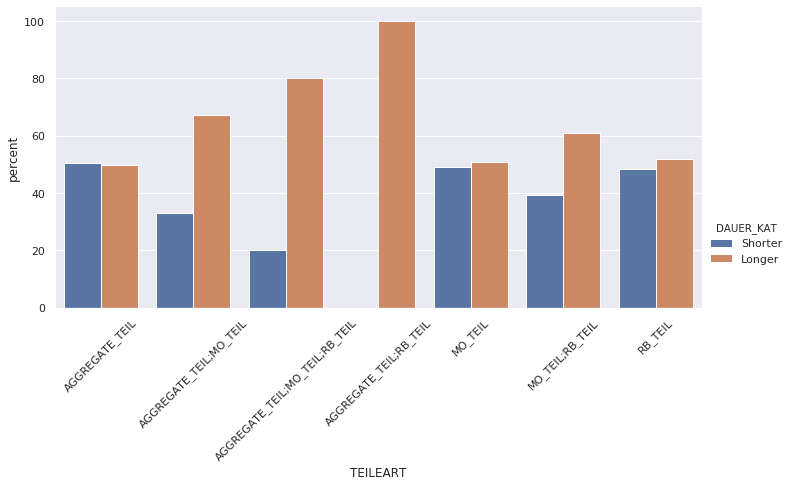

In [997]:
x,y = 'TEILEART', 'DAUER_KAT'
(input_df_final_clean
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',height=5,aspect=2)).set_xticklabels(rotation=45)

### 7. Bnd_MK

In [998]:
tmp_df_x_it = input_df_final_clean.copy()
tmp_df_x_it.columns

Index(['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'BRAA',
       'ANZAHL_PAKET', 'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG', 'DAUER', 'DAUER_KAT',
       'TypZahl', 'MK_BENENNUNG', 'MSK', 'Bnd_KAT', 'KG', 'KGU', 'cleaned_IST',
       'cleaned_SOLL', 'cleaned_Stichwort', 'cleaned_Benennung',
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH',
       'EE_STEUERGERAET_BE

In [999]:
def dauer_cat_tmp(row):
    if row['DAUER'] <= pd.to_timedelta('41 days'):
        val = 'Shorter'
    #elif (row['DAUER'] > pd.to_timedelta('42 days')) & (row['DAUER'] <= pd.to_timedelta('64 days')):
        #val = 'Q2'
#     elif (row['DAUER'] > pd.to_timedelta('33 days')) & (row['DAUER'] <= pd.to_timedelta('64 days')):
#         val = 'Q3'
    else:
        val = 'Longer'
    return val

tmp_df_x_it['DAUER_KAT_tmp'] = tmp_df_x_it.apply(dauer_cat_tmp, axis=1)

In [1000]:
tmp_df_x_it[['DAUER','DAUER_KAT_tmp']]

DAUER DAUER_KAT_tmp
0     36 days       Shorter
10    83 days        Longer
28    45 days        Longer
38    66 days        Longer
48    42 days        Longer
...       ...           ...
50227 83 days        Longer
50229 56 days        Longer
50231 38 days       Shorter
50233 93 days        Longer
50235 34 days       Shorter

[12854 rows x 2 columns]

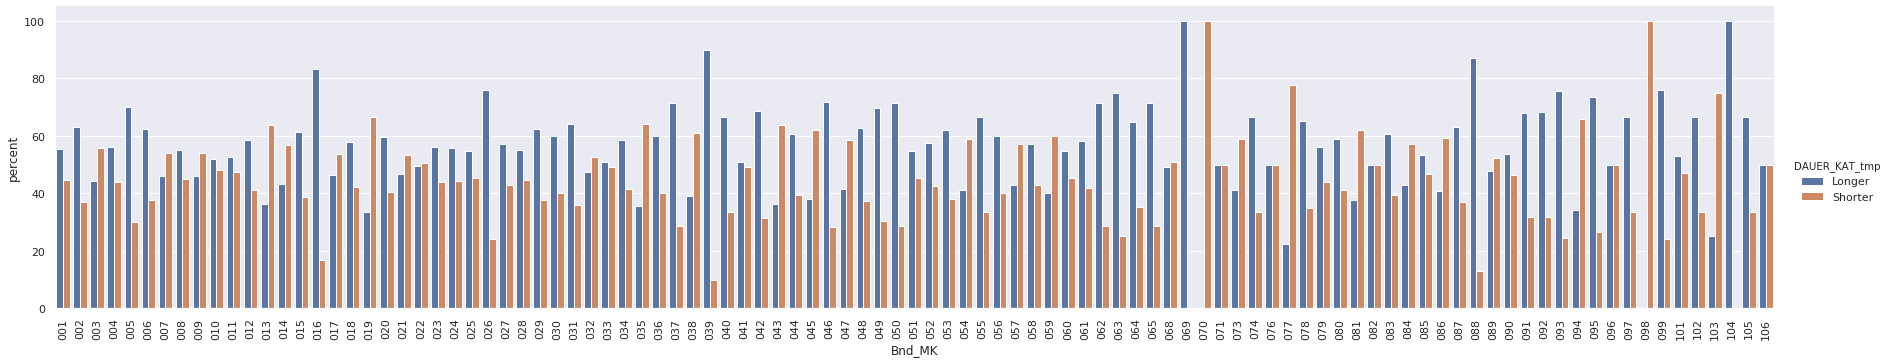

In [1001]:
x,y = 'Bnd_MK', 'DAUER_KAT_tmp'
(tmp_df_x_it
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',height=5,aspect=5)).set_xticklabels(rotation=90)

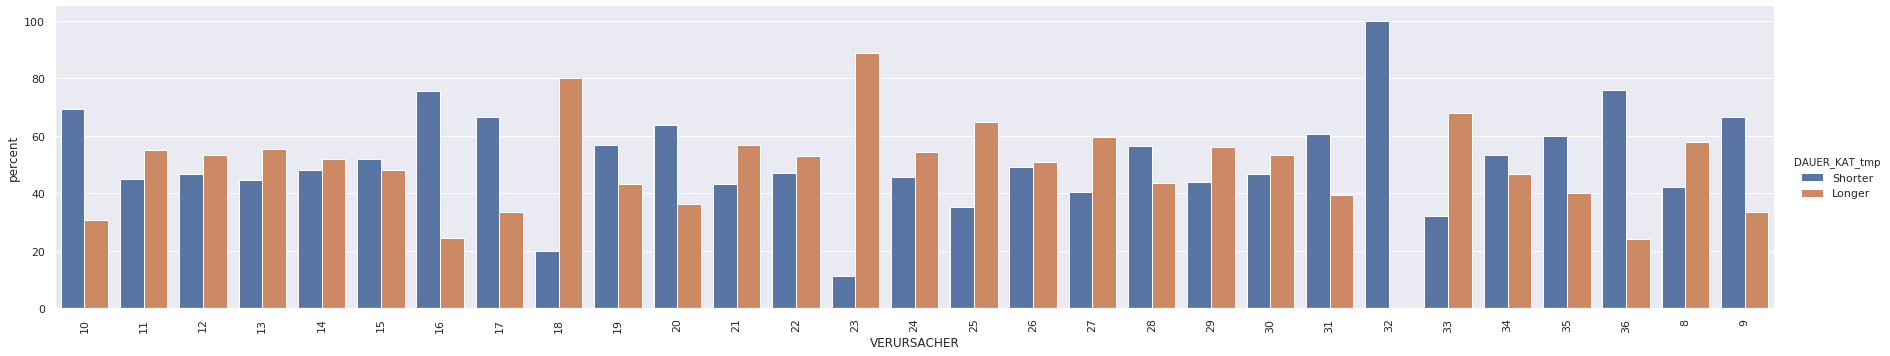

In [1002]:
x,y = 'VERURSACHER', 'DAUER_KAT_tmp'
(tmp_df_x_it
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',height=5,aspect=5)).set_xticklabels(rotation=90)

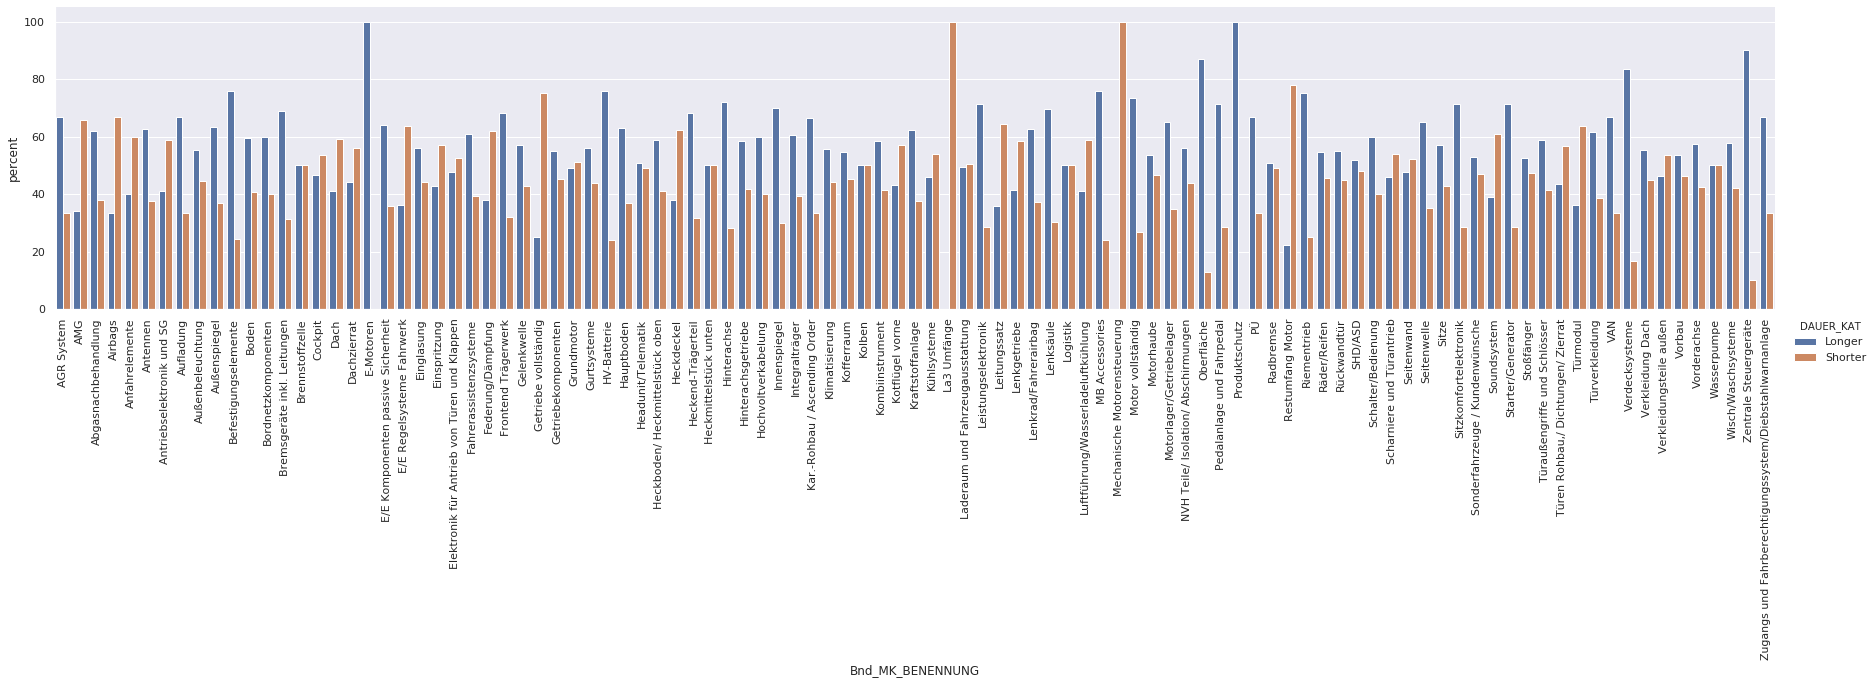

In [1003]:
x,y = 'Bnd_MK_BENENNUNG', 'DAUER_KAT'
(input_df_final_clean
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',height=5,aspect=5)).set_xticklabels(rotation=90)

In [1004]:
input_df_final_clean.groupby(['Bnd_MK_BENENNUNG'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False).head(20)

Bnd_MK_BENENNUNG
Leitungssatz                           904
Seitenwand                             771
Türen Rohbau,/ Dichtungen/ Zierrat     736
Cockpit                                730
AMG                                    623
Sitze                                  459
Stoßfänger                             437
Vorbau                                 423
NVH Teile/ Isolation/ Abschirmungen    413
Türverkleidung                         389
Laderaum und Fahrzeugausstattung       362
Außenbeleuchtung                       359
Einglasung                             343
Klimatisierung                         280
Verkleidung Dach                       268
Boden                                  239
Antriebselektronik und SG              238
Federung/Dämpfung                      218
Kraftstoffanlage                       202
Headunit/Telematik                     187
Name: BUENDEL_NUMMER, dtype: int64

In [1005]:
input_df_final_clean.loc[input_df_final_clean['DAUER']>'41 days 19:18:43.751891'].groupby(
    ['Bnd_MK_BENENNUNG'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False).head(20)

Bnd_MK_BENENNUNG
Seitenwand                             368
Cockpit                                340
Leitungssatz                           323
Türen Rohbau,/ Dichtungen/ Zierrat     319
Sitze                                  262
Türverkleidung                         239
NVH Teile/ Isolation/ Abschirmungen    232
Stoßfänger                             230
Vorbau                                 227
AMG                                    213
Außenbeleuchtung                       199
Einglasung                             192
Laderaum und Fahrzeugausstattung       179
Klimatisierung                         156
Verkleidung Dach                       148
Boden                                  142
Kraftstoffanlage                       126
Kar.-Rohbau / Ascending Order          111
Antriebselektronik und SG               98
Headunit/Telematik                      95
Name: BUENDEL_NUMMER, dtype: int64

In [1006]:
input_df_final_clean.loc[input_df_final_clean['DAUER']<='41 days 19:18:43.751891'].groupby(
    ['Bnd_MK_BENENNUNG'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

Bnd_MK_BENENNUNG
Leitungssatz                          581
Türen Rohbau,/ Dichtungen/ Zierrat    417
AMG                                   410
Seitenwand                            403
Cockpit                               390
                                     ... 
Kolben                                  1
Riementrieb                             1
VAN                                     1
Verdecksysteme                          1
Wasserpumpe                             1
Name: BUENDEL_NUMMER, Length: 99, dtype: int64

### 8. Sicherheit Relevant

In [397]:
df_bnd_ab_abgeschlossen_dauer.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'KAT', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'MK', 'MK_BENENNUNG', 'ProduktKlasse', 'BR', 'AA', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'ANZAHL_PAKET',
       'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 'BRAA',
       'DAUER', 'DAUER_KAT'],
      dtype='object')

In [398]:
# JA: 29% 
input_df_final_clean.groupby(['SICHERHEITSRELEVANT'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

SICHERHEITSRELEVANT
NEIN    9081
JA      3773
Name: BUENDEL_NUMMER, dtype: int64

In [399]:
input_df_final_clean.loc[input_df_final_clean['SICHERHEITSRELEVANT']=='JA']['DAUER'].describe()

count                       3773
mean     57 days 12:13:55.833554
std      55 days 12:19:59.175316
min              1 days 00:00:00
25%             33 days 00:00:00
50%             41 days 00:00:00
75%             62 days 00:00:00
max            602 days 00:00:00
Name: DAUER, dtype: object

In [400]:
input_df_final_clean.loc[input_df_final_clean['SICHERHEITSRELEVANT']=='NEIN']['DAUER'].describe()

count                       9081
mean     61 days 23:52:23.310208
std      60 days 09:11:38.370885
min              0 days 00:00:00
25%             33 days 00:00:00
50%             42 days 00:00:00
75%             70 days 00:00:00
max            685 days 00:00:00
Name: DAUER, dtype: object

In [401]:
# JA: 30%
input_df_final_clean.loc[input_df_final_clean['DAUER']<='59 days 19:18:43.751891'].groupby(
    ['SICHERHEITSRELEVANT'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

SICHERHEITSRELEVANT
NEIN    6297
JA      2777
Name: BUENDEL_NUMMER, dtype: int64

In [402]:
# JA: 26%
input_df_final_clean.loc[input_df_final_clean['DAUER']>'59 days 19:18:43.751891'].groupby(
    ['SICHERHEITSRELEVANT'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

SICHERHEITSRELEVANT
NEIN    2784
JA       996
Name: BUENDEL_NUMMER, dtype: int64

### 9. ZERTIFIZIERUNGS_RELEVANT

In [403]:
input_df_final_clean.groupby(['ZERTIFIZIERUNGS_RELEVANT'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

ZERTIFIZIERUNGS_RELEVANT
NEIN    8002
JA      4852
Name: BUENDEL_NUMMER, dtype: int64

In [404]:
input_df_final_clean.loc[input_df_final_clean['ZERTIFIZIERUNGS_RELEVANT']=='JA']['DAUER'].describe()

count                       4852
mean     61 days 11:02:25.424567
std      59 days 00:27:26.511467
min              1 days 00:00:00
25%             34 days 00:00:00
50%             42 days 00:00:00
75%             68 days 00:00:00
max            685 days 00:00:00
Name: DAUER, dtype: object

In [405]:
input_df_final_clean.loc[input_df_final_clean['ZERTIFIZIERUNGS_RELEVANT']=='NEIN']['DAUER'].describe()

count                       8002
mean     60 days 04:54:02.789302
std      59 days 00:47:51.571641
min              0 days 00:00:00
25%             32 days 00:00:00
50%             42 days 00:00:00
75%             66 days 00:00:00
max            622 days 00:00:00
Name: DAUER, dtype: object

In [406]:
input_df_final_clean.loc[input_df_final_clean['DAUER']<='59 days 19:18:43.751891'].groupby(
    ['ZERTIFIZIERUNGS_RELEVANT'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

ZERTIFIZIERUNGS_RELEVANT
NEIN    5656
JA      3418
Name: BUENDEL_NUMMER, dtype: int64

In [407]:
input_df_final_clean.loc[input_df_final_clean['DAUER']>'59 days 19:18:43.751891'].groupby(
    ['ZERTIFIZIERUNGS_RELEVANT'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

ZERTIFIZIERUNGS_RELEVANT
NEIN    2346
JA      1434
Name: BUENDEL_NUMMER, dtype: int64

## Predict influecing factors of long lead time of ECR

In [1007]:
df_bnd_ab_abgeschlossen_dauer['DAUER_KAT'].describe()

count      56181
unique         2
top       Longer
freq       29746
Name: DAUER_KAT, dtype: object

In [1008]:
input_df_final['DAUER_KAT'].describe()

count      12856
unique         2
top       Longer
freq        6580
Name: DAUER_KAT, dtype: object

In [1009]:
input_df_final_clean['LIEFERANTEN_NUMMER'] = input_df_final_clean['LIEFERANTEN_NUMMER'].fillna('None')
input_df_final_clean['WERK_Ctime'] = input_df_final_clean['WERK_Ctime'].fillna('None')
input_df_final_clean['WERKSKENNBUCHSTABE'] = input_df_final_clean['WERKSKENNBUCHSTABE'].fillna('None')

input_df_final_clean['LIEFERANTEN_NUMMER'] = input_df_final_clean['LIEFERANTEN_NUMMER'].astype('str')
input_df_final_clean['WERK_Ctime'] = input_df_final_clean['WERK_Ctime'].astype('str')
input_df_final_clean['WERKSKENNBUCHSTABE'] = input_df_final_clean['WERKSKENNBUCHSTABE'].astype('str')

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [413]:
# # Encoding multi-label features: external partner numbers, Werk_Ctime, Werk
# from sklearn.preprocessing import MultiLabelBinarizer

# def encode_multilabel_features(s):
#     ext_nummers = []
#     ext_nummers = [
#             row['LIEFERANTEN_NUMMER'].split(";")
#             for index,row in input_df_final_clean.iterrows()
#             ]

#     werk_ctime = []
#     werk_ctime = [
#             row['WERK_Ctime'].split(";")
#             for index,row in input_df_final_clean.iterrows()
#             ]


#     werk = []
#     werk = [
#             row['WERKSKENNBUCHSTABE'].split(";")
#             for index,row in input_df_final_clean.iterrows()
#             ]
    
#     for i in ext_nummers:
#         if 'None' in i:
#             i.remove('None')
#         if 'nan' in i:
#             i.remove('nan')

#     for j in werk_ctime:
#         if 'None' in j:
#             j.remove('None')
#         if 'nan' in j:
#             j.remove('nan')

#     for k in werk:
#         if 'None' in k:
#             k.remove('None')
#         if 'nan' in k:
#             k.remove('nan')
    
#     encode_ext_nummers = []    
#     mlb_ext = MultiLabelBinarizer()
#     encode_ext_nummers = mlb_ext.fit_transform(ext_nummers)
    
#     encode_werkctime = []    
#     mlb_werkctime = MultiLabelBinarizer()
#     encode_werkctime = mlb_werkctime.fit_transform(werk_ctime)
    
#     encode_werk = []    
#     mlb_werk = MultiLabelBinarizer()
#     encode_werk = mlb_werk.fit_transform(werk)

#     encoded_multi_feature = np.hstack((encode_ext_nummers,encode_werkctime,encode_werk))
#     multi_feature_names = np.hstack((mlb_ext.classes_,mlb_werkctime.classes_,mlb_werk.classes_))
#     return encoded_multi_feature, multi_feature_names


In [414]:
#encoded_multi_feature, multi_feature_names = encode_multilabel_features(input_df_final_clean)

In [415]:
#encoded_multi_feature

In [416]:
#multi_feature_names

In [1010]:
# encoding multi-label features: Ext, Werk, WerkCtime into numeric values, and append to the input dataframe as features
# these features can be selected as numeric features in numeric pipeline

df_encoded_ext = input_df_final_clean['LIEFERANTEN_NUMMER'].str.get_dummies(';')
df_encoded_ext = df_encoded_ext.add_prefix('EXT_')

df_encoded_werk_ctime= input_df_final_clean['WERK_Ctime'].str.get_dummies(';')
df_encoded_werk_ctime = df_encoded_werk_ctime.add_prefix('Werk_Ctime_')

df_encoded_werk = input_df_final_clean['WERKSKENNBUCHSTABE'].str.get_dummies(';')
df_encoded_werk = df_encoded_werk.add_prefix('WKB_')



In [1011]:
df_encoded_multi_feature = pd.concat([df_encoded_ext,df_encoded_werk_ctime,df_encoded_werk], axis=1)


In [1012]:
df_encoded_multi_feature

EXT_10001022  EXT_10003408  EXT_10006005  EXT_10006708  EXT_10006807  \
0                 0             0             0             0             0   
10                0             0             0             0             0   
28                0             0             0             0             0   
38                0             0             0             0             0   
48                0             0             0             0             0   
...             ...           ...           ...           ...           ...   
50227             0             0             0             0             0   
50229             0             0             0             0             0   
50231             0             0             0             0             0   
50233             0             0             0             0             0   
50235             0             0             0             0             0   

       EXT_10100014  EXT_10100030  EXT_10100089  EXT_10100121  EXT_10100253  \
0                 0             0             0             0             0   
10                0             0             0             0             0   
28                0             0             0             0             0   
38                0             0             0             0             0   
48                0             0             0             0             0   
...             ...           ...           ...           ...           ...   
50227             0             0             0             0             0   
50229             0             0             0             0             0   
50231             0             0             0             0             0   
50233             0             0             0             0             0   
50235             0             0             0             0             0   

       ...  WKB_XE  WKB_XG  WKB_XM  WKB_XP  WKB_XQ  WKB_XR  WKB_XT  WKB_Z  \
0      ...       0       0       0       0       0       0       0      1   
10     ...       0       0       0       0       0       0       0      1   
28     ...       0       0       0       0       1       0       0      1   
38     ...       0       0       0       0       1       0       0      1   
48     ...       0       0       0       0       1       0       0      1   
...    ...     ...     ...     ...     ...     ...     ...     ...    ...   
50227  ...       0       0       0       0       0       0       0      0   
50229  ...       0       0       0       0       0       0       0      0   
50231  ...       0       0       0       0       0       0       0      0   
50233  ...       0       0       0       0       0       0       0      0   
50235  ...       0       0       0       0       0       0       0      0   

       WKB_ZM  WKB_ZV  
0           0       0  
10          0       0  
28          0       0  
38          0       0  
48          0       0  
...       ...     ...  
50227       0       0  
50229       0       0  
50231       0       0  
50233       0       0  
50235       0       0  

[12854 rows x 1263 columns]

In [645]:
# get column names of data frame in a list
col_names = list(df_encoded_multi_feature)
print("\nNames of dataframe columns")
print(col_names)




Names of dataframe columns
['EXT_10001022', 'EXT_10003408', 'EXT_10006005', 'EXT_10006708', 'EXT_10006807', 'EXT_10100014', 'EXT_10100030', 'EXT_10100089', 'EXT_10100121', 'EXT_10100253', 'EXT_10100618', 'EXT_10101459', 'EXT_10101830', 'EXT_10103307', 'EXT_10104172', 'EXT_10107423', 'EXT_10114890', 'EXT_10116432', 'EXT_10125169', 'EXT_10169092', 'EXT_10200012', 'EXT_10200087', 'EXT_10200244', 'EXT_10200293', 'EXT_10200665', 'EXT_10200723', 'EXT_10200947', 'EXT_10201093', 'EXT_10201390', 'EXT_10203107', 'EXT_10203545', 'EXT_10205573', 'EXT_10206100', 'EXT_10207645', 'EXT_10211563', 'EXT_10214997', 'EXT_10216182', 'EXT_10218857', 'EXT_10228807', 'EXT_10230993', 'EXT_10236735', 'EXT_10237345', 'EXT_10240083', 'EXT_10274579', 'EXT_10277515', 'EXT_10289510', 'EXT_10300010', 'EXT_10306843', 'EXT_10315745', 'EXT_10315794', 'EXT_10322618', 'EXT_10334605', 'EXT_10400299', 'EXT_10402824', 'EXT_10407138', 'EXT_10411551', 'EXT_10430403', 'EXT_10450732', 'EXT_10499994', 'EXT_10500270', 'EXT_105011

In [1013]:
# loop to change each column to category type
for col in col_names:
    df_encoded_multi_feature[col] = df_encoded_multi_feature[col].astype('category',copy=False)

print("\nExample data changed to category type")



Example data changed to category type


In [1014]:
df_encoded_multi_feature.head(5)

EXT_10001022 EXT_10003408 EXT_10006005 EXT_10006708 EXT_10006807  \
0             0            0            0            0            0   
10            0            0            0            0            0   
28            0            0            0            0            0   
38            0            0            0            0            0   
48            0            0            0            0            0   

   EXT_10100014 EXT_10100030 EXT_10100089 EXT_10100121 EXT_10100253  ...  \
0             0            0            0            0            0  ...   
10            0            0            0            0            0  ...   
28            0            0            0            0            0  ...   
38            0            0            0            0            0  ...   
48            0            0            0            0            0  ...   

   WKB_XE WKB_XG WKB_XM WKB_XP WKB_XQ WKB_XR WKB_XT WKB_Z WKB_ZM WKB_ZV  
0       0      0      0      0      0      0      0     1      0      0  
10      0      0      0      0      0      0      0     1      0      0  
28      0      0      0      0      1      0      0     1      0      0  
38      0      0      0      0      1      0      0     1      0      0  
48      0      0      0      0      1      0      0     1      0      0  

[5 rows x 1263 columns]

In [1015]:
input_df_final_clean[input_df_final_clean['ANZAHL_EXT'] < 0] = 0
input_df_final_clean[input_df_final_clean['ANZAHL_WERK'] < 0] = 0
input_df_final_clean[input_df_final_clean['ANZAHL_WERK_Ctime'] < 0] = 0

input_df_final_clean['ANZAHL_EXT'] = input_df_final_clean['ANZAHL_EXT'].fillna(0)
input_df_final_clean['ANZAHL_WERK'] = input_df_final_clean['ANZAHL_WERK'].fillna(0)
input_df_final_clean['ANZAHL_WERK_Ctime'] = input_df_final_clean['ANZAHL_WERK_Ctime'].fillna(0)

input_df_final_clean['ANZAHL_EXT'] = input_df_final_clean['ANZAHL_EXT'].astype('int')
input_df_final_clean['ANZAHL_WERK'] = input_df_final_clean['ANZAHL_WERK'].astype('int')
input_df_final_clean['ANZAHL_WERK_Ctime'] = input_df_final_clean['ANZAHL_WERK_Ctime'].astype('int')



/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/yuwepan/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [1016]:
input_df_final_clean_new = pd.concat([input_df_final_clean,df_encoded_multi_feature], axis=1)

In [1017]:
input_df_final_clean_new = input_df_final_clean_new.fillna(0)

In [1018]:
rows_with_nan = []
for index, row in input_df_final_clean_new.iterrows():
    is_nan_series = row.isnull()
    if is_nan_series.any():
        rows_with_nan.append(index)

print(rows_with_nan)

[]


In [1019]:
input_df_final_clean_new.dtypes

BUENDEL_NUMMER               object
CREATION_DATE                object
RUECKMELDE_DATUM             object
MODIFICATION_DATE    datetime64[ns]
STATUS                       object
                          ...      
WKB_XR                     category
WKB_XT                     category
WKB_Z                      category
WKB_ZM                     category
WKB_ZV                     category
Length: 1319, dtype: object

In [1020]:
input_df_final_clean['ANZAHL_WERK_Ctime'].describe()

count    12854.000000
mean         4.005290
std          4.462554
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         99.000000
Name: ANZAHL_WERK_Ctime, dtype: float64

In [1021]:
input_df_final_clean.loc[input_df_final_clean['LIEFERANTEN_NUMMER']=='None']['ANZAHL_EXT']

395      0
410      0
467      0
470      0
845      0
        ..
50172    0
50182    0
50197    0
50209    0
50215    0
Name: ANZAHL_EXT, Length: 2267, dtype: int64

In [1022]:
input_df_final_clean.loc[input_df_final_clean['WERK_Ctime']=='None']['ANZAHL_WERK_Ctime']

48       0
395      0
410      0
450      0
467      0
        ..
50182    0
50197    0
50209    0
50215    0
50235    0
Name: ANZAHL_WERK_Ctime, Length: 2271, dtype: int64

In [1023]:
input_df_final_clean['DAUER_KAT'].nunique()

2

In [1024]:
class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)
    
    

In [1025]:
# Create the tf-idf representation using the bag-of-words matrix
class TextBowTfidfTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes in a list of values as its argument
    def __init__(self,field=None, min_df=None, stop_words=None):
        self.field = field
        self.min_df = min_df
        
    def fit(self, X, y=None):
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        bow_transform = CountVectorizer(min_df=self.min_df, stop_words=stops)
        #bow_transform = CountVectorizer(min_df = self.min_df, stop_words=stops, ngram_range=(2,2))
        train_x_bow = bow_transform.fit_transform(train_x[str(self.field)])
        X_bow= bow_transform.transform(X[str(self.field)])
        
        tfidf_trfm = TfidfTransformer(norm=None)
        train_x_tfidf = tfidf_trfm.fit_transform(train_x_bow)
        X_tfidf = tfidf_trfm.transform(X_bow)
       
        return np.asmatrix(X_tfidf.toarray())

In [1026]:
import category_encoders as ce
#hc_features = ['VERANTWORTLICHER_FK', 'VERURSACHER', 'Bnd_MK_BENENNUNG', 'GREMIUM_ENTSCHEIDUNG_MANUELL']
hc_features = ['VERURSACHER', 'Bnd_MK_BENENNUNG']
hc_pipeline = make_pipeline(ce.TargetEncoder())
# hc_pipeline_verantwortlicher = make_pipeline(ce.HashingEncoder(n_components=1000))
# hc_pipeline_verursacher = make_pipeline(ce.HashingEncoder(n_components=30))
# hc_pipeline_mk = make_pipeline(ce.HashingEncoder(n_components=100))
# hc_pipeline_gre = make_pipeline(ce.HashingEncoder(n_components=40))


print(f'N hc_features: {len(hc_features)} \n')
print(', '.join(hc_features))

N hc_features: 2 

VERURSACHER, Bnd_MK_BENENNUNG


In [1027]:
# One-Hot Encoding: Modulecomponent of Bündle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer

# #oh_features = ['Bnd_MK_BENENNUNG']
# oh_features = []
# oh_features = ['KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT', 'EMISSIONSKENNZEICHEN', 
#                'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT', 'TEILEART', 'EE_STEUERGERAET_BETROFFEN', 
#                'BETRIEBSANLEITUNG_BETROFFEN', 'LEITUNGSSATZ_BETROFFEN', 'LASTENHEFTAENDERUNG_ERFORDERLICH', 
#                'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN']
#oh_pipeline = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))

MAX_OH_CARDINALITY = 200

def select_oh_features(df):
    
    oh_features =\
        df\
        .select_dtypes(['object', 'category'])\
        .apply(lambda col: col.nunique())\
        .loc[lambda x: x < MAX_OH_CARDINALITY ]\
        .index\
        .tolist()
        
    return oh_features

oh_features = []
oh_features = select_oh_features(input_df_final_clean)
#oh_features = ['VERURSACHER', 'Bnd_MK_BENENNUNG']
oh_features.remove('STATUS')
oh_features.remove('KOSTEN_RELEVANT')
oh_features.remove('ZERTIFIZIERUNGS_RELEVANT')
oh_features.remove('PROZESS_STATUS')
oh_features.remove('STATUS_GENEHMIGUNG')
oh_features.remove('DAUER_KAT')
oh_features.remove('EMISSIONSKENNZEICHEN')
oh_features.remove('BESCHAFFUNGSART')
oh_features.remove('SICHERHEITSRELEVANT')
oh_features.remove('TEILEART')
oh_features.remove('KOSTENBEWERTUNGS_ART')

oh_features.remove('WERKZEUGAENDERUNG_ERFORDERLICH')
oh_features.remove('EE_STEUERGERAET_BETROFFEN')
oh_features.remove('BETRIEBSANLEITUNG_BETROFFEN')
oh_features.remove('LEITUNGSSATZ_BETROFFEN')
oh_features.remove('LASTENHEFTAENDERUNG_ERFORDERLICH')
oh_features.remove('VERSUCHSTEIL_ASACHNUMMER_BETROFFEN')

oh_features.remove('GEWUENSCHTER_EINSATZ')
oh_features.remove('GREMIUM_ENTSCHEIDUNG_MANUELL')
oh_features.remove('Bnd_MK')
oh_features.remove('Bnd_KAT')
oh_features.remove('VERURSACHER')


oh_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

print(f'N oh_features: {len(oh_features)} \n')
print(', '.join(oh_features))

N oh_features: 1 

Bnd_MK_BENENNUNG


In [1252]:
# Numeric features
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer

numeric_features = []

#numeric_features = select_numeric_features(input_df_final_clean_new)
#numeric_features.remove('DAUER')
#numeric_features.remove('ANZAHL_ZB_BENENNUNG')
# numeric_features.remove('EXT_None')
# numeric_features.remove('EXT_nan')
# numeric_features.remove('Werk_Ctime_None')
# numeric_features.remove('Werk_Ctime_nan')
# numeric_features.remove('WKB_nan')


numeric_features = ['ANZAHL_PAKET', 'ANZAHL_WERK_Ctime', 'ANZAHL_WERK','ANZAHL_EXT', 'ANZAHL_SACHNUMMER']
#numeric_features = ['ANZAHL_PAKET', 'ANZAHL_SACHNUMMER']
numeric_pipeline = SelectColumns(numeric_features)

print(f'N numeric_features: {len(numeric_features)} \n')
print(', '.join(numeric_features))



N numeric_features: 5 

ANZAHL_PAKET, ANZAHL_WERK_Ctime, ANZAHL_WERK, ANZAHL_EXT, ANZAHL_SACHNUMMER


In [1253]:
from sklearn.compose import ColumnTransformer
column_transformer =\
    ColumnTransformer(transformers=\
                          [('txt_ist_pipeline', TfidfVectorizer(min_df=2,stop_words=stops), 'cleaned_IST'),\
                           ('txt_benennung_pipeline', TfidfVectorizer(min_df=3,stop_words=stops), 'cleaned_Benennung'),\
                           ('txt_stichwort_pipeline', TfidfVectorizer (min_df=3, stop_words=stops), 'cleaned_Stichwort'),\
                          #('oh_pipeline', OneHotEncoder(handle_unknown='ignore'), oh_features),\
                          ('hc_pipeline', ce.TargetEncoder(), hc_features),\
                           ('numeric_pipeline', numeric_pipeline, numeric_features)],\
                            n_jobs=-1,remainder='drop')

### Predictin processing time of new Bündel

In [1254]:
input_df_final_clean.groupby(['DAUER_KAT']).nunique()

BUENDEL_NUMMER  CREATION_DATE  RUECKMELDE_DATUM  MODIFICATION_DATE  \
DAUER_KAT                                                                       
Longer               6579           1211              1190               6579   
Shorter              6275           1211              1129               6275   

           STATUS  BENENNUNG  STICHWORT  VERURSACHER  new_IST  new_SOLL  ...  \
DAUER_KAT                                                                ...   
Longer          2       4359       5069           28     5584      5866  ...   
Shorter         2       4459       5171           29     5478      5693  ...   

           BESCHAFFUNGSART  SICHERHEITSRELEVANT  TEILEART  \
DAUER_KAT                                                   
Longer                   3                    2         7   
Shorter                  3                    2         6   

           WERKZEUGAENDERUNG_ERFORDERLICH  EE_STEUERGERAET_BETROFFEN  \
DAUER_KAT                                                              
Longer                                  3                          2   
Shorter                                 3                          2   

           BETRIEBSANLEITUNG_BETROFFEN  LEITUNGSSATZ_BETROFFEN  \
DAUER_KAT                                                        
Longer                               2                       2   
Shorter                              2                       2   

           LASTENHEFTAENDERUNG_ERFORDERLICH  \
DAUER_KAT                                     
Longer                                    2   
Shorter                                   2   

           VERSUCHSTEIL_ASACHNUMMER_BETROFFEN  MK_KG  
DAUER_KAT                                             
Longer                                      3    884  
Shorter                                     3    649  

[2 rows x 56 columns]

In [1222]:
df_x_it = pd.DataFrame(input_df_final_clean.copy())

In [925]:
# filter_col = [col for col in df_x_it if (col.startswith('EXT_')) | (col.startswith('Werk_Ctime_')) | (col.startswith('WKB_'))]
# filter_col

In [926]:
#df_x_it[filter_col]=df_x_it[filter_col].astype('category')

In [1223]:
input_df_final_clean_new['ANZAHL_WERK_Ctime'].describe()

count    12854.000000
mean         4.005290
std          4.462554
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         99.000000
Name: ANZAHL_WERK_Ctime, dtype: float64

In [1224]:
df_x_it.dtypes

BUENDEL_NUMMER                        object
CREATION_DATE                         object
RUECKMELDE_DATUM                      object
MODIFICATION_DATE                     object
STATUS                                object
BENENNUNG                             object
STICHWORT                             object
VERURSACHER                           object
new_IST                               object
new_SOLL                              object
GEWUENSCHTER_EINSATZ                  object
KOSTEN_RELEVANT                       object
ZERTIFIZIERUNGS_RELEVANT              object
PROZESS_STATUS                        object
VERANTWORTLICHER_FK                   object
GREMIUM_ENTSCHEIDUNG_MANUELL          object
STATUS_GENEHMIGUNG                    object
RUECKSPRUNG_KOMMENTAR                 object
KOSTENBEWERTUNGS_ART                  object
BEGR_RUECKSPRUNG                      object
Bnd_MK                                object
Bnd_MK_BENENNUNG                      object
WERKSKENNB

In [1225]:
df_x_it['cleaned_IST'] = df_x_it['cleaned_IST'].astype('str')
df_x_it['cleaned_Benennung'] = df_x_it['cleaned_Benennung'].astype('str')
df_x_it['cleaned_Stichwort'] = df_x_it['cleaned_Stichwort'].astype('str')

#df_x_it['LIEFERANTEN_NUMMER'] = df_x_it['LIEFERANTEN_NUMMER'].astype('str')
#df_x_it['WERK_Ctime'] = df_x_it['WERK_Ctime'].astype('str')
#df_x_it['WERKSKENNBUCHSTABE'] = df_x_it['WERKSKENNBUCHSTABE'].astype('str')

df_x_it['VERURSACHER'] = df_x_it['VERURSACHER'].fillna('None')
df_x_it['VERURSACHER'] = df_x_it['VERURSACHER'].astype('category')
df_x_it['Bnd_MK_BENENNUNG'] = df_x_it['Bnd_MK_BENENNUNG'].astype('category')

# df_x_it['KOSTEN_RELEVANT'] = df_x_it['KOSTEN_RELEVANT'].astype('category')
# df_x_it['ZERTIFIZIERUNGS_RELEVANT'] = df_x_it['ZERTIFIZIERUNGS_RELEVANT'].astype('category')
# df_x_it['GREMIUM_ENTSCHEIDUNG_MANUELL'] = df_x_it['GREMIUM_ENTSCHEIDUNG_MANUELL'].astype('category')
#df_x_it['Bnd_MK_BENENNUNG'] = df_x_it['Bnd_MK_BENENNUNG'].fillna('None')
#df_x_it['Bnd_MK_BENENNUNG'] = df_x_it['Bnd_MK_BENENNUNG'].astype('category')
# df_x_it['EMISSIONSKENNZEICHEN'] = df_x_it['EMISSIONSKENNZEICHEN'].astype('category')
# df_x_it['BESCHAFFUNGSART'] = df_x_it['BESCHAFFUNGSART'].astype('category')
# df_x_it['SICHERHEITSRELEVANT'] = df_x_it['SICHERHEITSRELEVANT'].astype('category')
# df_x_it['TEILEART'] = df_x_it['TEILEART'].astype('category')
# df_x_it['WERKZEUGAENDERUNG_ERFORDERLICH'] = df_x_it['WERKZEUGAENDERUNG_ERFORDERLICH'].astype('category')
# df_x_it['EE_STEUERGERAET_BETROFFEN'] = df_x_it['EE_STEUERGERAET_BETROFFEN'].astype('category')
# df_x_it['BETRIEBSANLEITUNG_BETROFFEN'] = df_x_it['BETRIEBSANLEITUNG_BETROFFEN'].astype('category')
# df_x_it['LEITUNGSSATZ_BETROFFEN'] = df_x_it['LEITUNGSSATZ_BETROFFEN'].astype('category')
# df_x_it['LASTENHEFTAENDERUNG_ERFORDERLICH'] = df_x_it['LASTENHEFTAENDERUNG_ERFORDERLICH'].astype('category')
# df_x_it['VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'] = df_x_it['VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'].astype('category')
df_x_it['DAUER_KAT_num'] = df_x_it['DAUER_KAT'].astype('category').cat.codes


In [1226]:
df_x_it['Bnd_MK_BENENNUNG']

0                       VAN
10                      VAN
28                      VAN
38       Schalter/Bedienung
48       Schalter/Bedienung
                ...        
50227        Integralträger
50229        Integralträger
50231        Integralträger
50233        Integralträger
50235        Integralträger
Name: Bnd_MK_BENENNUNG, Length: 12854, dtype: category
Categories (101, object): [AGR System, AMG, Abgasnachbehandlung, Airbags, ..., Wasserpumpe, Wisch/Waschsysteme, Zentrale Steuergeräte, Zugangs und Fahrberechtigungssystem/Diebstahlw...]

In [1227]:
y_it = df_x_it['DAUER_KAT']

In [1228]:
df_x_it.loc[df_x_it['VERURSACHER'].isna()]

Empty DataFrame
Columns: [BUENDEL_NUMMER, CREATION_DATE, RUECKMELDE_DATUM, MODIFICATION_DATE, STATUS, BENENNUNG, STICHWORT, VERURSACHER, new_IST, new_SOLL, GEWUENSCHTER_EINSATZ, KOSTEN_RELEVANT, ZERTIFIZIERUNGS_RELEVANT, PROZESS_STATUS, VERANTWORTLICHER_FK, GREMIUM_ENTSCHEIDUNG_MANUELL, STATUS_GENEHMIGUNG, RUECKSPRUNG_KOMMENTAR, KOSTENBEWERTUNGS_ART, BEGR_RUECKSPRUNG, Bnd_MK, Bnd_MK_BENENNUNG, WERKSKENNBUCHSTABE, LIEFERANTEN_NUMMER, LIEFERANTEN_NAME, WERK_Ctime, BRAA, ANZAHL_PAKET, ANZAHL_WERK, ANZAHL_EXT, ANZAHL_WERK_Ctime, ANZAHL_SACHNUMMER, ANZAHL_ZB_BENENNUNG, DAUER, DAUER_KAT, TypZahl, MK_BENENNUNG, MSK, Bnd_KAT, KG, KGU, cleaned_IST, cleaned_SOLL, cleaned_Stichwort, cleaned_Benennung, EMISSIONSKENNZEICHEN, BESCHAFFUNGSART, SICHERHEITSRELEVANT, TEILEART, WERKZEUGAENDERUNG_ERFORDERLICH, EE_STEUERGERAET_BETROFFEN, BETRIEBSANLEITUNG_BETROFFEN, LEITUNGSSATZ_BETROFFEN, LASTENHEFTAENDERUNG_ERFORDERLICH, VERSUCHSTEIL_ASACHNUMMER_BETROFFEN, MK_KG, DAUER_KAT_num]
Index: []

[0 rows x 57 columns]

In [1229]:
from sklearn.model_selection import train_test_split
train_x_it, test_x_it, train_y_it, test_y_it = train_test_split(df_x_it, y_it,test_size=0.2, random_state=42)

In [1402]:
df_x_it.to_csv("dlz_df_x_20210114.csv",encoding='utf-8-sig')

In [1403]:
train_x_it.to_csv("dlz_train_x_20210114.csv",encoding='utf-8-sig')

In [1480]:
train_y_it.to_csv("dlz_train_y_20210114.csv",encoding='utf-8-sig')

In [1255]:
df_x_it_pre = column_transformer.fit_transform(df_x_it,df_x_it['DAUER_KAT_num'])
#df_x_it_pre = column_transformer.fit_transform(df_x_it)
df_x_it_pre.shape

(12854, 12528)

In [1256]:
train_it_pre = column_transformer.transform(train_x_it)

In [1482]:
train_x_it.shape

(10283, 57)

In [1473]:
#train_it_pre.to_csv("dlz_train_x_pre_20210114.csv",encoding='utf-8-sig')

In [1257]:
test_it_pre = column_transformer.transform(test_x_it)

In [1477]:
train_x_it.shape

(10283, 57)

In [1478]:
test_it_pre.shape

(2571, 12528)

In [1488]:
type(train_y_it)

pandas.core.series.Series

In [1260]:
train_it_pre.toarray()[-3:]

array([[ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  9.,  5., 10.],
       [ 0.,  0.,  0., ...,  5.,  2.,  1.]])

In [1261]:
df_train_pre = pd.DataFrame(train_it_pre.toarray())
df_train_pre.head()

0      1      2         3      4      5      6      7      8      9      \
0    0.0    0.0    0.0  0.255782    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   

   ...  12518  12519  12520     12521     12522  12523  12524  12525  12526  \
0  ...    0.0    0.0    0.0  0.566952  0.445682    1.0    4.0    0.0    2.0   
1  ...    0.0    0.0    0.0  0.465664  0.522698    1.0    4.0    5.0    1.0   
2  ...    0.0    0.0    0.0  0.465664  0.442857    8.0    3.0    7.0    2.0   
3  ...    0.0    0.0    0.0  0.605566  0.480392   13.0    0.0    0.0    0.0   
4  ...    0.0    0.0    0.0  0.519427  0.451613   10.0    5.0    0.0    1.0   

   12527  
0   10.0  
1    2.0  
2    4.0  
3    8.0  
4    1.0  

[5 rows x 12528 columns]

In [1262]:
train_x_it[['VERURSACHER', 'Bnd_MK','Bnd_MK_BENENNUNG','DAUER_KAT']].head()

VERURSACHER Bnd_MK     Bnd_MK_BENENNUNG DAUER_KAT
49666          19    001     Außenbeleuchtung    Longer
15710          12    089           Seitenwand    Longer
12728          12    024       Klimatisierung   Shorter
48437          31    010              SHD/ASD   Shorter
18617          15    060  Getriebekomponenten   Shorter

In [1263]:
df_x_it.columns[0:25]

Index(['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME'],
      dtype='object')

In [1264]:
input_df_final_clean_new[['DAUER','DAUER_KAT']]

DAUER DAUER_KAT
0     36 days   Shorter
10    83 days    Longer
28    45 days    Longer
38    66 days    Longer
48    42 days    Longer
...       ...       ...
50227 83 days    Longer
50229 56 days    Longer
50231 38 days   Shorter
50233 93 days    Longer
50235 34 days   Shorter

[12854 rows x 2 columns]

In [1265]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier

import time
base_rf = RandomForestClassifier(bootstrap=True, criterion='gini', 
                                 random_state=42, n_estimators=200, n_jobs=-1, verbose=True)

svc = svm.SVC()
lin_svc = svm.LinearSVC()
lg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=3)

parameters = [
    {
        'criterion': ['gini', 'entropy'],
          
    }
]

# #score = 'f1_micro'
score = 'accuracy'
clf = GridSearchCV(base_rf, parameters, scoring=score,cv=3, verbose=True)
clf.fit(train_it_pre, train_y_it)

#lin_svc.fit(train_it_pre, train_y_it)
#lg.fit(train_it_pre, train_y_it)
#knn.fit(train_it_pre, train_y_it)
start=time.time()


print('training time taken: ',round(time.time()-start,0),'seconds')

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend Threadin

training time taken:  0.0 seconds


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished


In [1406]:
import joblib
joblib.dump(clf, 'dlz_ab_20210114.pkl')

['dlz_ab_20210114.pkl']

In [1266]:
clf.best_params_

{'criterion': 'entropy'}

In [1267]:
clf.classes_

array(['Longer', 'Shorter'], dtype=object)

In [1268]:
clf.cv_results_

{'mean_fit_time': array([1.42067997, 1.39874371]),
 'std_fit_time': array([0.02388553, 0.02268659]),
 'mean_score_time': array([0.12406039, 0.1245292 ]),
 'std_score_time': array([0.00177968, 0.00140696]),
 'param_criterion': masked_array(data=['gini', 'entropy'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini'}, {'criterion': 'entropy'}],
 'split0_test_score': array([0.64731622, 0.64585764]),
 'split1_test_score': array([0.63243874, 0.63243874]),
 'split2_test_score': array([0.63845929, 0.6460461 ]),
 'mean_test_score': array([0.63940475, 0.6414475 ]),
 'std_test_score': array([0.00611039, 0.00637062]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [1269]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()

0.639 (+/-0.012) for {'criterion': 'gini'}
0.641 (+/-0.013) for {'criterion': 'entropy'}



In [1270]:
from sklearn.metrics import classification_report

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = test_y_it, clf.predict(test_it_pre)
print(classification_report(y_true, y_pred))
print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.1s finished


              precision    recall  f1-score   support

      Longer       0.66      0.68      0.67      1326
     Shorter       0.65      0.63      0.64      1245

    accuracy                           0.66      2571
   macro avg       0.66      0.65      0.65      2571
weighted avg       0.66      0.66      0.66      2571




### Visualize Random Forest

In [465]:
from sklearn.tree import export_graphviz

In [466]:
len(clf.best_estimator_.estimators_)

100

In [467]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf,train_it_pre, train_y_it)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)

array([0.64073894, 0.64851726, 0.64754497, 0.64980545, 0.63861868])

In [1271]:
pred_it = clf.predict(test_it_pre)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.1s finished


In [1272]:
test_y_it[0:10]

38389    Shorter
44597    Shorter
49954    Shorter
1978      Longer
18635     Longer
42167    Shorter
30479     Longer
32489    Shorter
9297     Shorter
15667    Shorter
Name: DAUER_KAT, dtype: object

In [1273]:
pred_it[0:10]

array(['Shorter', 'Longer', 'Longer', 'Shorter', 'Shorter', 'Shorter',
       'Longer', 'Longer', 'Shorter', 'Shorter'], dtype=object)

In [1274]:
pred_it_proba = clf.predict_proba(test_it_pre)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.1s finished


In [1275]:
pred_it_proba

array([[0.345     , 0.655     ],
       [0.905     , 0.095     ],
       [0.74714286, 0.25285714],
       ...,
       [0.65      , 0.35      ],
       [0.35      , 0.65      ],
       [0.51      , 0.49      ]])

In [1276]:
print("Accuracy = ",round(accuracy_score(test_y_it,pred_it),ndigits=3))
#print("Accuracy_per Class = ",round(accuracy_score(test_y_it,pred_it),ndigits=3))

print("Micro_Precision = ",round(precision_score(test_y_it, pred_it, average='micro'),ndigits=3))
print("Precision_per class = ",precision_score(test_y_it, pred_it, average=None))
print('\n')

print("Micro_Recall = ",round(recall_score(test_y_it, pred_it, average='micro'),ndigits=3))
print("Weighted_Recall = ",round(recall_score(test_y_it, pred_it, average='weighted'),ndigits=3))
print('\n')

Accuracy =  0.656
Micro_Precision =  0.656
Precision_per class =  [0.66059723 0.65025042]


Micro_Recall =  0.656
Weighted_Recall =  0.656




In [1277]:
# Create a dictionary with most important features
importances = clf.best_estimator_.feature_importances_
importances

array([4.52154479e-05, 7.31474791e-06, 6.77911364e-06, ...,
       1.60168597e-02, 1.19556248e-02, 1.87953861e-02])

In [1278]:
importances.shape

(12528,)

In [1279]:
import warnings
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [1280]:
feature_names = np.array(get_feature_names(column_transformer))
for i,element in enumerate(feature_names):
    feature_names[i] = feature_names[i].replace('pipeline__','') 
    feature_names[i] = feature_names[i].replace('x0','MK')
#     feature_names[i] = feature_names[i].replace('x1','MK')
#     feature_names[i] = feature_names[i].replace('x2','EMISSIONKENNENZEICHEN')
#     feature_names[i] = feature_names[i].replace('x3','BESCHAFFUNGSART')
#     feature_names[i] = feature_names[i].replace('x4','SICHERHEITSRELEVANT')
#     feature_names[i] = feature_names[i].replace('x5','TEILEART')
#     #feature_names[i] = feature_names[i].replace('x6','WERKZEUGAENDERUNG_ERFORDERLICH')
#     feature_names[i] = feature_names[i].replace('x6','EE_STEUERGERAET_BETROFFEN')
#     feature_names[i] = feature_names[i].replace('x7','BETRIEBSANLEITUNG_BETROFFEN')
#     feature_names[i] = feature_names[i].replace('x8','LEITUNGSSATZ_BETROFFEN')
#     feature_names[i] = feature_names[i].replace('x9','LASTENHEFTAENDERUNG_ERFORDERLICH')
#     feature_names[i] = feature_names[i].replace('x10','VERSUCHSTEIL_ASACHNUMMER_BETROFFEN')
    
    

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Transformer numeric_pipeline (type SelectColumns) does not provide get_feature_names. Will return input column names if available


In [1281]:
feature_names

array(['txt_ist_aas', 'txt_ist_abbau', 'txt_ist_abbiegelicht', ...,
       'numeric_ANZAHL_WERK', 'numeric_ANZAHL_EXT',
       'numeric_ANZAHL_SACHNUMMER'], dtype='<U49')

In [958]:
import os
import pydot
from sklearn.tree import export_graphviz

class_names = ['Longer','Shorter']

export_graphviz(clf.best_estimator_.estimators_[1], out_file = 'tree.dot',
               feature_names=feature_names,
               class_names=class_names,
               rounded=True, proportion=False,
               precision=2, filled=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

0

In [1288]:
top_indices = np.argsort(importances)[::-1][:7]
top_indices

array([12522, 12527, 12524, 12521, 12525, 12523, 12526])

In [1289]:
words_importance = pd.DataFrame({'most_important_words': feature_names[top_indices],
                                 'importance': importances[top_indices]})
words_importance

most_important_words  importance
0        hc_Bnd_MK_BENENNUNG    0.025445
1  numeric_ANZAHL_SACHNUMMER    0.018795
2  numeric_ANZAHL_WERK_Ctime    0.017294
3             hc_VERURSACHER    0.016678
4        numeric_ANZAHL_WERK    0.016017
5       numeric_ANZAHL_PAKET    0.015469
6         numeric_ANZAHL_EXT    0.011956

Text(0.5, 1.0, 'Global features importance')

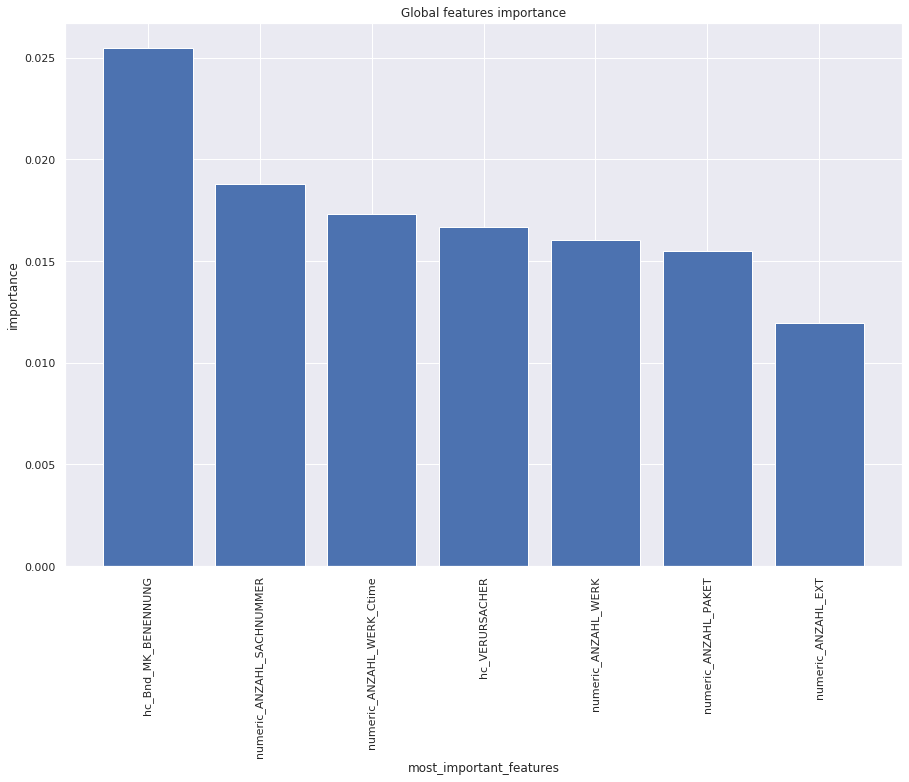

In [1290]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.xkcd(length=100)

# Create a dictionary with most important features
# importances = pipeline.named_steps['randomforestclassifier'].feature_importances_
# top_indices = np.argsort(importances)[::-1][:10]
# features_names = np.array(vectorizer.get_feature_names())
# words_importance = pd.DataFrame({'most_important_words': features_names[top_indices],
#                                  'importance': importances[top_indices]})
plt.figure(figsize=(15,10)) 
plt.bar(x=feature_names[top_indices], height=importances[top_indices])
plt.xlabel("most_important_features")
plt.ylabel("importance")
plt.xticks(rotation=90)
plt.title('Global features importance')

In [1291]:
feature_names

array(['txt_ist_aas', 'txt_ist_abbau', 'txt_ist_abbiegelicht', ...,
       'numeric_ANZAHL_WERK', 'numeric_ANZAHL_EXT',
       'numeric_ANZAHL_SACHNUMMER'], dtype='<U49')

In [1292]:
clf.classes_

array(['Longer', 'Shorter'], dtype=object)

In [ ]:
#del explainer

In [1293]:
from collections import OrderedDict
#from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer

class_names = ['Longer','Shorter']
#explainer = LimeTextExplainer(class_names=class_names)
explainer = LimeTabularExplainer(train_it_pre,feature_names=feature_names, 
                                 class_names=class_names,discretize_continuous=True, random_state=2)
#explanation = explainer.explain_instance(train_it_pre, clf.predict_proba, num_features=6)

# explanation.as_pyplot_figure();
# plt.show()


In [1198]:
input_df_final_clean.loc[input_df_final_clean['new_IST'].str.contains('Aktuelle NVH')]

BUENDEL_NUMMER CREATION_DATE RUECKMELDE_DATUM  \
35528    0045524-002    2018-05-04       2018-05-31   

                MODIFICATION_DATE  STATUS                        BENENNUNG  \
35528  2019-08-13 22:40:38.471000  FERTIG  W247- Beschnitt NVH Abdämpfung    

                                       STICHWORT VERURSACHER  \
35528  MG21-W247- Crashmaßnahme Ladebodenkonsole          22   

                                                 new_IST  \
35528  Aktuelle NVH Abdämpfung hat Kollisison mit Lad...   

                                new_SOLL  ... BESCHAFFUNGSART  \
35528  Beschnitt aktuelle NVH Abdämpfung  ...        KAUFTEIL   

      SICHERHEITSRELEVANT TEILEART WERKZEUGAENDERUNG_ERFORDERLICH  \
35528                NEIN  MO_TEIL                           None   

      EE_STEUERGERAET_BETROFFEN BETRIEBSANLEITUNG_BETROFFEN  \
35528                      NEIN                        NEIN   

      LEITUNGSSATZ_BETROFFEN LASTENHEFTAENDERUNG_ERFORDERLICH  \
35528                   NEIN                             NEIN   

      VERSUCHSTEIL_ASACHNUMMER_BETROFFEN  \
35528                               None   

                                           MK_KG  
35528  NVH Teile/ Isolation/ Abschirmungen;KG_68  

[1 rows x 56 columns]

In [1199]:
train_x_it.loc[train_x_it['new_IST'].str.contains('Das Abschirmblech hat im hinteren')]['ANZAHL_SACHNUMMER']

3972    2
Name: ANZAHL_SACHNUMMER, dtype: int64

In [1200]:
train_it_pre.toarray()

array([[ 0.,  0.,  0., ...,  0.,  2., 10.],
       [ 0.,  0.,  0., ...,  5.,  1.,  2.],
       [ 0.,  0.,  0., ...,  7.,  2.,  4.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  9.,  5., 10.],
       [ 0.,  0.,  0., ...,  5.,  2.,  1.]])

In [1434]:
test_x_it.head(10)[['BUENDEL_NUMMER','ANZAHL_SACHNUMMER']]

BUENDEL_NUMMER  ANZAHL_SACHNUMMER
38389  0053111-001    1                
44597  0032918-002    4                
49954  0004335-001    2                
1978   0042726-001    1                
18635  0021175-001    1                
42167  0046240-001    3                
30479  0070425-004    4                
32489  0033824-001    3                
9297   0058096-001    2                
15667  0015287-001    2

In [1442]:

#test_sample = test_x_it.loc[test_x_it['new_IST'].str.contains('Aktuelle NVH')]
#test_sample = train_x_it.loc[train_x_it['new_IST'].str.contains('Das Abschirmblech hat im hinteren')]
test_sample = test_x_it.loc[test_x_it['BUENDEL_NUMMER']=='0070425-004']
test_sample_pre = column_transformer.transform(test_sample)
#exp = explainer.explain_instance(test_it_pre[idx], clf.predict_proba, num_features=20)



In [1443]:
exp = explainer.explain_instance(test_sample_pre, clf.predict_proba, num_features=8)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.1s finished


In [1438]:
pd.set_option('display.max_colwidth', -1)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [1439]:
test_sample.columns

Index(['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'MODIFICATION_DATE', 'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER',
       'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'WERKSKENNBUCHSTABE',
       'LIEFERANTEN_NUMMER', 'LIEFERANTEN_NAME', 'WERK_Ctime', 'BRAA',
       'ANZAHL_PAKET', 'ANZAHL_WERK', 'ANZAHL_EXT', 'ANZAHL_WERK_Ctime',
       'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG', 'DAUER', 'DAUER_KAT',
       'TypZahl', 'MK_BENENNUNG', 'MSK', 'Bnd_KAT', 'KG', 'KGU', 'cleaned_IST',
       'cleaned_SOLL', 'cleaned_Stichwort', 'cleaned_Benennung',
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH',
       'EE_STEUERGERAET_BE

In [1459]:
df_buendel_linked.columns

Index(['BUENDEL_NUMMER', 'SACHNUMMER', 'ZB_BENENNUNG', 'MODULGRUPPE',
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH',
       'EE_STEUERGERAET_BETROFFEN', 'BETRIEBSANLEITUNG_BETROFFEN',
       'LEITUNGSSATZ_BETROFFEN', 'LASTENHEFTAENDERUNG_ERFORDERLICH',
       'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN', 'Kennbuchstabe', 'MSK', 'MK',
       'SUBK', 'TypZahl', 'KG', 'U', 'KGU', 'Fortlaufende_Nummer',
       'Teilnummer_Untergruppe', 'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG',
       'Bnd_ID', 'CREATION_DATE', 'RUECKMELDE_DATUM', 'MODIFICATION_DATE',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'Bnd_KAT', 'new_IST',
       'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'B

In [1472]:
df_buendel_linked.loc[df_buendel_linked['BUENDEL_NUMMER']=='0070425-004'][['LIEFERANTEN_NUMMER','LIEFERANTEN_NAME']]

LIEFERANTEN_NUMMER  \
243018  None;15384688       
243019  None;15384688       
243020  None;15384688       
243021  None;15384688       
243022  None;15384688       
243023  None;15384688       
243024  None;15384688       
243025  None;15384688       
243026  None;15384688       
243027  None;15384688       
243028  None;15384688       
243029  None;15384688       
243030  None;15384688       
243031  None;15384688       
243032  None;15384688       
243033  None;15384688       
243034  None;15384688       
243035  None;15384688       
243036  None;15384688       
243037  None;15384688       
243038  None;15384688       
243039  None;15384688       
243040  None;15384688       
243041  None;15384688       
243042  None;15384688       
243043  None;15384688       
243044  None;15384688       
243045  None;15384688       

                                                          LIEFERANTEN_NAME  
243018  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243019  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243020  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243021  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243022  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243023  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243024  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243025  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243026  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243027  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243028  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243029  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243030  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243031  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243032  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243033  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243034  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243035  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243036  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243037  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243038  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243039  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243040  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243041  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243042  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243043  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243044  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.  
243045  None;voestalpine Automo. Components Aguascalientes, S.deR.L.deC.V.

In [1456]:
test_sample['Bnd_MK_BENENNUNG']

30479    Vorbau
Name: Bnd_MK_BENENNUNG, dtype: category
Categories (101, object): [AGR System, AMG, Abgasnachbehandlung, Airbags, ..., Wasserpumpe, Wisch/Waschsysteme, Zentrale Steuergeräte, Zugangs und Fahrberechtigungssystem/Diebstahlwarnanlage]

In [1159]:
test_sample_pre

<1x12527 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [1298]:
exp.as_list()

[('hc_Bnd_MK_BENENNUNG', 1.1850732793055547),
 ('hc_VERURSACHER', 0.6098213498734533),
 ('numeric_ANZAHL_EXT', -0.015711530597645),
 ('txt_stichwort_ladebod', 0.008507393243384578),
 ('numeric_ANZAHL_WERK', 0.002478198732321735),
 ('numeric_ANZAHL_WERK_Ctime', -0.0020005830493262356),
 ('txt_ist_steuergerat', -0.001908567797756579),
 ('numeric_ANZAHL_SACHNUMMER', -0.00025613398415011147)]

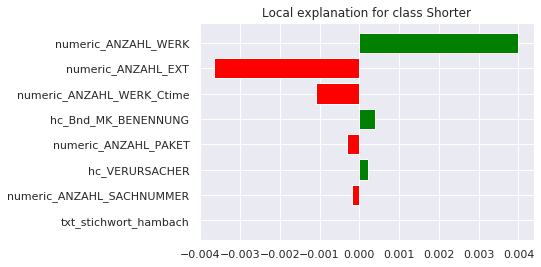

In [1445]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [1300]:
exp.class_names

['Longer', 'Shorter']

In [1446]:
exp.show_in_notebook(labels=None)

In [1401]:
exp.save_to_file('exp.html')

### Feature Correlation

In [1302]:
df_x_it_pre

<12854x12528 sparse matrix of type '<class 'numpy.float64'>'
	with 233363 stored elements in Compressed Sparse Row format>

In [1303]:
df_input_pre = pd.DataFrame(df_x_it_pre.toarray(), columns=list(feature_names))
df_input_pre

txt_ist_aas  txt_ist_abbau  txt_ist_abbiegelicht  txt_ist_abbild  \
0              0.0            0.0                   0.0             0.0   
1              0.0            0.0                   0.0             0.0   
2              0.0            0.0                   0.0             0.0   
3              0.0            0.0                   0.0             0.0   
4              0.0            0.0                   0.0             0.0   
...            ...            ...                   ...             ...   
12849          0.0            0.0                   0.0             0.0   
12850          0.0            0.0                   0.0             0.0   
12851          0.0            0.0                   0.0             0.0   
12852          0.0            0.0                   0.0             0.0   
12853          0.0            0.0                   0.0             0.0   

       txt_ist_abblend  txt_ist_abblendlicht  txt_ist_abblenlicht  \
0                  0.0                   0.0                  0.0   
1                  0.0                   0.0                  0.0   
2                  0.0                   0.0                  0.0   
3                  0.0                   0.0                  0.0   
4                  0.0                   0.0                  0.0   
...                ...                   ...                  ...   
12849              0.0                   0.0                  0.0   
12850              0.0                   0.0                  0.0   
12851              0.0                   0.0                  0.0   
12852              0.0                   0.0                  0.0   
12853              0.0                   0.0                  0.0   

       txt_ist_abbrech  txt_ist_abbruch  txt_ist_abd  ...  \
0                  0.0              0.0          0.0  ...   
1                  0.0              0.0          0.0  ...   
2                  0.0              0.0          0.0  ...   
3                  0.0              0.0          0.0  ...   
4                  0.0              0.0          0.0  ...   
...                ...              ...          ...  ...   
12849              0.0              0.0          0.0  ...   
12850              0.0              0.0          0.0  ...   
12851              0.0              0.0          0.0  ...   
12852              0.0              0.0          0.0  ...   
12853              0.0              0.0          0.0  ...   

       txt_stichwort_zuziehgriff  txt_stichwort_zweit  \
0                            0.0                  0.0   
1                            0.0                  0.0   
2                            0.0                  0.0   
3                            0.0                  0.0   
4                            0.0                  0.0   
...                          ...                  ...   
12849                        0.0                  0.0   
12850                        0.0                  0.0   
12851                        0.0                  0.0   
12852                        0.0                  0.0   
12853                        0.0                  0.0   

       txt_stichwort_zwischenwell  hc_VERURSACHER  hc_Bnd_MK_BENENNUNG  \
0                             0.0        0.532051             0.351791   
1                             0.0        0.465664             0.351791   
2                             0.0        0.465664             0.351791   
3                             0.0        0.465664             0.400000   
4                             0.0        0.432632             0.400000   
...                           ...             ...                  ...   
12849                         0.0        0.465664             0.394737   
12850                         0.0        0.465664             0.394737   
12851                         0.0        0.465664             0.394737   
12852                         0.0        0.465664             0.394737   
12853                         0.0        0.43

In [1304]:
df_x_it.groupby(['DAUER_KAT_num'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

DAUER_KAT_num
0    6579
1    6275
Name: BUENDEL_NUMMER, dtype: int64

In [1305]:
df_input_pre['DAUER_KAT_num']=df_x_it['DAUER_KAT_num']

In [1306]:
col_names = df_input_pre.columns.tolist()
col_names

['txt_ist_aas',
 'txt_ist_abbau',
 'txt_ist_abbiegelicht',
 'txt_ist_abbild',
 'txt_ist_abblend',
 'txt_ist_abblendlicht',
 'txt_ist_abblenlicht',
 'txt_ist_abbrech',
 'txt_ist_abbruch',
 'txt_ist_abd',
 'txt_ist_abdamm',
 'txt_ist_abdampf',
 'txt_ist_abdeck',
 'txt_ist_abdeckbl',
 'txt_ist_abdeckgitt',
 'txt_ist_abdeckhaub',
 'txt_ist_abdeckkapp',
 'txt_ist_abdeckklapp',
 'txt_ist_abdeckplatt',
 'txt_ist_abdeckrahm',
 'txt_ist_abdeckscheib',
 'txt_ist_abdeckschi',
 'txt_ist_abdichschi',
 'txt_ist_abdicht',
 'txt_ist_abdichtbar',
 'txt_ist_abdichtkleb',
 'txt_ist_abdichtlipp',
 'txt_ist_abdichtschi',
 'txt_ist_abdruck',
 'txt_ist_abfahrwag',
 'txt_ist_abfall',
 'txt_ist_abfliess',
 'txt_ist_abfrag',
 'txt_ist_abfull',
 'txt_ist_abgang',
 'txt_ist_abgangsricht',
 'txt_ist_abgas',
 'txt_ist_abgasanlag',
 'txt_ist_abgasklapp',
 'txt_ist_abgasklappenstell',
 'txt_ist_abgasleit',
 'txt_ist_abgasnorm',
 'txt_ist_abgasruckfuhr',
 'txt_ist_abgeb',
 'txt_ist_abgekundigt',
 'txt_ist_abgelegt',
 

In [1307]:
list_non_txt_cols =[]
len_cols = len(col_names)

for i in col_names:
    if i.startswith('hc_'):
        list_non_txt_cols.append(i)
    
    if i.startswith('oh_'):
        list_non_txt_cols.append(i)
        
    if i.startswith('numeric_'):
        list_non_txt_cols.append(i)

In [1308]:
list_non_txt_cols

['hc_VERURSACHER',
 'hc_Bnd_MK_BENENNUNG',
 'numeric_ANZAHL_PAKET',
 'numeric_ANZAHL_WERK_Ctime',
 'numeric_ANZAHL_WERK',
 'numeric_ANZAHL_EXT',
 'numeric_ANZAHL_SACHNUMMER']

In [1309]:
list_non_txt_cols.append('DAUER_KAT_num')

In [1490]:
df_buendel_linked.columns

Index(['BUENDEL_NUMMER', 'SACHNUMMER', 'ZB_BENENNUNG', 'MODULGRUPPE',
       'EMISSIONSKENNZEICHEN', 'BESCHAFFUNGSART', 'SICHERHEITSRELEVANT',
       'TEILEART', 'WERKZEUGAENDERUNG_ERFORDERLICH',
       'EE_STEUERGERAET_BETROFFEN', 'BETRIEBSANLEITUNG_BETROFFEN',
       'LEITUNGSSATZ_BETROFFEN', 'LASTENHEFTAENDERUNG_ERFORDERLICH',
       'VERSUCHSTEIL_ASACHNUMMER_BETROFFEN', 'Kennbuchstabe', 'MSK', 'MK',
       'SUBK', 'TypZahl', 'KG', 'U', 'KGU', 'Fortlaufende_Nummer',
       'Teilnummer_Untergruppe', 'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG',
       'Bnd_ID', 'CREATION_DATE', 'RUECKMELDE_DATUM', 'MODIFICATION_DATE',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'Bnd_KAT', 'new_IST',
       'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'B

In [1310]:
corr_non_text = df_input_pre[list_non_txt_cols].corr()

In [1311]:
corr_non_text

hc_VERURSACHER  hc_Bnd_MK_BENENNUNG  \
hc_VERURSACHER                   1.000000             0.306397   
hc_Bnd_MK_BENENNUNG              0.306397             1.000000   
numeric_ANZAHL_PAKET             0.033195            -0.118380   
numeric_ANZAHL_WERK_Ctime        0.019306            -0.091774   
numeric_ANZAHL_WERK              0.129886            -0.003076   
numeric_ANZAHL_EXT               0.017421            -0.012546   
numeric_ANZAHL_SACHNUMMER        0.043938             0.034456   
DAUER_KAT_num                   -0.019547             0.003249   

                           numeric_ANZAHL_PAKET  numeric_ANZAHL_WERK_Ctime  \
hc_VERURSACHER                         0.033195                   0.019306   
hc_Bnd_MK_BENENNUNG                   -0.118380                  -0.091774   
numeric_ANZAHL_PAKET                   1.000000                   0.324634   
numeric_ANZAHL_WERK_Ctime              0.324634                   1.000000   
numeric_ANZAHL_WERK                    0.386299                   0.251252   
numeric_ANZAHL_EXT                     0.113417                   0.479188   
numeric_ANZAHL_SACHNUMMER              0.083413                   0.106391   
DAUER_KAT_num                         -0.020061                   0.032944   

                           numeric_ANZAHL_WERK  numeric_ANZAHL_EXT  \
hc_VERURSACHER                        0.129886            0.017421   
hc_Bnd_MK_BENENNUNG                  -0.003076           -0.012546   
numeric_ANZAHL_PAKET                  0.386299            0.113417   
numeric_ANZAHL_WERK_Ctime             0.251252            0.479188   
numeric_ANZAHL_WERK                   1.000000            0.127423   
numeric_ANZAHL_EXT                    0.127423            1.000000   
numeric_ANZAHL_SACHNUMMER             0.038917            0.164927   
DAUER_KAT_num                         0.000764           -0.027760   

                           numeric_ANZAHL_SACHNUMMER  DAUER_KAT_num  
hc_VERURSACHER                              0.043938      -0.019547  
hc_Bnd_MK_BENENNUNG                         0.034456       0.003249  
numeric_ANZAHL_PAKET                        0.083413      -0.020061  
numeric_ANZAHL_WERK_Ctime                   0.106391       0.032944  
numeric_ANZAHL_WERK                         0.038917       0.000764  
numeric_ANZAHL_EXT                          0.164927      -0.027760  
numeric_ANZAHL_SACHNUMMER                   1.000000      -0.020440  
DAUER_KAT_num                              -0.020440       1.000000

In [1191]:
corr_dauer = df_input_pre[list_non_txt_cols].drop("DAUER_KAT_num", axis=1).apply(lambda x: x.corr(df_input_pre[list_non_txt_cols].DAUER_KAT_num))

In [1192]:
corr_dauer

hc_VERURSACHER              -0.019547
hc_Bnd_MK_BENENNUNG          0.003249
numeric_ANZAHL_PAKET        -0.020061
numeric_ANZAHL_WERK          0.000764
numeric_ANZAHL_EXT          -0.027760
numeric_ANZAHL_SACHNUMMER   -0.020440
dtype: float64

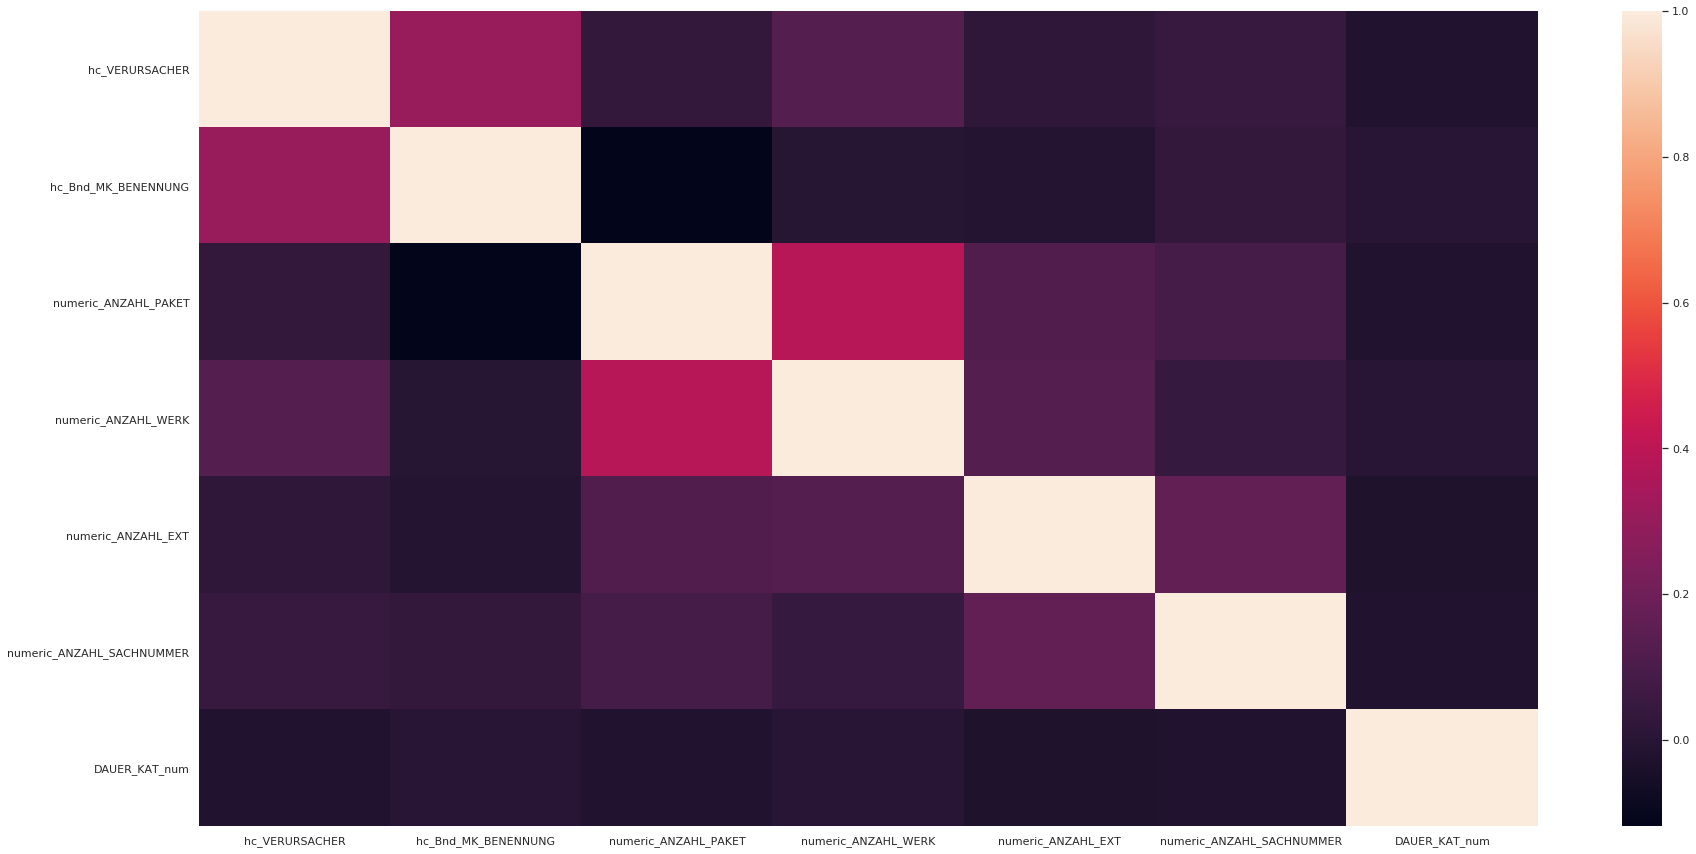

In [1195]:
fig = plt.figure(figsize = (30, 15))
sns.heatmap(corr_non_text)

In [1196]:
corr_non_text

hc_VERURSACHER  hc_Bnd_MK_BENENNUNG  \
hc_VERURSACHER                   1.000000             0.306397   
hc_Bnd_MK_BENENNUNG              0.306397             1.000000   
numeric_ANZAHL_PAKET             0.033195            -0.118380   
numeric_ANZAHL_WERK              0.129886            -0.003076   
numeric_ANZAHL_EXT               0.017421            -0.012546   
numeric_ANZAHL_SACHNUMMER        0.043938             0.034456   
DAUER_KAT_num                   -0.019547             0.003249   

                           numeric_ANZAHL_PAKET  numeric_ANZAHL_WERK  \
hc_VERURSACHER                         0.033195             0.129886   
hc_Bnd_MK_BENENNUNG                   -0.118380            -0.003076   
numeric_ANZAHL_PAKET                   1.000000             0.386299   
numeric_ANZAHL_WERK                    0.386299             1.000000   
numeric_ANZAHL_EXT                     0.113417             0.127423   
numeric_ANZAHL_SACHNUMMER              0.083413             0.038917   
DAUER_KAT_num                         -0.020061             0.000764   

                           numeric_ANZAHL_EXT  numeric_ANZAHL_SACHNUMMER  \
hc_VERURSACHER                       0.017421                   0.043938   
hc_Bnd_MK_BENENNUNG                 -0.012546                   0.034456   
numeric_ANZAHL_PAKET                 0.113417                   0.083413   
numeric_ANZAHL_WERK                  0.127423                   0.038917   
numeric_ANZAHL_EXT                   1.000000                   0.164927   
numeric_ANZAHL_SACHNUMMER            0.164927                   1.000000   
DAUER_KAT_num                       -0.027760                  -0.020440   

                           DAUER_KAT_num  
hc_VERURSACHER                 -0.019547  
hc_Bnd_MK_BENENNUNG             0.003249  
numeric_ANZAHL_PAKET           -0.020061  
numeric_ANZAHL_WERK             0.000764  
numeric_ANZAHL_EXT             -0.027760  
numeric_ANZAHL_SACHNUMMER      -0.020440  
DAUER_KAT_num                   1.000000